Updated DeepCore TCP plotter. Shows probabilities with the points. Occasionally throws cpp object errors because it thinks the TGraphs don't exist.

In [1]:
# Necessary imports
import keras
from keras.callbacks import Callback
from keras.models import Model,load_model, Sequential
from keras.layers import Input, LSTM, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, Conv2DTranspose, concatenate, Concatenate, ZeroPadding2D, UpSampling2D, UpSampling1D
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn

import numpy as np
from numpy import concatenate as concatenatenp
import math
import sys
import argparse
import matplotlib as mpl
#mpl.use('Agg') # disables showing plots
import matplotlib.backends.backend_pdf as backpdf
from  matplotlib import pyplot as plt
import pylab
import glob
import scipy

import uproot

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

#from IPython.display import Image
#from IPython.display import display

In [2]:
# Variable init
jetNum=0# number of jets in the input. will be filled with local input information
jetNum_validation = 0# number of jets in the input. will be filled with local input information
jetDim=30 #dimension of window on the pixed detector layer (cannot be changed without chaning the training sample)
overlapNum =3 #numer of overlap considered (cannot be changed without chaning the training sample)
layNum = 4 ## 4 for barrel, for endcap use layNum = 7 #4 barrel+3 endcap. the numeration is 1-4 for barrel, 5-7 for endcap (cannot be changed without chaning the training sample).
parNum=5 #number of track parameters (cannot be changed without chaning the training sample)
_Epsilon = 1e-7 #value needed for the loss functione valuation
batch_size = 64 # Batch size for training.
# DeepCore samples have the following file/tree names
inputModuleName= "DeepCoreNtuplizerTest" 
inputTreeName= "DeepCoreNtuplizerTree" 

# Default prob_thr. Needs to be adjust depending on the DeepCore version used
prob_thr =0.32 # threshold to identfy good prediciton (see DeepCore documentation to details)





In [3]:
# Class and function definition
class validationCall(Callback) : 
    def on_epoch_end(self,epoch, logs={}) :
        [call_par, call_prob] = self.model.predict([input_,input_jeta,input_jpt])
        call_prob = call_prob[:,:,:,:,:-1]

        for par in range(parNum) :
            bins = []# np.zeros(shape=(int(jetNum*valSplit)))
            nbin =0
            for j in range (int(jetNum*valSplit)) :
                j_eff = j+int(jetNum*(1-valSplit))
                for x in range(jetDim) :
                    for y in range(jetDim) :
                        for trk in range(overlapNum) :
                             if target_prob[j_eff][x][y][trk][0] == 1 :
                                if(par!=4) :
                                    bins.append((call_par[j_eff][x][y][trk][par] - target_[j_eff][x][y][trk][par])*0.01)
                                else :
                                     bins.append((call_par[j_eff][x][y][trk][par] - target_[j_eff][x][y][trk][par])/target_[j_eff][x][y][trk][par])  #relative
                                nbin = nbin+1

            plt.figure()
            pylab.hist(bins,100, facecolor='green', alpha=0.75)
            pylab.title('parNum error distribution_ep{EPOCH}_par{PAR}'.format(PAR=par,EPOCH=epoch))
            pylab.ylabel('entries')
            pylab.xlabel('parNum error')
            plt.grid(True)
            # pylab.savefig("parameter_error_{EPOCH}_{PAR}.pdf".format(PAR=par,EPOCH=epoch))
            pdf_par.savefig()

        N_eff_4 = 0
        N_eff_8 = 0
        N_fake_4 =0
        N_fake_8 = 0
        genTrackNum=3
        N_tot_eff = jetNum*valSplit*genTrackNum
        N_tot_fake = 0
        layDist=3
        for j in range (int(jetNum*valSplit)) :
            j_eff = j+int(jetNum*(1-valSplit))
            for x in range(jetDim) :
                for y in range(jetDim) :
                    for trk in range(overlapNum) :
                        if target_prob[j_eff][x][y][trk][0]==1 :
                            chi2x = (call_par[j_eff][x][y][trk][0] - target_[j_eff][x][y][trk][0])**2
                            chi2y = (call_par[j_eff][x][y][trk][1] - target_[j_eff][x][y][trk][1])**2
                            chi2xt = (call_par[j_eff][x][y][trk][2] - target_[j_eff][x][y][trk][2])**2 / math.atan(2/float(layDist*3))
                            chi2yt = (call_par[j_eff][x][y][trk][3] - target_[j_eff][x][y][trk][3])**2 / math.atan(2/float(layDist*3))
                            chi2 = chi2x+chi2y+chi2xt+chi2yt
                            if chi2<=4  and call_prob[j_eff][x][y][trk]>prob_thr:
                                N_eff_4 = N_eff_4 +1
                            if chi2<=8  and call_prob[j_eff][x][y][trk]>prob_thr:
                                N_eff_8 = N_eff_8 +1
                        if call_prob[j_eff][x][y][trk] > prob_thr :
                            N_tot_fake = N_tot_fake +1
                            chi2x = (call_par[j_eff][x][y][trk][0] - target_[j_eff][x][y][trk][0])**2
                            chi2y = (call_par[j_eff][x][y][trk][1] - target_[j_eff][x][y][trk][1])**2
                            chi2xt = (call_par[j_eff][x][y][trk][2] - target_[j_eff][x][y][trk][2])**2 / math.atan(2/float(layDist*3))
                            chi2yt = (call_par[j_eff][x][y][trk][3] - target_[j_eff][x][y][trk][3])**2 / math.atan(2/float(layDist*3))
                            chi2 = chi2x+chi2y+chi2xt+chi2yt
                            if chi2>=4  and target_prob[j_eff][x][y][trk][0]==1:
                                N_fake_4 = N_fake_4 +1
                            if chi2>=8  and target_prob[j_eff][x][y][trk][0]==1:
                                N_fake_8 = N_fake_8 +1

        efficiency_4[epoch] = N_eff_4/N_tot_eff
        if N_tot_fake == 0 :
            fake_rate_4[epoch] = 1
        else :
           fake_rate_4[epoch] = N_fake_4/N_tot_fake

        efficiency_8[epoch] = N_eff_8/N_tot_eff
        if N_tot_fake == 0  :
            fake_rate_8[epoch] = 1
        else :
           fake_rate_8[epoch] = N_fake_8/N_tot_fake

#callback to have additional trained model every 10 epochs
class wHistory(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs={}):
       if epoch % 10 == 0 :
               self.model.save("trained"+str(epoch+0)+".h5")
wH = wHistory()

#callback to have the weight saved every batch
class WeightsSaver(Callback):
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = 'weights%08d.h5' % self.batch
            self.model.save_weights(name)
        self.batch += 1

#used in EXTRA_VALIDATION to have additional log info
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()


#used in the losses
def _to_tensor(x, dtype):
    return ops.convert_to_tensor(x, dtype=dtype)

#used in the losses
def epsilon():
    return _Epsilon

#loss function for probability, used in the first part of the training
def loss_ROI_crossentropy(target, output):
    epsilon_ = _to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    wei = target[:,:,:,:,-1:]
    target = target[:,:,:,:,:-1]
    output = output[:,:,:,:,:-1]
    output = math_ops.log(output / (1 - output))
    retval = nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=10)#900=works #2900=200x200, 125=30x30
    retval = retval*wei
    return tf.reduce_sum(retval, axis=None)/(tf.reduce_sum(wei,axis=None)+0.00001) #0.00001 needed to avoid numeric issue
    #return tf.reduce_sum(retval, axis=None)

#loss function for probability, used in the last part of the training (difference: non-zero weight to pixel far from crossing point)
def loss_ROIsoft_crossentropy(target, output):
    epsilon_ = _to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    wei = target[:,:,:,:,-1:]
    target = target[:,:,:,:,:-1]
    output = output[:,:,:,:,:-1]
    output = math_ops.log(output / (1 - output))
    retval = nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=10)#900=works #2900=200x200, 125=30x30
    retval = retval*(wei+0.01) # here the difference
    return tf.reduce_sum(retval, axis=None)/(tf.reduce_sum((wei+0.01),axis=None))

#loss for track parameter
def loss_mse_select_clipped(y_true, y_pred) :
    wei = y_true[:,:,:,:,-1:]
    pred = y_pred[:,:,:,:,:-1]
    true =  y_true[:,:,:,:,:-1]
    print(wei)
    print(pred)
    out =K.square(tf.clip_by_value(pred-true,-5,5))*wei
    return tf.reduce_sum(out, axis=None)/(tf.reduce_sum(wei,axis=None)*5+0.00001) #5=parNum

# Generator used to load all the input file in the LOCAL_INPUT=False workflow
## Changed uproot to uproot3 in order to use central sample

In [4]:
# updated TP loss for DeepCore 2.2
#loss for track parameter
def loss_mse_select_clipped(y_true, y_pred) :
    wei = y_true[:,:,:,:,-1:]
    pred = y_pred[:,:,:,:,:-1]
    true =  y_true[:,:,:,:,:-1]
    inv_sd = tf.constant([1/0.404, 1/0.478, 1/1.9, 1/2, 1/150], dtype=tf.float32) # inverse standard deviation of each TP
    mean = tf.constant([0, 0, 0, 0, 95], dtype=tf.float32) # mean of each TP
    # Standardization of target and predicted TPs
    pred = tf.subtract(pred, mean)* inv_sd
    true = tf.subtract(true,mean)*inv_sd
    out =K.square(tf.clip_by_value(pred-true,-5,5))*wei
    return tf.reduce_sum(out, axis=None)/(tf.reduce_sum(wei,axis=None)*5+0.00001) #5=parNum



In [5]:
# definition of Generator 2: used to load inputs (merged clusters) using less memory
def Generator2(filepath,batch_size=0,count=False):

    if count:
        branches = ["jet_eta"]
        batch_size = 500
    else:
        branches = ["cluster_measured","jet_eta","jet_pt","trackPar","trackProb"]

    while 1:
        for cycle in range(1,9):
           # print(cycle)
            for chunk in uproot.iterate("{}:{}/{};{}".format(filepath,inputModuleName,inputTreeName,str(cycle)),branches,step_size=batch_size,library="np"):
                if count:
                    yield chunk['jet_eta'].shape[0]
                else:
                    nev = len(chunk["trackProb"])

                    target_prob = np.reshape(chunk["trackProb"], (nev,jetDim,jetDim,overlapNum,1))

                    target_prob = concatenatenp([target_prob,chunk["trackPar"][:,:,:,:,-1:]],axis=4)
                    ## debug
                    ##pdb.set_trace()
                    
                    
                    yield [chunk['cluster_measured'][:,:,:,0:layNum],chunk["jet_eta"],chunk["jet_pt"]],[chunk["trackPar"],target_prob]
                    
        if count:
            break

In [6]:
# Testing samples info
inputs = []
tot_events = 0

# old training files
#testing_path ="testing_samples/old_TestingSamples/DeepCoreTrainingSample*"

# new training files
#testing_path ="testing_samples/TestingSamples2.2/DeepCoreTraining*"
testing_path = "/Users/liamoshaughnessy/Desktop/Research_2023_2024/Code/Python_Files/Semester_1/TestingSamples2/DeepCoreTraining*"   
print("number of  testing files=", len(glob.glob(testing_path)))

for batch in Generator2(testing_path,count=True):
        #pdb.set_trace()
        tot_events += batch
        
jetNum = tot_events
print("total number of events =", jetNum)


number of  testing files= 30
total number of events = 915878


In [7]:
# DeepCore 2.2 Architecture (Older Architectures at the end)
from keras.layers import AlphaDropout

NNinputs_jeta = Input(shape=(1,))
NNinputs_jpt = Input(shape=(1,))
NNinputsJet = concatenate([NNinputs_jeta,NNinputs_jpt])
jetReshaped = Reshape((1,1,2))(NNinputsJet)
jetUps = UpSampling2D(size=(jetDim,jetDim), data_format="channels_last")(jetReshaped)
print("jetUps=", jetUps.shape)
NNinputs = Input(shape=(jetDim,jetDim,layNum))
print("NNinputs=", NNinputs.shape)
ComplInput = concatenate([NNinputs,jetUps],axis=3)
print("ComplInput=", ComplInput.shape)

   
conv30_9 = Conv2D(50,7, data_format="channels_last", input_shape=(jetDim,jetDim,layNum+2), activation='relu',padding="same")(ComplInput)
conv30_7 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_9)
conv30_5 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_7)#
conv20_5 = Conv2D(30,5, data_format="channels_last", activation='relu',padding="same")(conv30_5)
conv15_5 = Conv2D(30,3, data_format="channels_last", activation='relu',padding="same")(conv20_5)

conv15_3_1 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_5)
conv15_3_2 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_1)
conv15_3_3 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_2) #(12,3)
conv15_3 = Conv2D(18,3, data_format="channels_last",padding="same")(conv15_3_3) #(12,3)
reshaped = Reshape((jetDim,jetDim,overlapNum,parNum+1))(conv15_3)

conv12_3_1 = Conv2D(30,3, data_format="channels_last", activation='relu', padding="same")(conv15_5)  #new
conv1_3_2 = Conv2D(30,3, data_format="channels_last", activation='relu', padding="same")(conv12_3_1) #drop7lb   #new
conv1_3_3 = Conv2D(30,3, data_format="channels_last", activation='relu',padding="same")(conv1_3_2) #new
conv1_3_1 = Conv2D(6,3, data_format="channels_last", activation='sigmoid', padding="same")(conv1_3_3)
reshaped_prob = Reshape((jetDim,jetDim,overlapNum,2))(conv1_3_1)

model = Model([NNinputs,NNinputs_jeta,NNinputs_jpt],[reshaped,reshaped_prob])
anubi = tf.keras.optimizers.Adam(learning_rate=0.0000001)#after epochs 252 (with septs/20 and batch_size 64)

model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROIsoft_crossentropy], loss_weights=[1,1]) #FOR LATE TRAINING
#model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROI_crossentropy], loss_weights=[1,1]) #FOR EARLY TRAINING
model.summary()


jetUps= (None, 30, 30, 2)
NNinputs= (None, 30, 30, 4)
ComplInput= (None, 30, 30, 6)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 reshape (

In [8]:
# Loading DeepCore model and evaluation on small stats
batch = 3800 # You may increase the number of Merged clusters up to 3800
inputs = []
chunk = next(Generator2(testing_path,batch)) 
#chunk = next(Generator2(testing_path,batch,))
#inputs.append(chunk[0])

## Importing model
#model.load_weights('Valerio_model.hdf5') # DeepCore 1.0
#model.load_weights('DeepCore_model_1017.h5') # DeepCore 2.0
model.load_weights('/Users/liamoshaughnessy/Desktop/Research_2023_2024/Code/Python_Files/Semester_1/DeepCore_model_0622.h5') # DeepCore 2.2
#model.summary()

## Making all the predictions
[validation_par,validation_prob] = model.predict(chunk[0])
validation_par = np.float64(validation_par)

119/119 [==============================] - 10s 84ms/step


# DeepCore Notebook Printouts

The format of the prediction arrays are as follow: 

1) validation_prob[merged_cluster, x,  y, track, [probability, fake probability]]

2) validation_par[merged_cluster, x,  y, track, [dx, dy, deta, dphi, 1/pt, zero_flag]] 

- Your inputs are merged cluster --> N

- Your image size is x = 30 by y = 30.

- For every pixel (30*30 = 900) in every merged cluster there are 3 predicted tracks so track = 3.

- For every predicted track in every pixel of every merged cluster, you have a prediction score in validation_prob (how likely that a particle crossed this pixel) and predicted parameters in validation_par (dx, dy, deta, dphi, 1/pt). Please ignore "fake probability" and "zero_flag".



The format of the target/truth information has similar formatting to the prediction, but it included in the Training sample input array, which also contains the CNN input information.

For DeepCore to make a prediction, it requires this input information for every merged cluster: the charge deposit on every pixel of every layer (30 x 30 x4), jet pt and jet eta.

The target information is included in chunk[1], while the input information is included in chunk[0]. 

- Target Track Parameters: chunk[1][0][merged_cluster][x][y][track][dx,dy,deta,dphi,1/pt,prob_flag] (ignore "prob_flag").

- Target Track Score: chunk[1][1][merged_cluster][x][y][track][target_score] (1 if a particle crossed a pixel, 0 otherwise).

- Merged cluster charge deposit: chunk[0][0][merged_cluster][x][y][layer] (4 layers)

- Merged cluster jet eta: chunk[0][1][merged_cluster]

- Merged cluster jet pt: chunk[0][2][merged_cluster]



# Parameter Plots

In [ ]:
# DeepCore 2.2.1 Param plots definition and set up

# Residual Plots
def residual_plots(par, bins):
    if(par== 0) :
        pylab.hist(bins,80,facecolor='darkorange',alpha=0.75,range=(-150,150))
        pylab.title('Residual Distribution - $\Delta x$',fontsize=22)
        # Plotting the mean and sd if needed
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(80, 50000, "Mean =%.2f $\mu$m"%(mean), size=14) 
        #plt.text(80, 60000, "$\sigma_{\Delta x}$ = %.1f $\mu$m"%(sigma), size=14)
        # the tricky part is adjusting the height (50000 for the mean) every time you change statistics
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target [$\mu$m]',fontsize=22)
        plt.grid(True)
    if(par == 1) :
        pylab.hist(bins,120, facecolor='darkorange',alpha=0.75,range=(-200,200))
        pylab.title('Residual Distribution - $\Delta y$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(100, 50000, "Mean =%.1f $\mu$m"%(mean), size=14)
        #plt.text(100, 60000, "$\sigma_{\Delta y}$ = %.1f $\mu$m"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target [$\mu$m]',fontsize=22)
        plt.grid(True)
    if(par== 2):
        pylab.hist(bins,100, facecolor='darkorange',alpha=0.75,range=(-0.02,0.02))
        pylab.title('Residual Distribution - $\Delta \eta$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(0.01, 130000, "Mean = 0", size=14)
        #plt.text(0.01, 150000, "$\sigma_{\Delta \eta}$ = %.3f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target',fontsize=22)
        plt.grid(True)
    if(par == 3):
        pylab.hist(bins,100, facecolor='darkorange',alpha=0.75,range=(-0.02,0.02))
        pylab.title('Residual Distribution - $\Delta \phi$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(0.01, 80000, "Mean = 0", size=14)
        #plt.text(0.01, 90000, "$\sigma_{\Delta \phi}$ = %.3f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target',fontsize=22)
        plt.grid(True)
    if (par == 4) :
        pylab.hist(bins,150, facecolor='darkorange', alpha=0.75,range=(-3,12))#range=(-0.2,0.2))#range=(-2,5)) #relative
        pylab.title('Residual Distribution - p_T$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(4, 28000, "Mean =%.1f"%(mean), size=14)
        #plt.text(4, 25000, "$\sigma_{\Delta(1/p_T)rel}$ = %.1f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('(Prediction-Target)/Target',fontsize=18) #only 1/pt
        plt.grid(True)
   # plt.figure()      

# Target Plots
def target_plots(par, bins):
    if(par == 0):
        pylab.hist(bins,100, facecolor='royalblue', alpha=0.75,range=(-100,100))
        pylab.title('Target Distribution - $\Delta x$',fontsize=22)
        pylab.xlabel('Target [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 1) :
        pylab.hist(bins,100, facecolor='royalblue', alpha=0.75,range=(-150,150))
        pylab.title('Target Distribution - $\Delta y$',fontsize=22)
        pylab.xlabel('Target [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 2) :
        pylab.hist(bins,90, facecolor='royalblue', alpha=0.75,range=(-0.04,0.04))
        pylab.title('Target Distribution - $\Delta \eta$',fontsize=22)
        pylab.xlabel('Target',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 3) :
        pylab.hist(bins,90, facecolor='royalblue', alpha=0.75,range=(-0.04,0.04))
        pylab.title('Target Distribution - $\Delta \phi$',fontsize=22)
        pylab.xlabel('Target',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if (par ==4):
        pylab.hist(bins,100, facecolor='royalblue',alpha=0.75,range=(0,200))
        pylab.title('Target Distribution - $p_T$',fontsize=22)
        pylab.xlabel('Target [GeV]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(False)
   # plt.figure()

# Prediction Plots
def pred_plots(par, bins):
    if(par == 0):
        pylab.hist(bins,80, facecolor='red', alpha=0.75,range=(-150,150))
        pylab.title('Prediction Distribution - $\Delta x$',fontsize=22)
        pylab.xlabel('Prediction [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par ==1) :
        pylab.hist(bins,120, facecolor='red', alpha=0.75,range=(-150,150))
        pylab.title('Prediction Distribution - $\Delta y$',fontsize=22)
        pylab.xlabel('Prediction [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 2) :
        pylab.hist(bins,70, facecolor='red', alpha=0.75,range=(-0.03,0.03))
        pylab.title('Prediction Distribution - $\Delta \eta$',fontsize=22)
        pylab.xlabel('Prediction',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par ==3 ) :
        pylab.hist(bins,70, facecolor='red', alpha=0.75,range=(-0.03,0.03))
        pylab.title('Prediction Distribution - $\Delta \phi$',fontsize=22)
        pylab.xlabel('Prediction',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if (par ==4) :
        pylab.hist(bins,100, facecolor='red',alpha=0.75,range=(0,200))
        pylab.title('Prediction Distribution - $p_T$',fontsize=22)
        pylab.xlabel('Prediction [GeV]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    #plt.figure()
        
# Scatter Plots
def scatter_plots(par, bins_x, bins_y):
    if(par == 0) :
        nx = 100
        plt.hist2d(bins_x, bins_y,bins=nx,range= [[-nx,nx], [-nx, nx]], cmap=plt.cm.viridis)#, marker='+')
        # Plotting diagonal
        l_x = [-150, 150]
        plt.plot(l_x, l_x, color='black') 
        pylab.title('Prediction vs Target - $\Delta x$',fontsize=22)
        plt.ylabel('Predicted $\Delta x$ [$\mu$m]', fontsize=18)
        plt.xlabel('Target $\Delta x$ [$\mu$m]', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 1) :
        ny = 150
        plt.hist2d(bins_x,bins_y,bins=ny,range= [[-ny,ny], [-ny, ny]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_y = [-225,225]
        plt.plot(l_y, l_y, color='black') 
        pylab.title('Prediction vs Target - $\Delta y$',fontsize=22)
        plt.ylabel('Predicted $\Delta y$ [$\mu$m]', fontsize=18)
        plt.xlabel('Target $\Delta y$ [$\mu$m]', fontsize=18)
        # Plotting other lines
        #l_pt = [-75,75]
        #l_zero = [0,0]
        #l_1 = [10,10]
        #l_2 = [-10,-10]
        #plt.plot(l_pt, l_pt, color='black') 
        #plt.plot(l_pt, l_1, color='black', linestyle='dashed') 
        #plt.plot(l_pt, l_2, color='black', linestyle='dashed')
        #plt.plot(l_pt, l_zero, color='black', linestyle='dashed') 
        plt.colorbar()
        plt.grid(False)
    if(par == 2) :
        plt.hist2d(bins_x,bins_y,bins=180,range = [[-0.03,0.03], [-0.03, 0.03]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_eta = [-0.04,0.04]
        plt.plot(l_eta, l_eta, color='black') 
        pylab.title('Prediction vs Target - $\Delta \eta$',fontsize=22)
        plt.ylabel('Predicted $\Delta \eta$ ', fontsize=18)
        plt.xlabel('Target $\Delta \eta$', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 3) :
        plt.hist2d(bins_x,bins_y,bins=180,range = [[-0.03,0.03], [-0.03, 0.03]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_phi = [-0.04,0.04]
        plt.plot(l_phi, l_phi, color='black') 
        pylab.title('Prediction vs Target - $\Delta \phi$',fontsize=22)
        plt.ylabel('Predicted $\Delta \phi$', fontsize=18)
        plt.xlabel('Target $\Delta \phi$', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 4) :
        plt.hist2d(bins_x,bins_y,bins=100,range= [[0,200], [0, 200]])
        # Plotting diagonal
        l_pt = [0, 200]
        #l_zero = [0,0]
        plt.plot(l_pt, l_pt, color='black') 
        #plt.plot(l_zero, l_pt, color='black', linestyle='dashed') 
        #plt.plot(l_pt, l_zero, color='black', linestyle='dashed') 
        pylab.title('Prediction vs Target - $p_T$',fontsize=22)
        plt.ylabel('Predicted $p_T$ [GeV]', fontsize=18)
        plt.xlabel('Target $p_T$ [GeV]', fontsize=18)
        plt.colorbar()
        plt.grid(False)


    

In [ ]:
# Param plotter loop

parNum = 5 # TP
N = batch # Merged clusters
Nx = 30 # x dimension
Ny = 30 # y dimension
Nt = 3 # max Overlap

#DeepCore 2.1.3 Thresholds
prob_threshold = [0.7, 0.85, 1] 
prob_dth_l134 = [0.1, 0.05, 0]
prob_dth_l2 = [0.3, 0.15, 0]

jet_pt = []
jet_eta = []
pbins = [None] * parNum
pbins_pred = [None] * parNum
pbins_target = [None] * parNum
for par in range(parNum) :
    bins = []
    bins_pred = []
    bins_target = []
    for i in range(N): # loop over input
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        jet_pt.append(chunk[0][2][i])
        jet_eta.append(chunk[0][1][i])
        for j in range(Nx): # loop over x
            for k in range(Ny): # loop over y
                for l in range(Nt) : # loop over tracks
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    pixel_lay2_adc = chunk[0][0][i][j][k][1]
                    if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1) and (pixel_lay2_adc ==0) : 
                    #if (pixel_true_prob == 1) and (pixel_lay2_adc>0) : 
                        #threshold DeepCore 2.1.3
                        if((par==0) or (par ==1)) : # dx or dy
                            bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])*100)
                            bins_pred.append(validation_par[i,j,k,l,par]*100)
                            bins_target.append(chunk[1][0][i][j][k][l][par]*100)
                        elif((par==2) or (par ==3)) : # deta or dphi
                            bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])*0.01)
                            bins_pred.append(validation_par[i,j,k,l,par]*0.01)
                            bins_target.append(chunk[1][0][i][j][k][l][par]*0.01)
                        else : #pt
                            bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])/ chunk[1][0][i][j][k][l][par])  #relative
                            bins_pred.append(validation_par[i,j,k,l,par])
                            bins_target.append(chunk[1][0][i][j][k][l][par])
    pbins[par] = bins
    pbins_pred[par] = bins_pred
    pbins_target[par] = bins_target
           


In [ ]:
for n in range(0,5):
    scatter_plots(n, pbins_target[n], pbins_pred[n])
    #target_plots(n, pbins_target[n])
    #pred_plots(n, pbins_pred[n])
    plt.figure()
#pred_plots(3, pbins_pred[3])
#plt.figure()
#target_plots(1, pbins_target[1])
#plt.figure()
#residual_plots(4, pbins[4])
#plt.figure()

In [ ]:
# jet pt distribution
bins_pt = 100
plt.hist(jet_pt, bins=bins_pt, color='r', range = (500, 2500), alpha=0.5)
plt.title('Jet $p_T$ Distrubution')
plt.xlabel('$p_T^{jet}$')
plt.ylabel('Merged Clusters')
plt.grid(True)
plt.show()

In [ ]:
# jet eta distribution
bins_eta = 100
plt.hist(jet_eta, bins=bins_eta, color='b', range = (-1.4, 1.4), alpha=0.5)
plt.title('Jet $\eta$ Distrubution')
plt.xlabel('$\eta^{jet}$')
plt.ylabel('Merged Clusters')
plt.grid(True)
plt.show()

In [ ]:
# jet pt and eta plotted together (I prefer separately)
bins_eta = 100
bins_pt = 100
fig, (j_eta, j_pt) = plt.subplots(2, 1)

j_eta.hist(jet_eta, bins=bins_eta, color='b',range = (-1.4,1.4), alpha=0.5)
j_eta.set_title('Jet $\eta$ Distrubution')
j_eta.set_xlabel('$\eta^{jet}$')
j_eta.set_ylabel('Merged Clusters')
j_pt.hist(jet_pt, bins=bins_pt, color='r', range = (500, 2500), alpha=0.5)
j_pt.set_title('Jet $p_T$ Distrubution')
j_pt.set_xlabel('$p_T^{jet}$')
j_pt.set_ylabel('Merged Clusters')
plt.tight_layout()
#plt.savefig("Jet_eta_and_pt.png")
plt.grid(True)
plt.show()

# TCP Maps

In [9]:
OUTPUT = True
PREDICT = False
ON_DATA = False
DRAW_ONLY = False
RGB = False #True

valSplit=0.2
numPrint = 50#number of event saved in the root file
outEvent= 30

input_ = chunk[0][0]
input_jeta = chunk[0][1]
input_jpt = chunk[0][2]
target_ = chunk[1][0]
target_prob = chunk[1][1]


# linear propagation to the 4 barrel layers, with plotting purpose only
def prop_on_layer(x1,y1,eta,phi,eta_jet,lay) :

    theta_jet = 2*math.atan(math.exp(-eta_jet))
    eta = eta+eta_jet
    theta = 2*math.atan(math.exp(-eta))

    if(lay==0) :
        dist=2.9-6.8
    if(lay==1) :
        dist=6.8-6.8
    if(lay==2) :
        dist=10.9-6.8
    if(lay==3) :
        dist=16-6.8
    distx=dist/0.01
    disty=dist/0.015

    y_out = disty*math.sin(theta-theta_jet)/(math.sin(theta_jet)*math.sin(theta))+y1
    x_out = distx*math.tan(-phi)+x1

    return (x_out,y_out)

# prob thresholds
prob_threshold = [0.7, 0.85, 1] 
prob_dth_l134 = [0.1, 0.05, 0]
prob_dth_l2 = [0.3, 0.15, 0]


4
0
1
6
6
23
21
22
12
24
0
0
0
21
21
0
0
0
17
0
8
0
2
9
10
4
9
9
17
14
17
11
13
11
5
5
5
0
2
0
0
0
4
0
11
10
10
3
16
7
graphPredTot is 50, 4, 4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvasTot_0_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvasTot_0_1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvasTot_0_2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvasTot_0_3
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error in <TGraphPainter::PaintGraph>: illegal number of points (0)
Error 

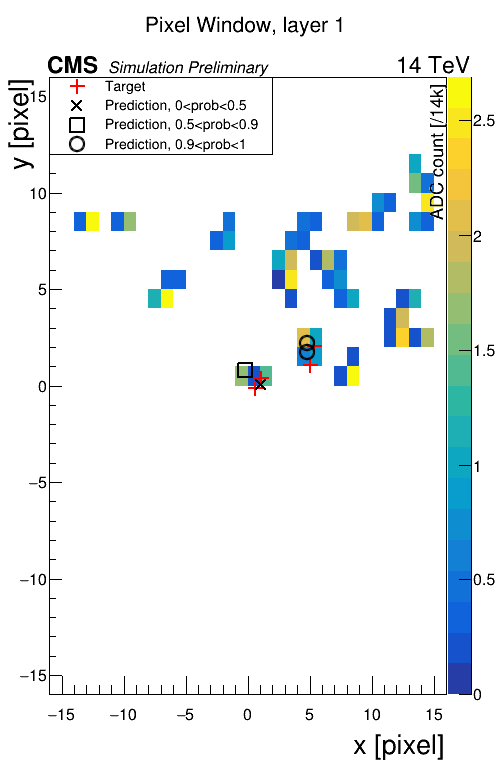

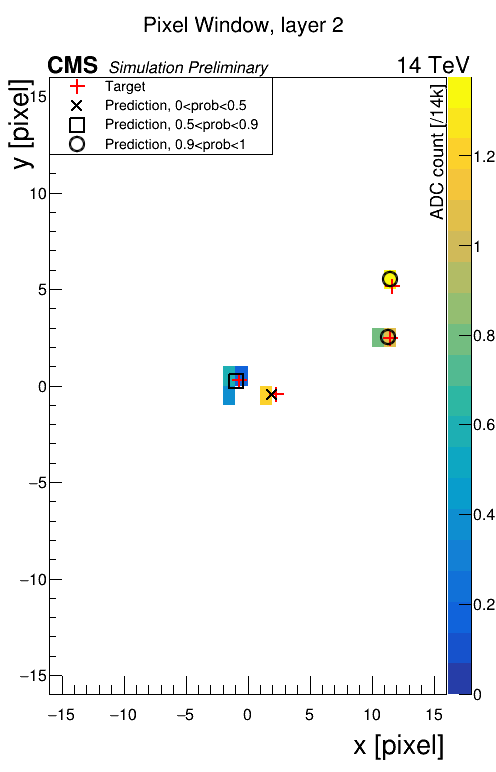

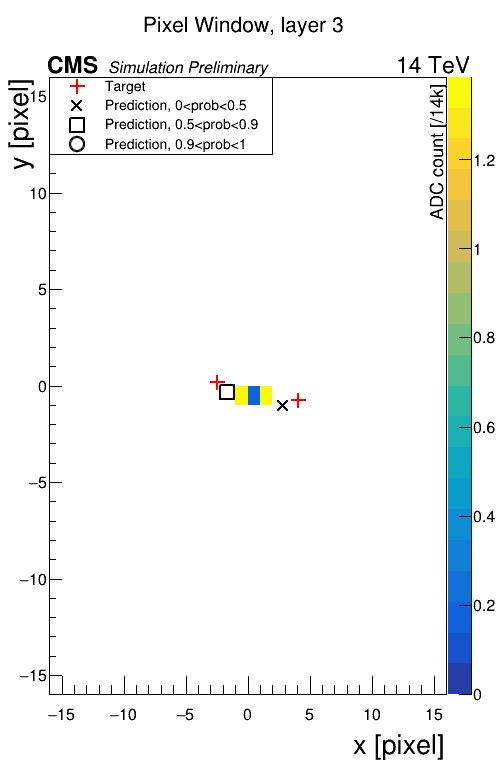

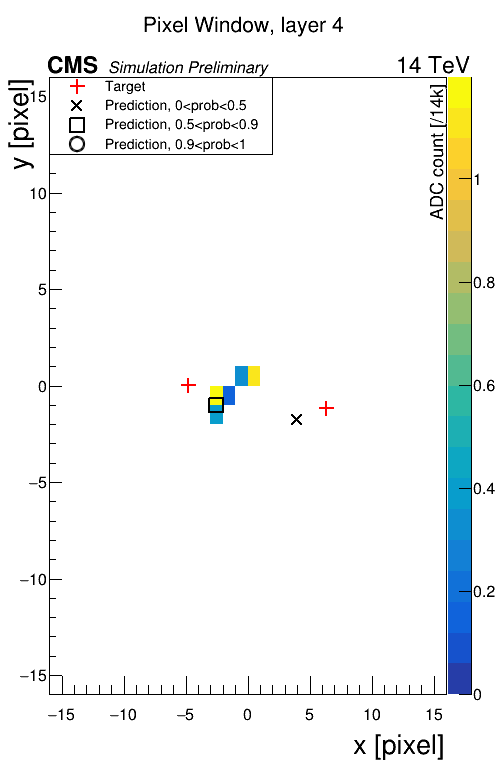

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


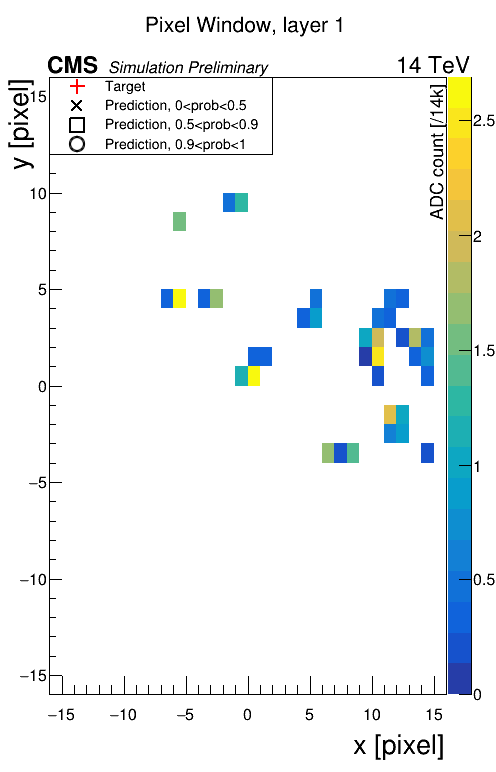

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


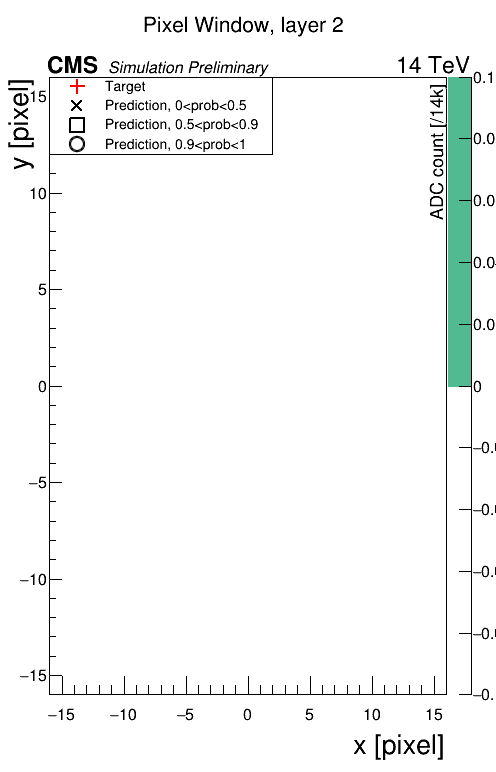

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


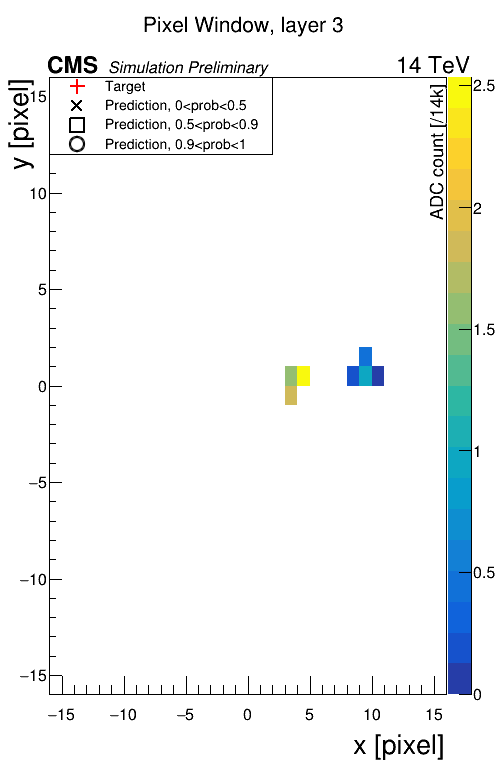

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


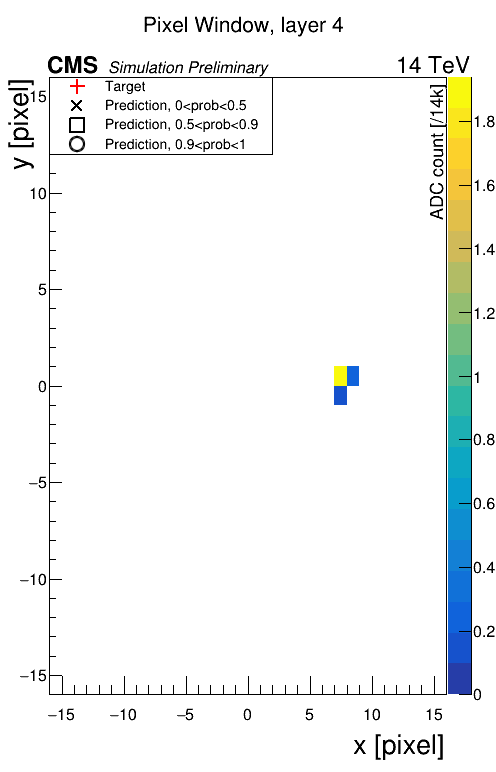

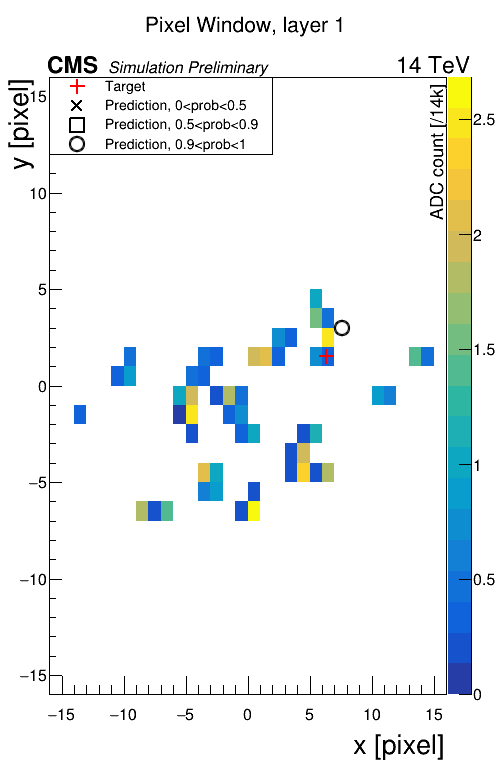

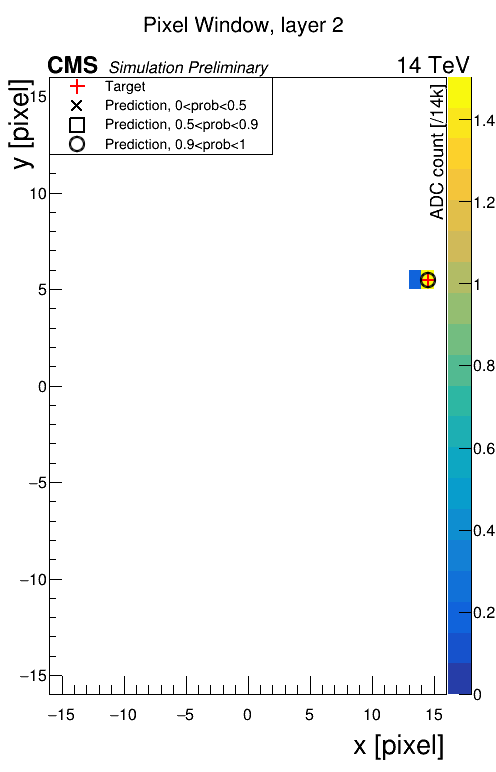

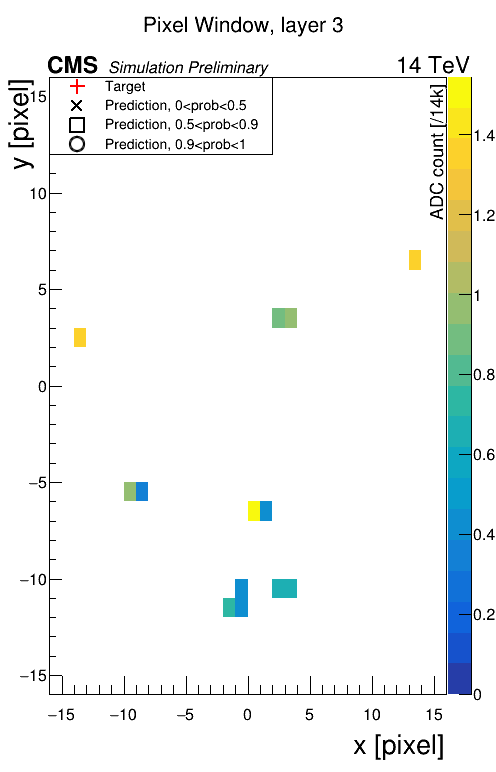

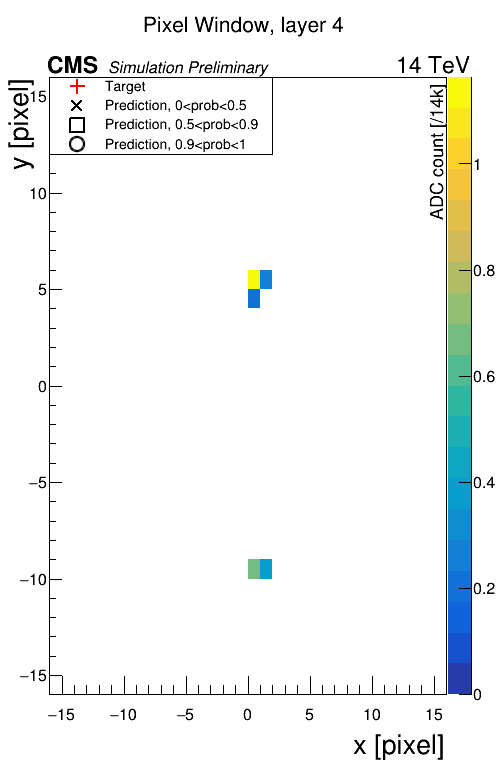

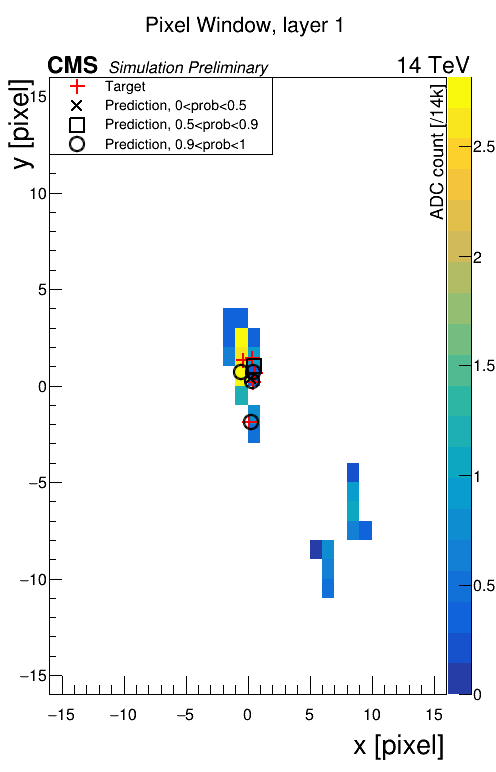

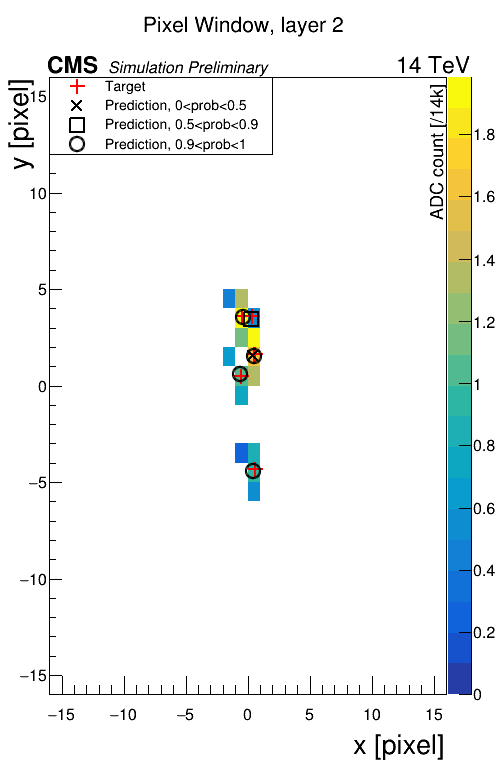

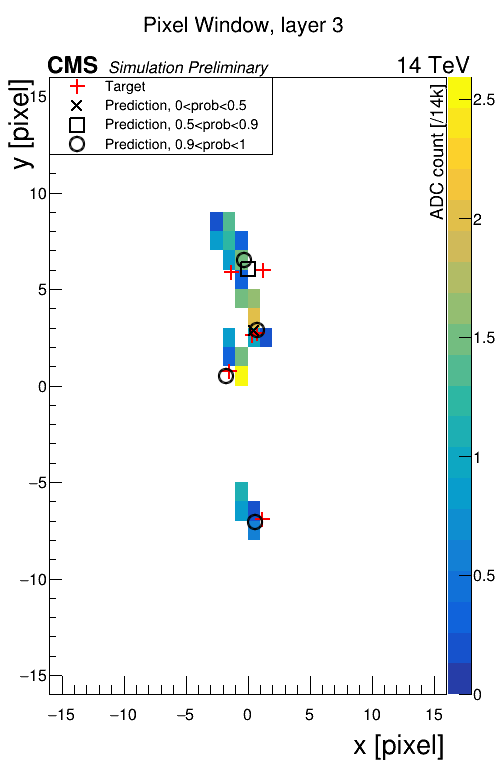

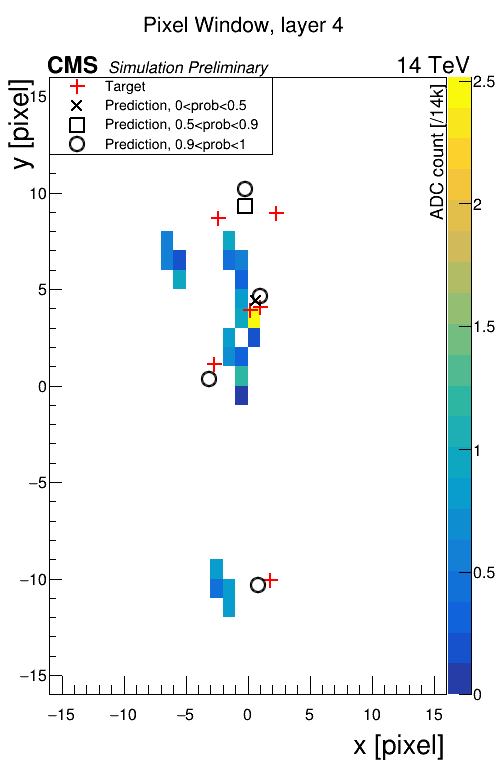

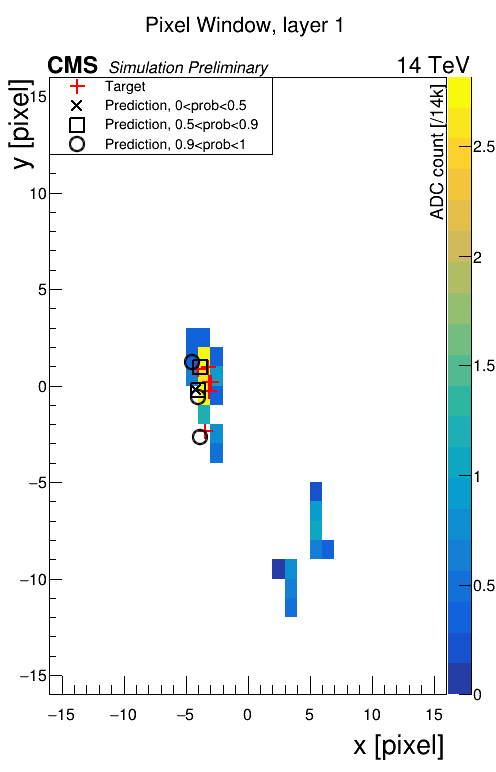

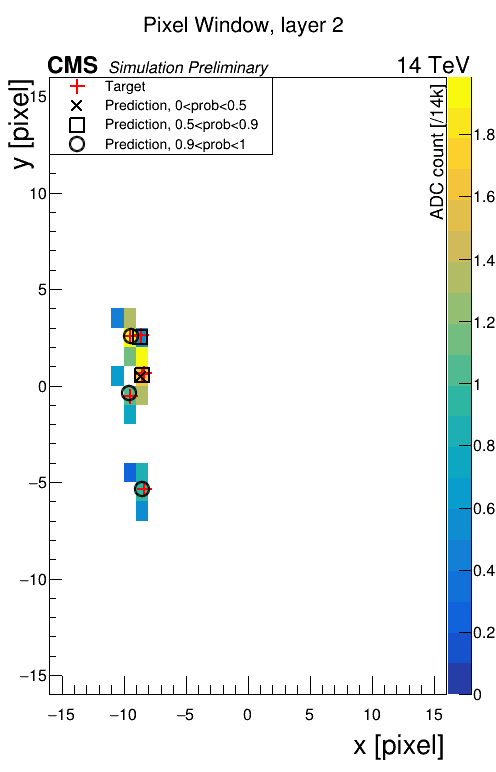

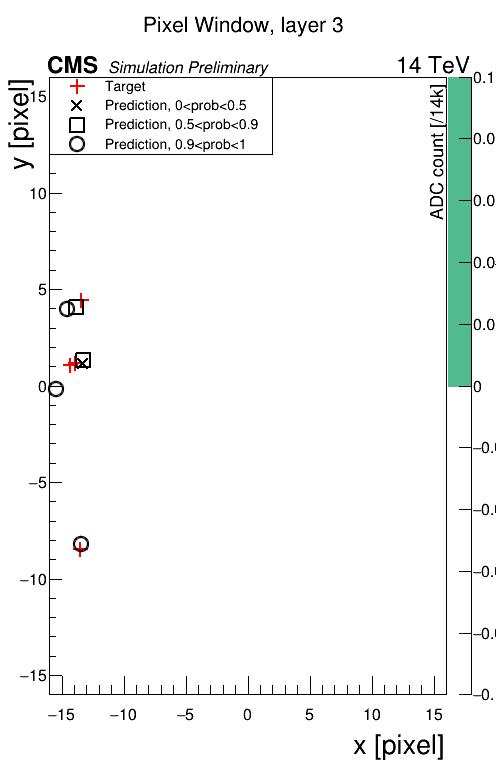

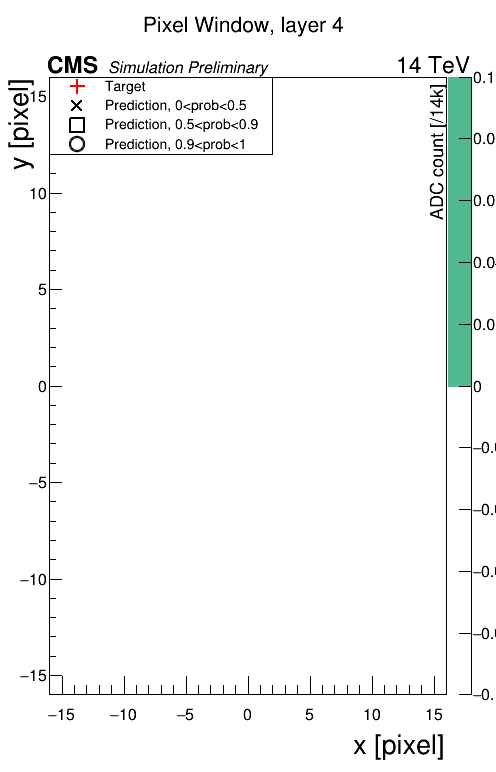

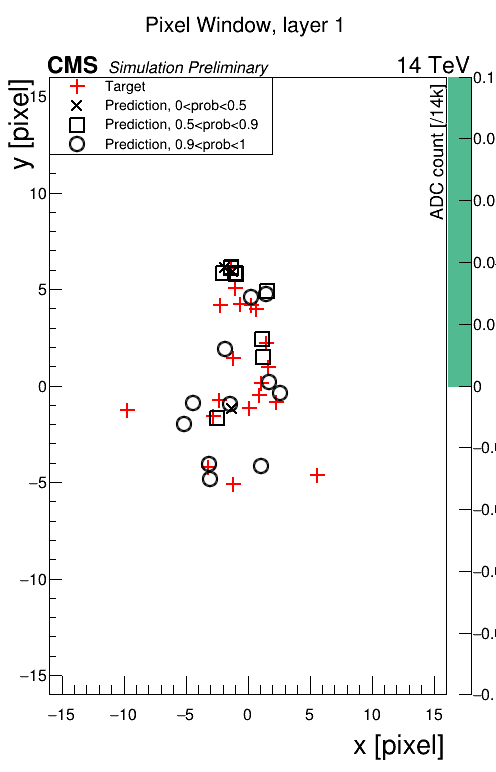

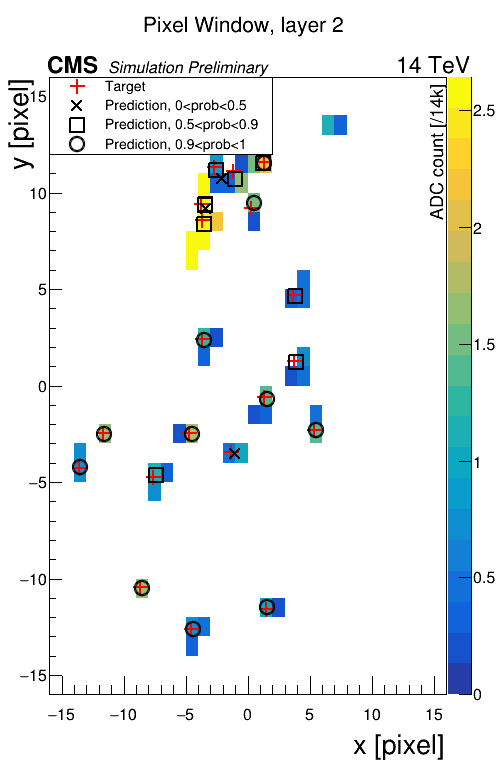

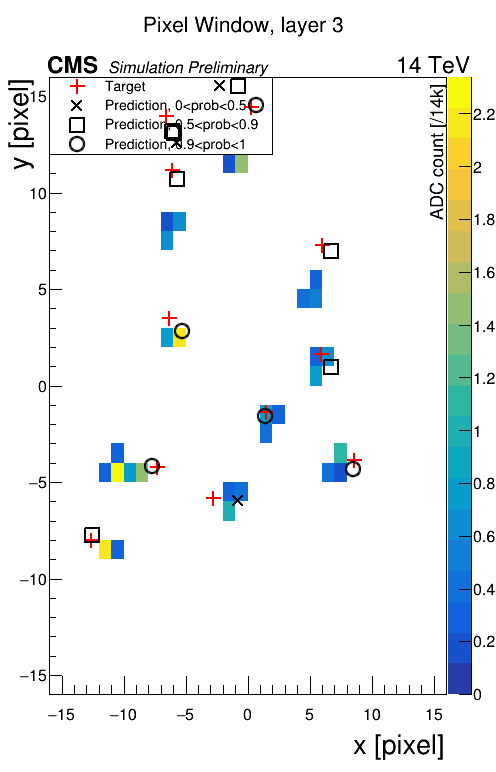

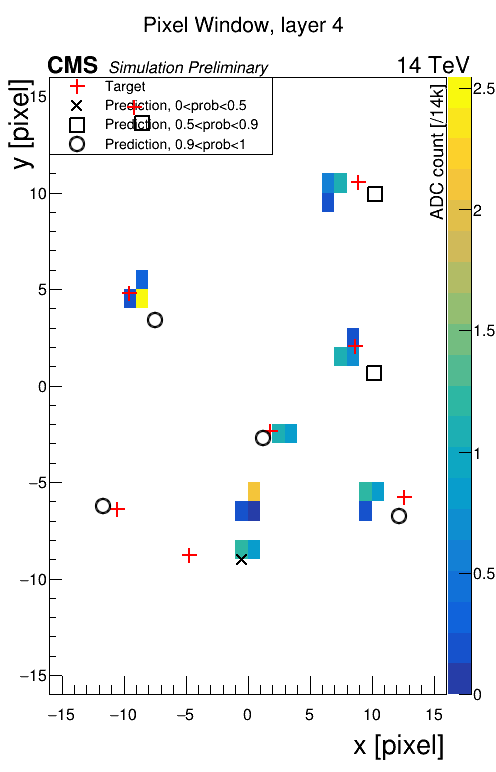

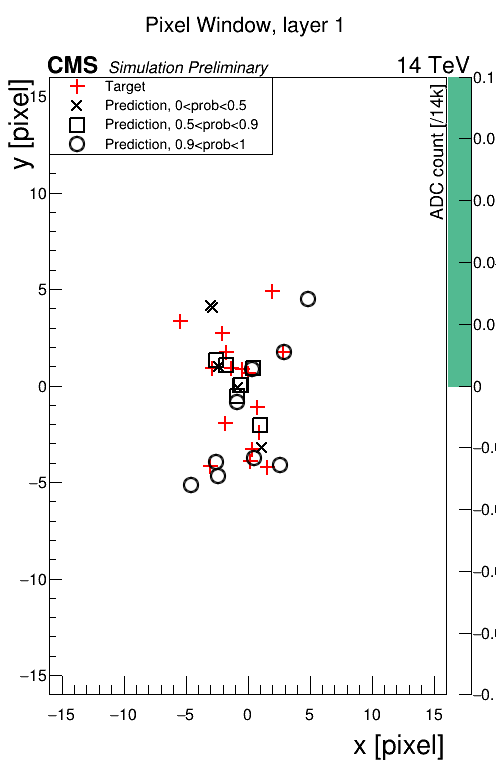

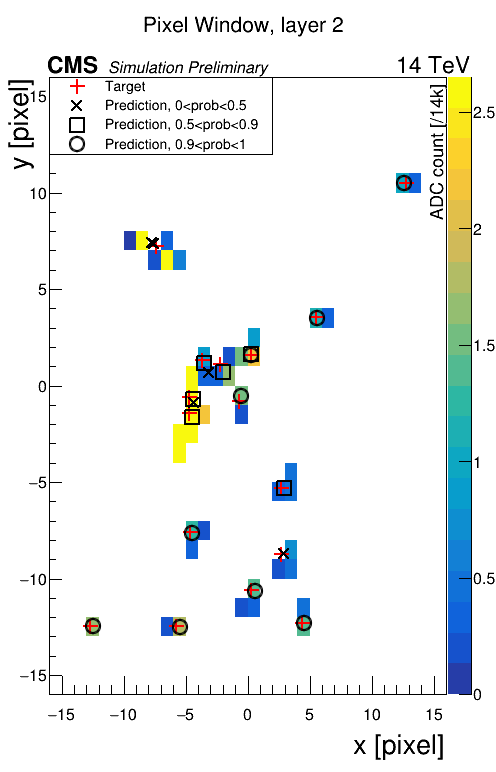

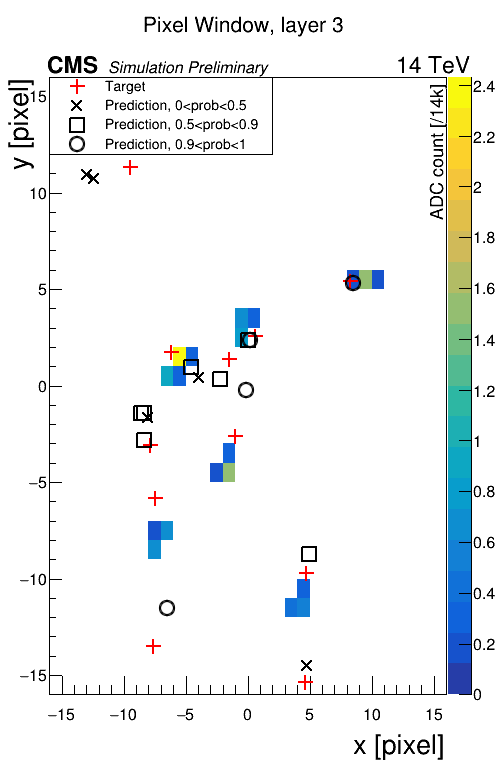

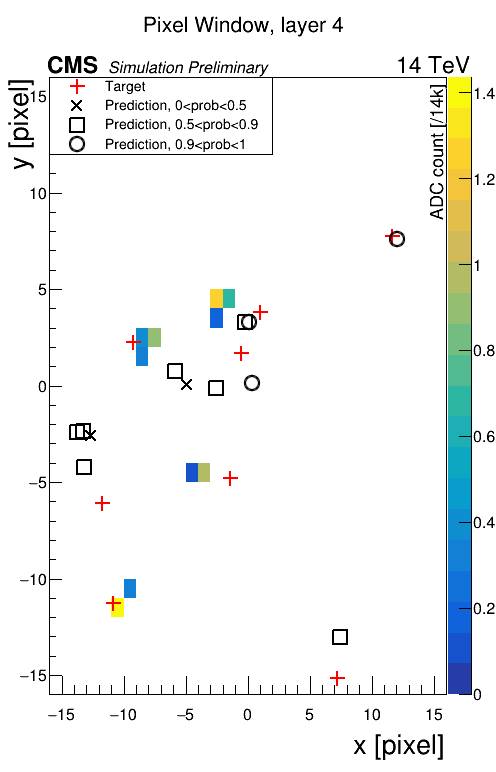

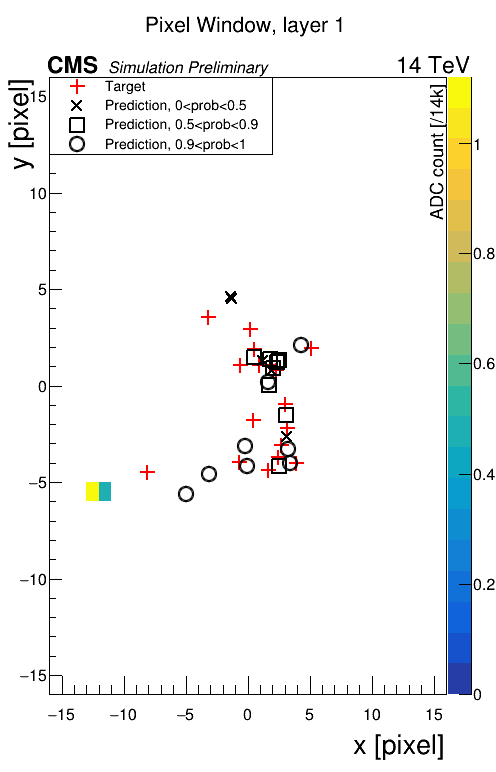

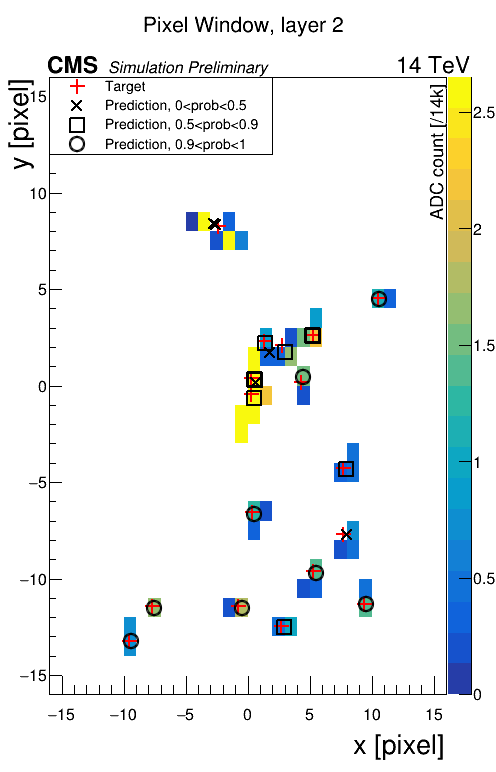

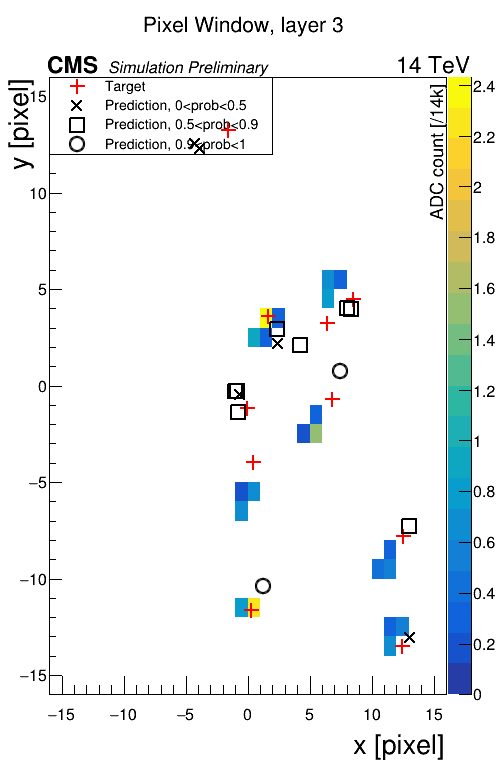

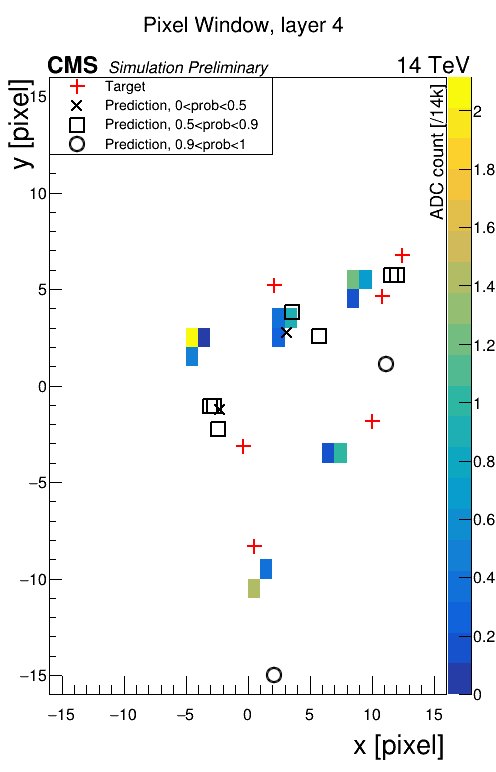

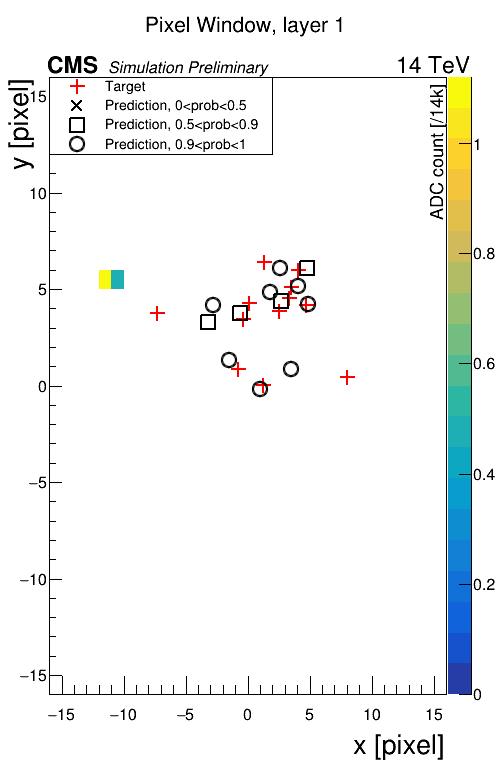

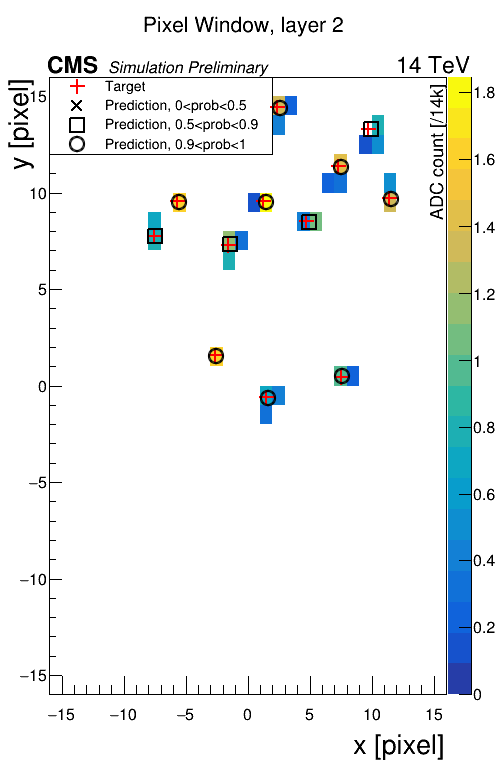

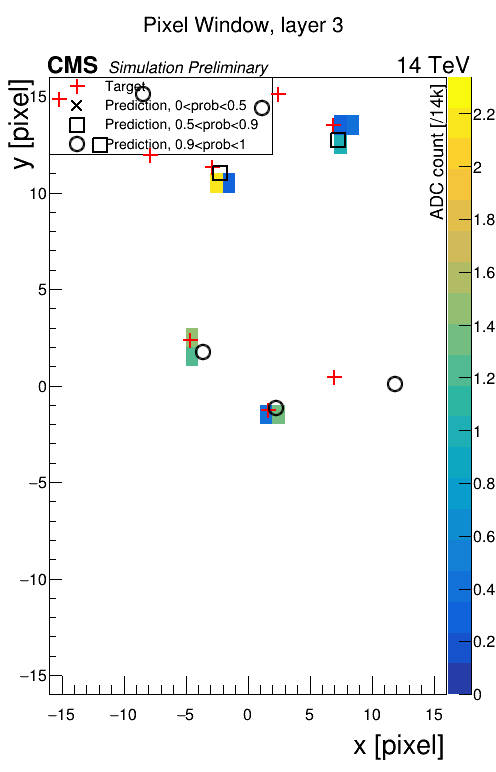

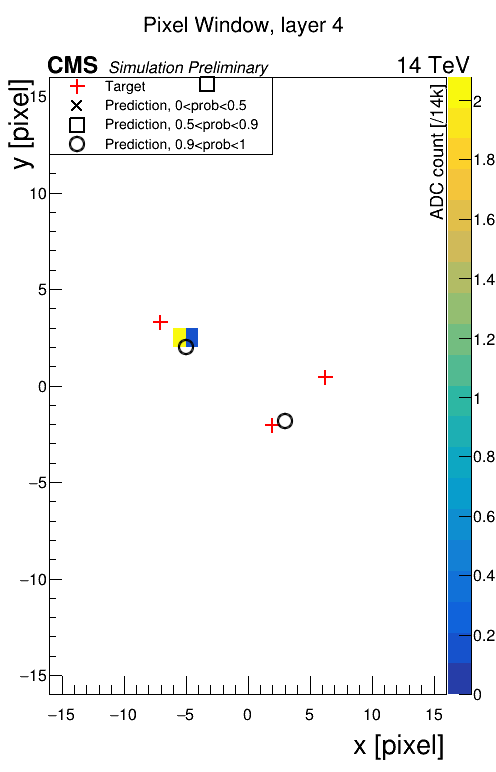

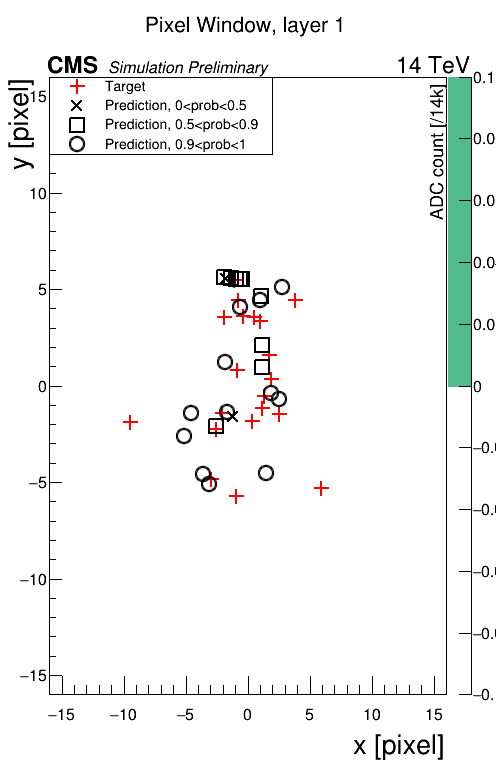

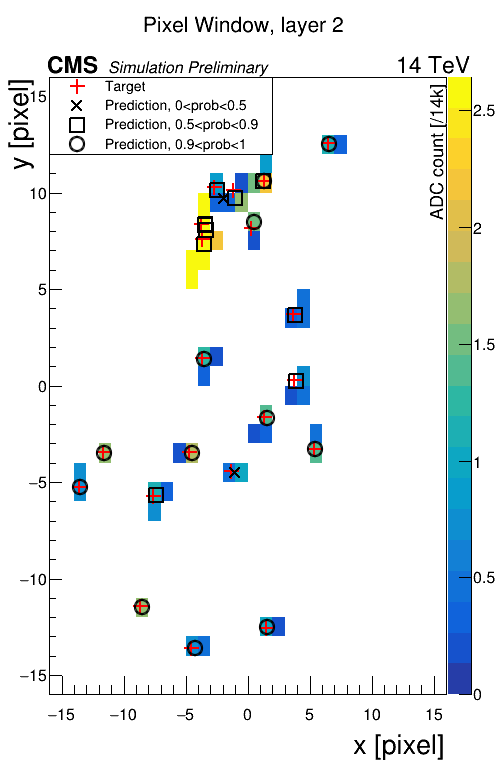

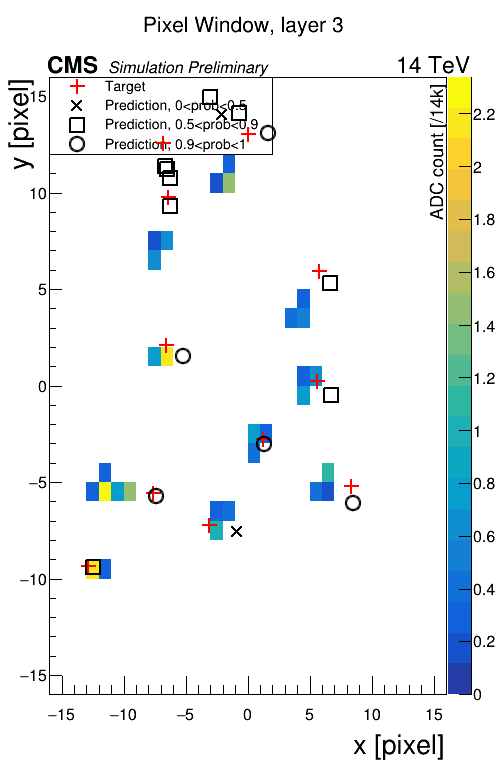

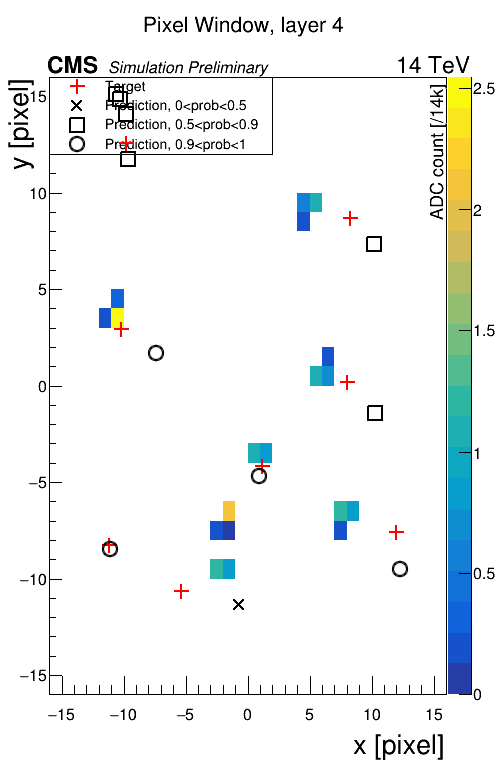

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


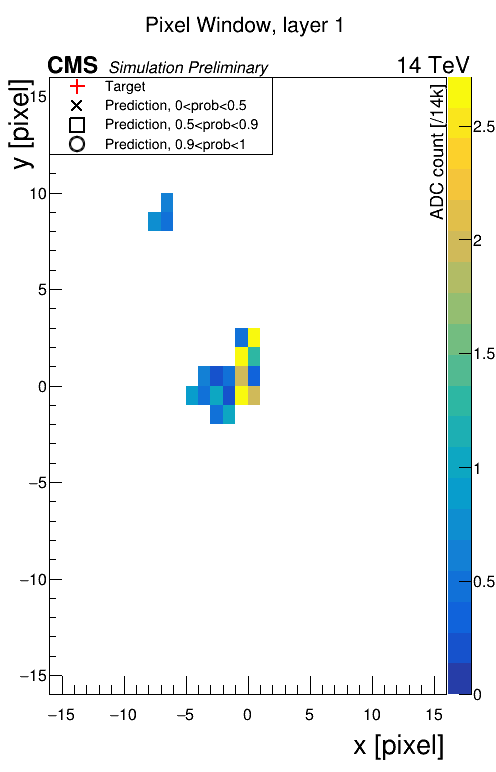

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


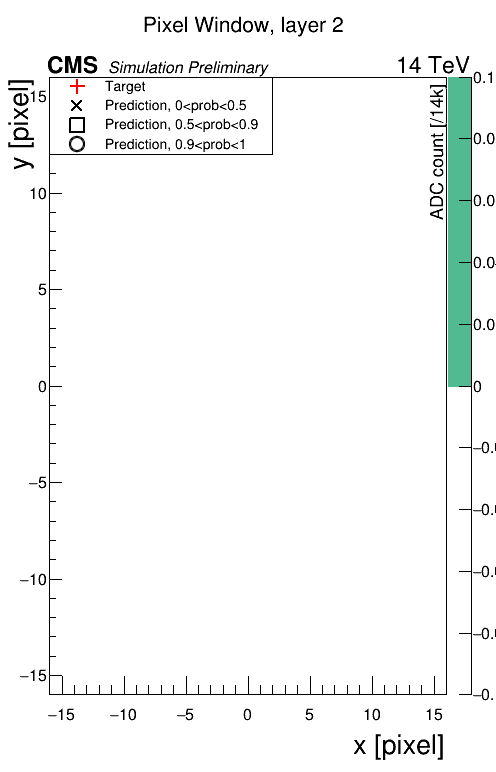

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


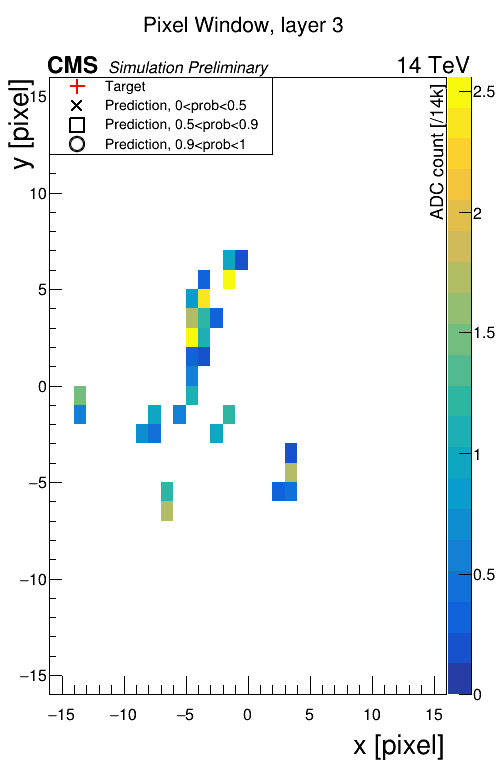

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


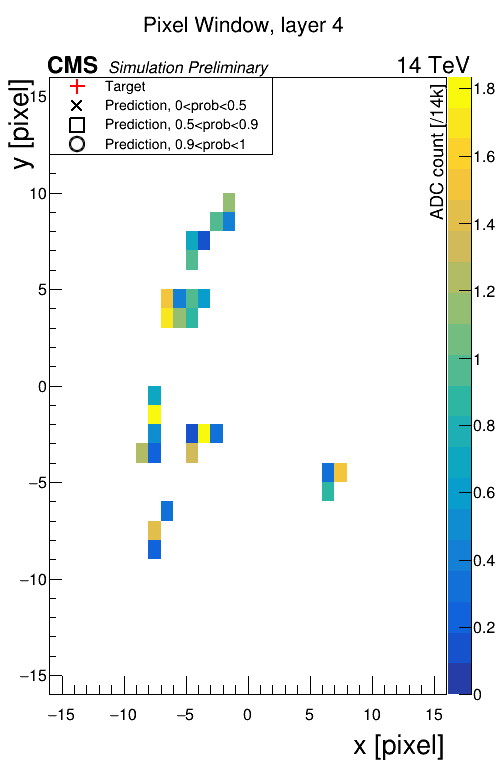

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


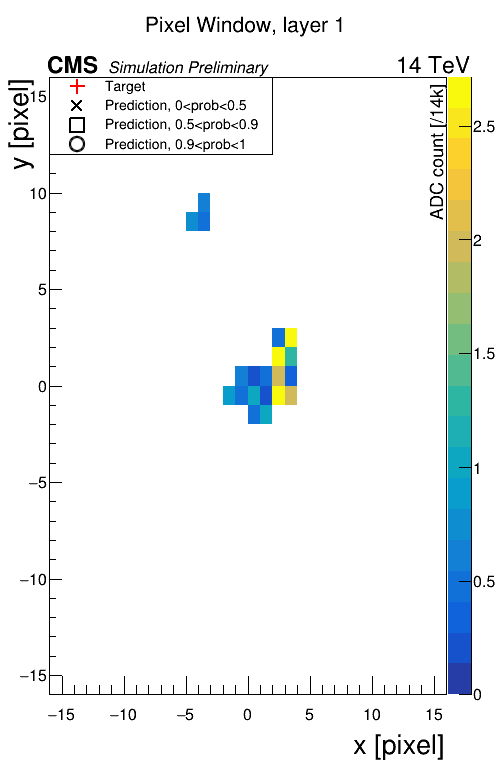

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


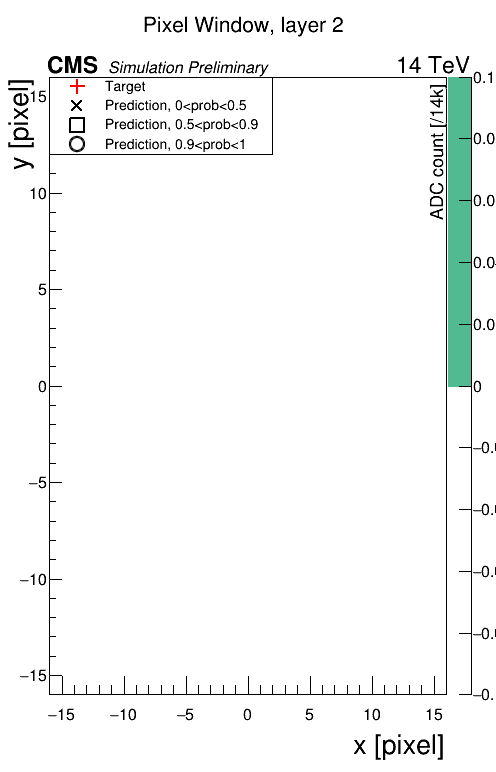

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


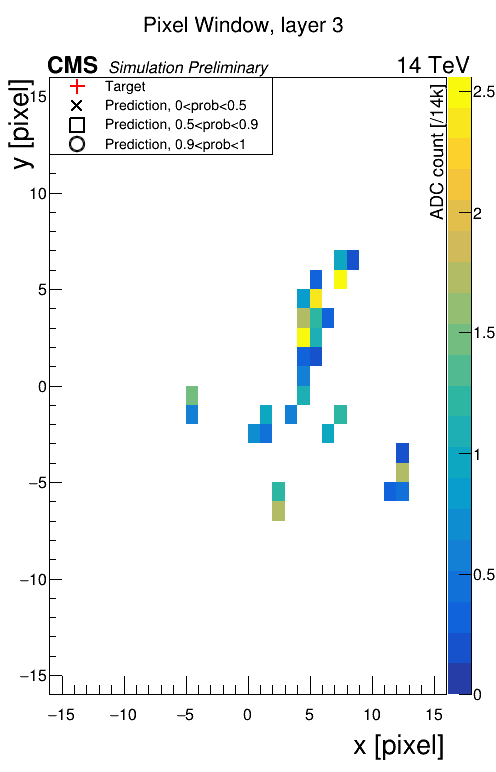

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


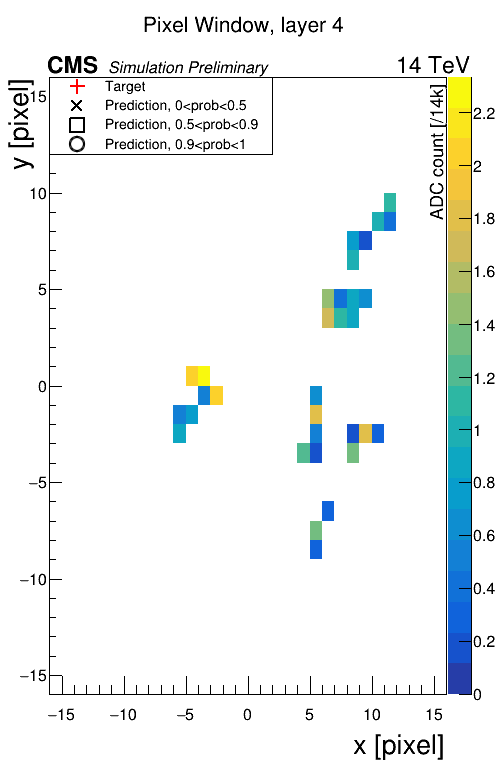

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


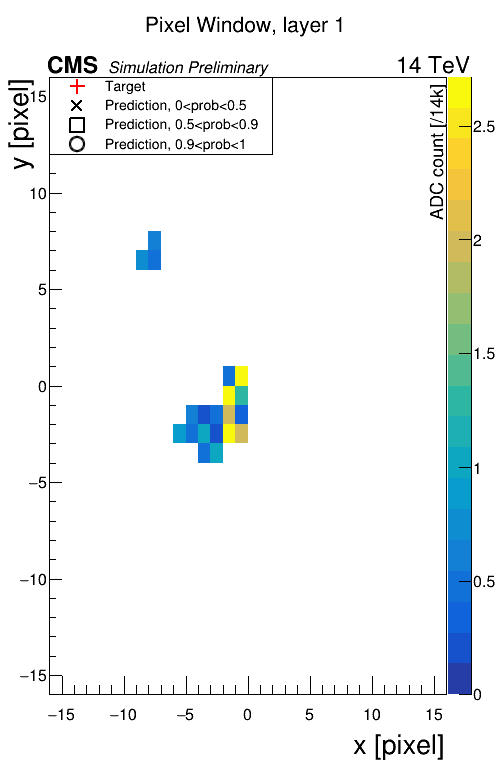

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


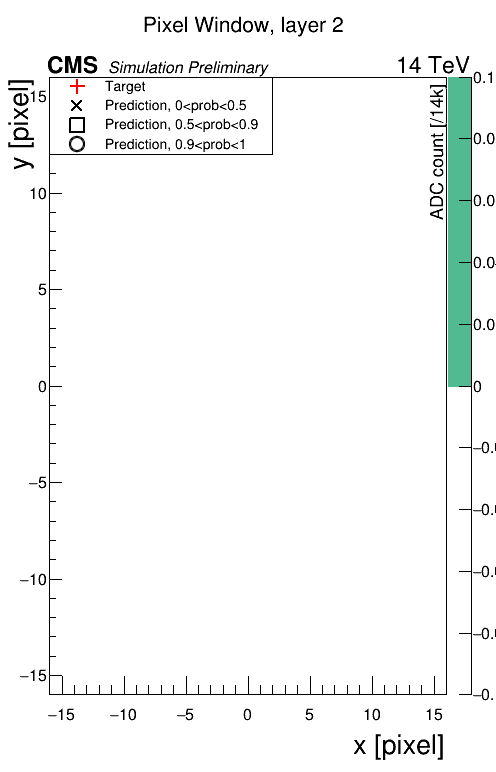

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


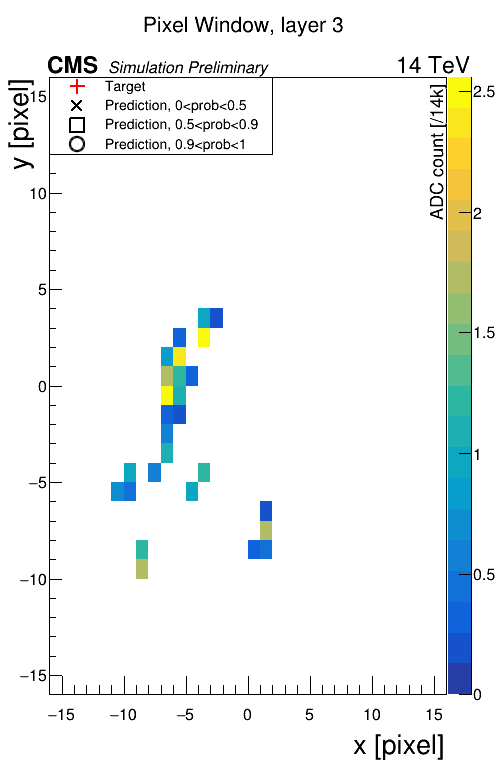

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


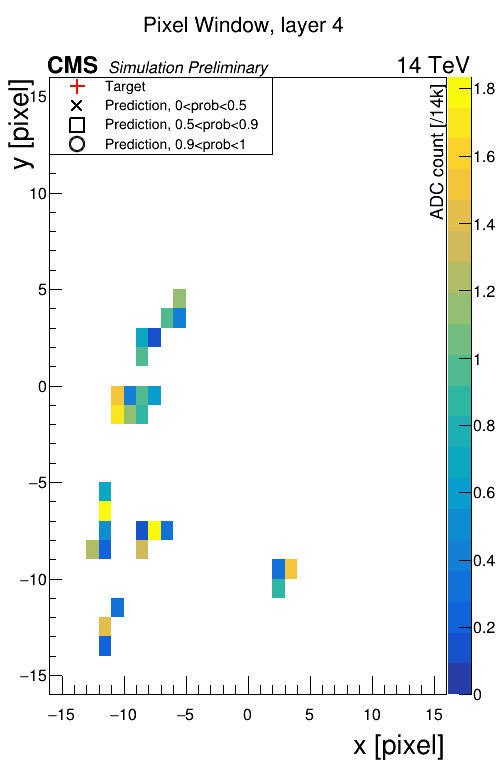

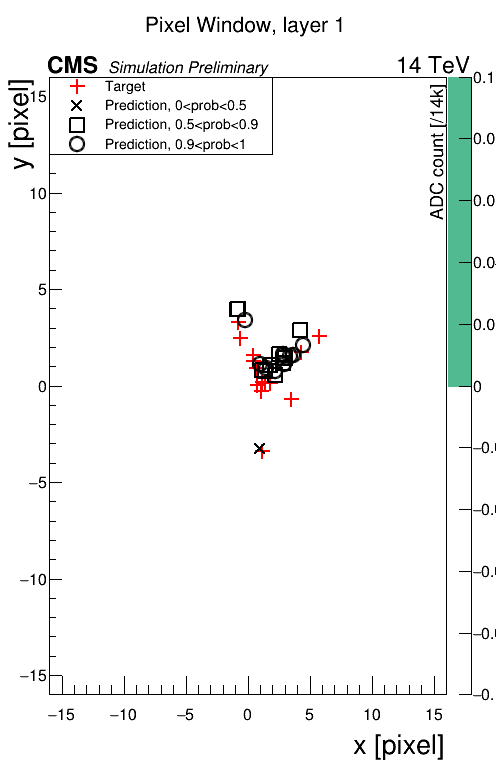

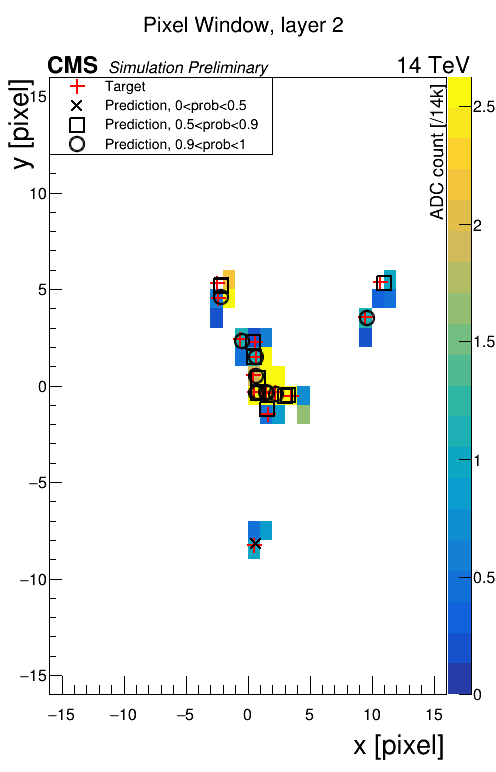

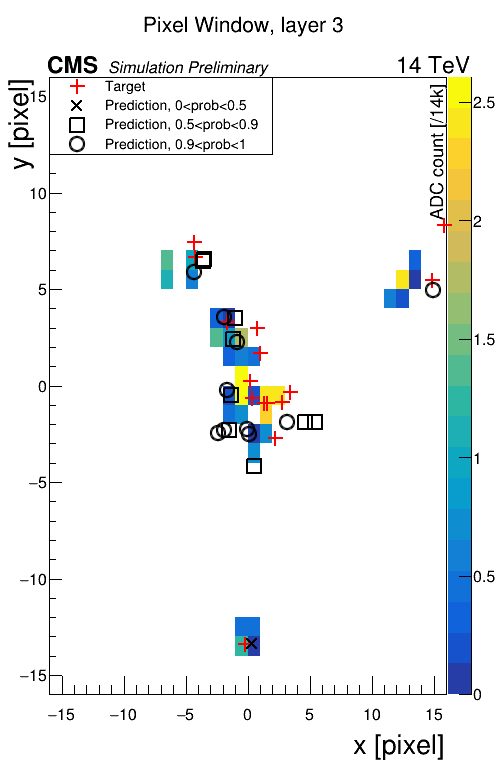

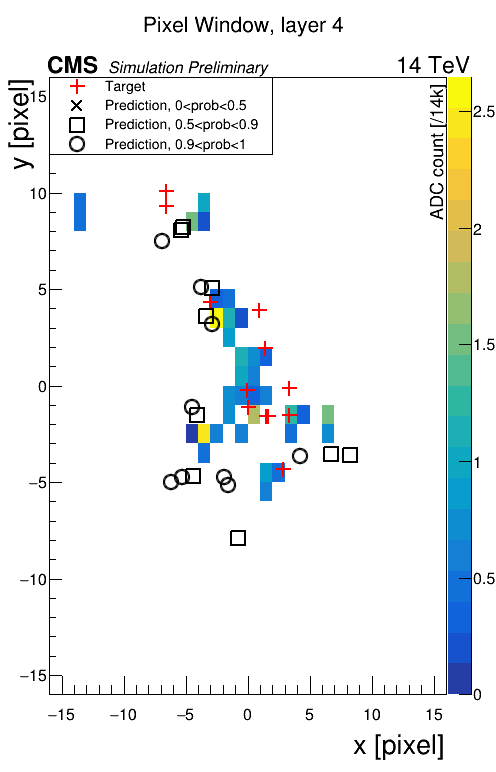

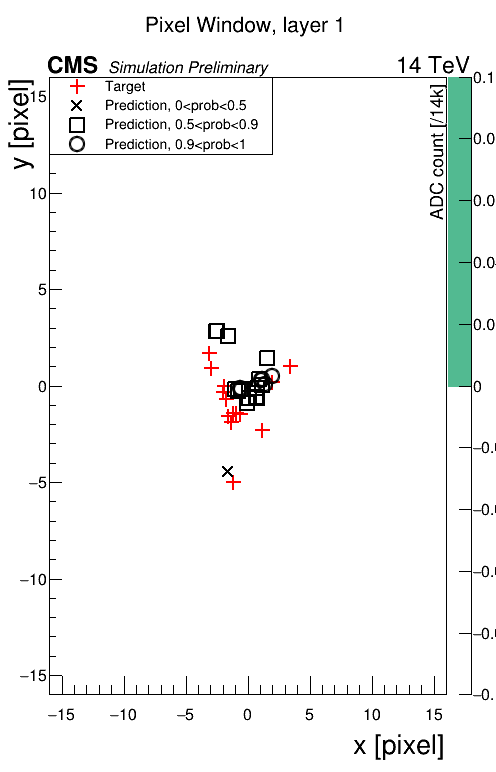

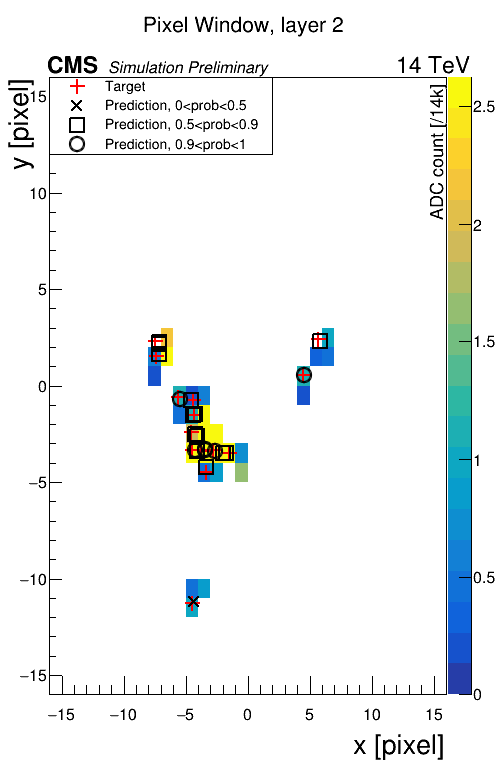

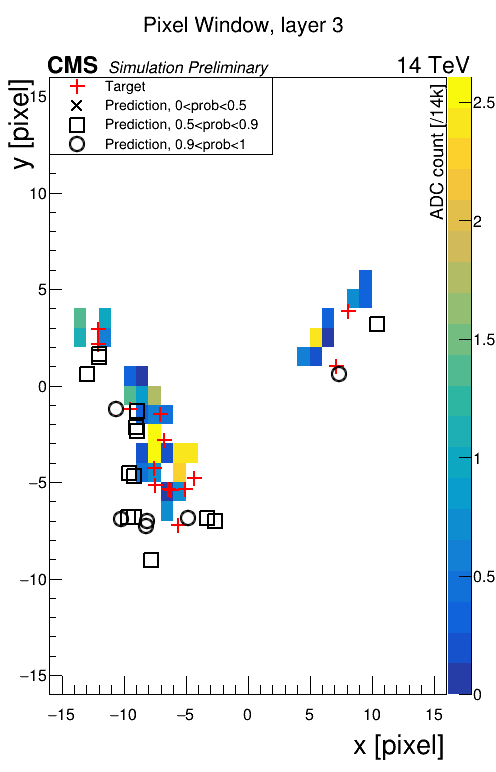

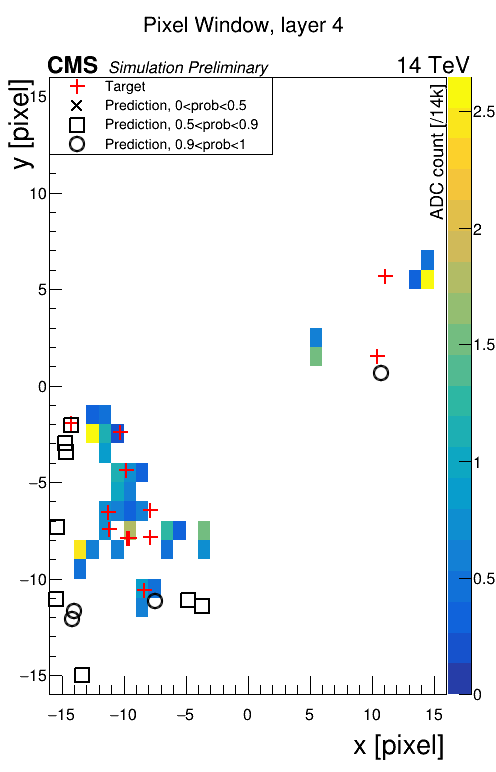

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


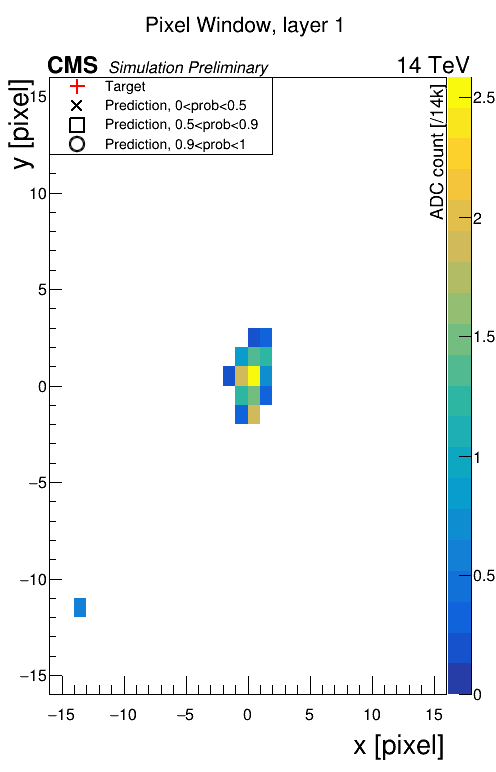

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


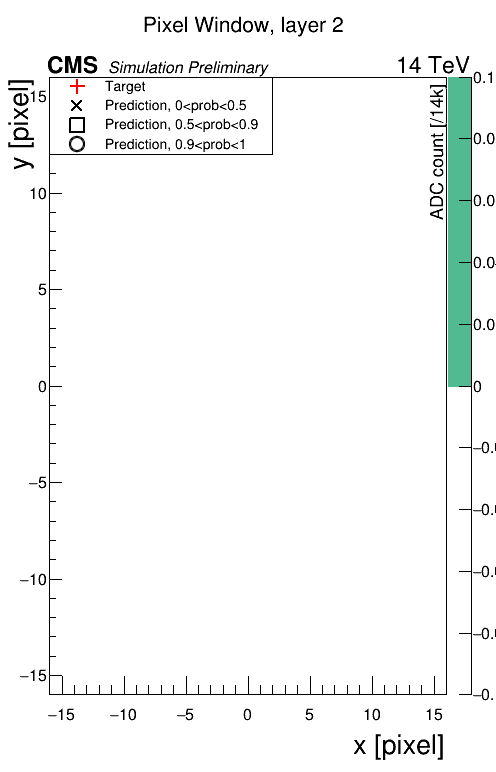

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


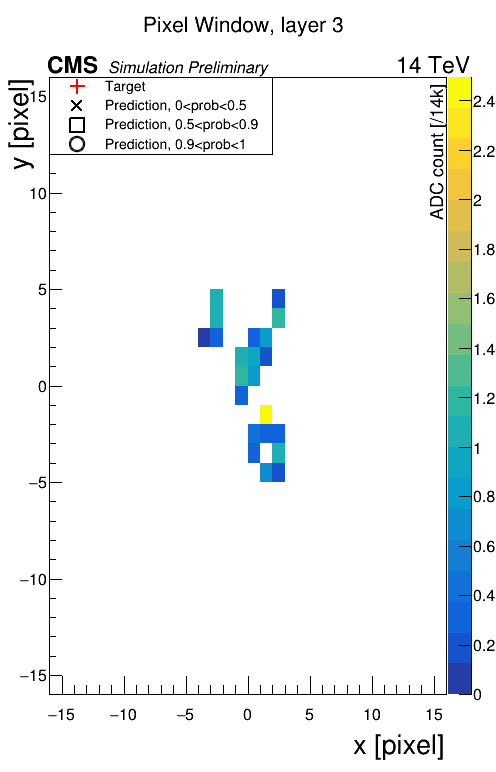

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


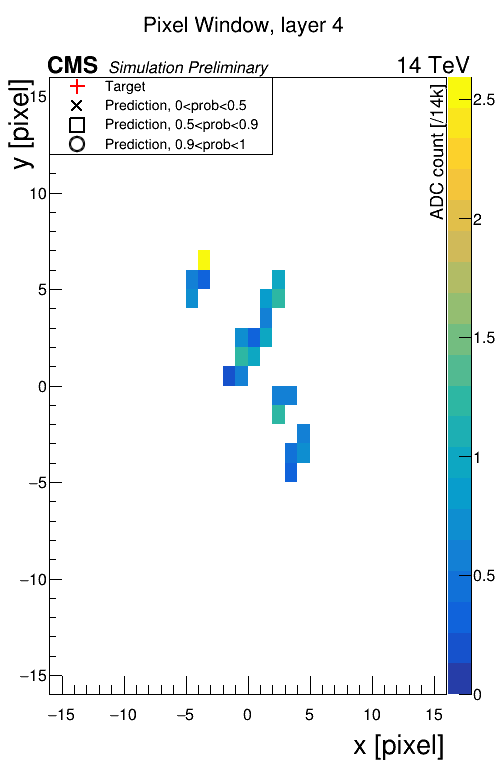

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


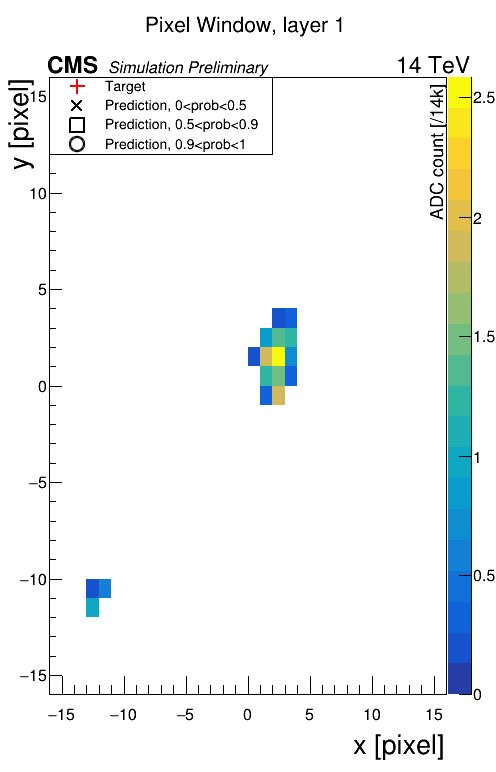

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


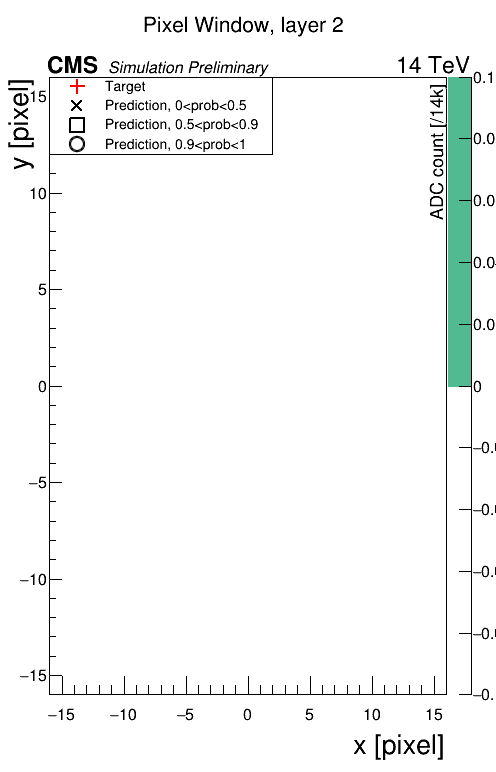

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


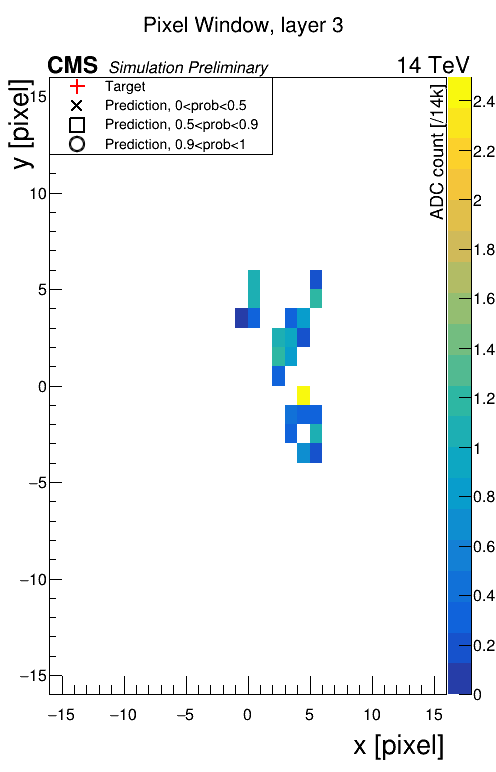

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


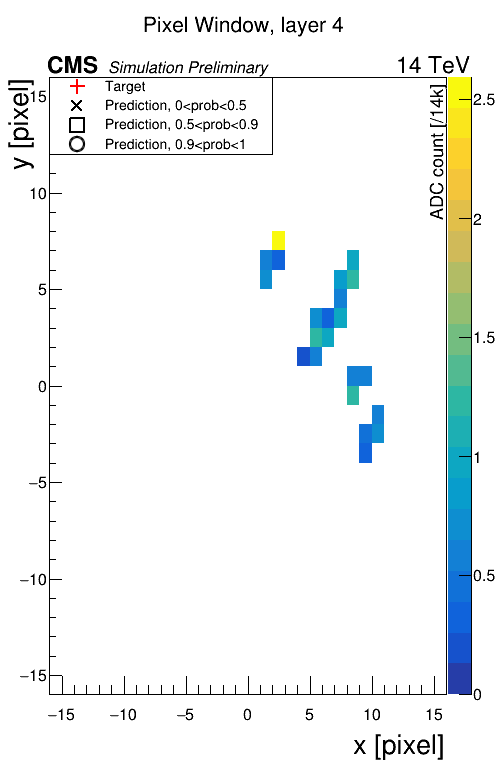

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


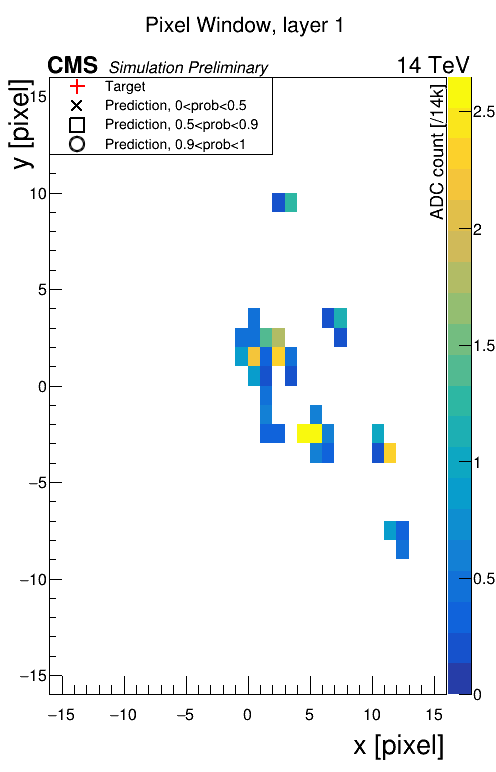

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


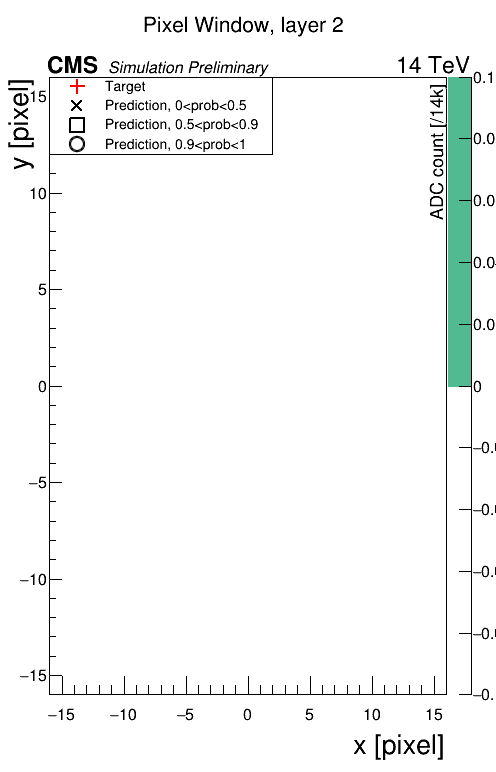

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


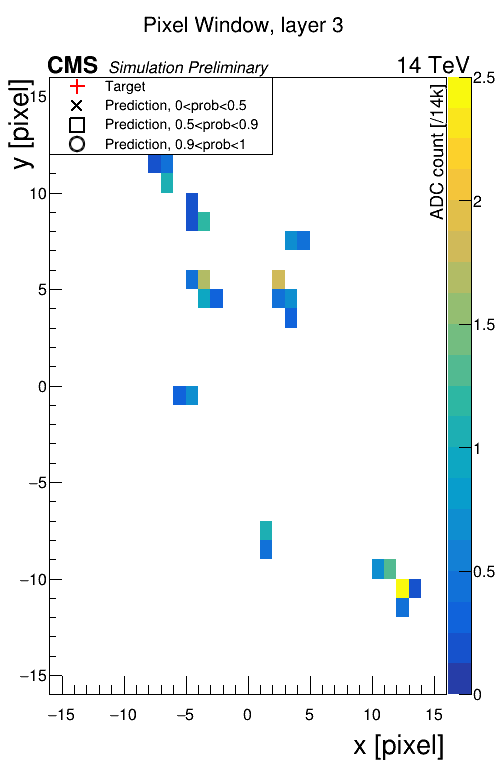

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


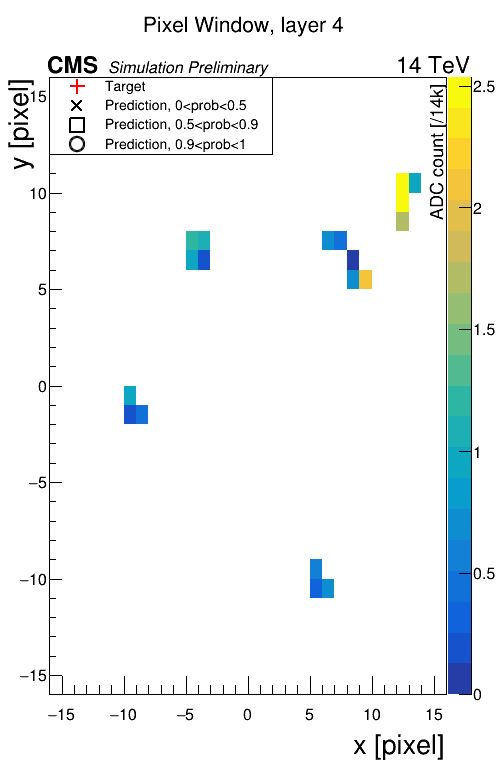

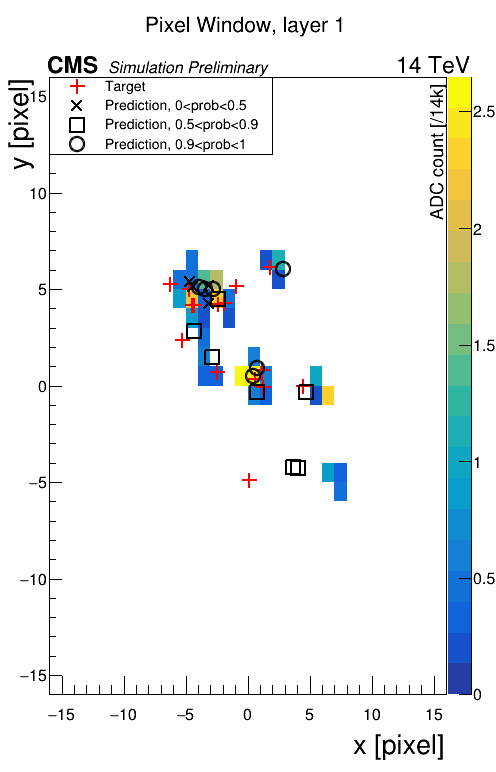

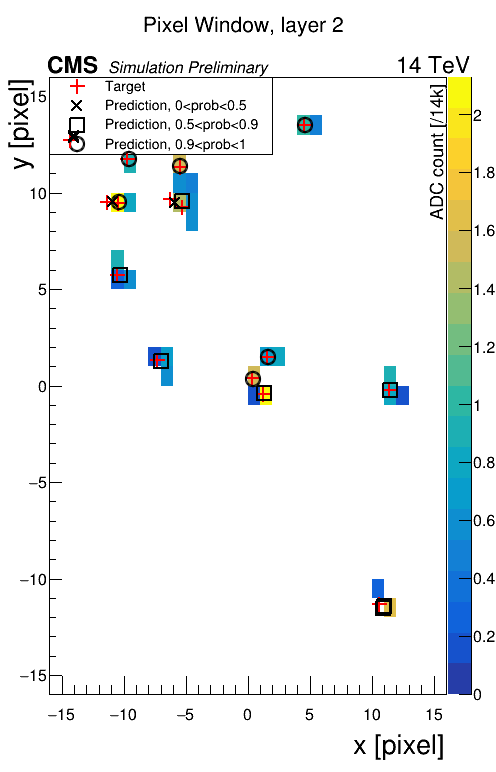

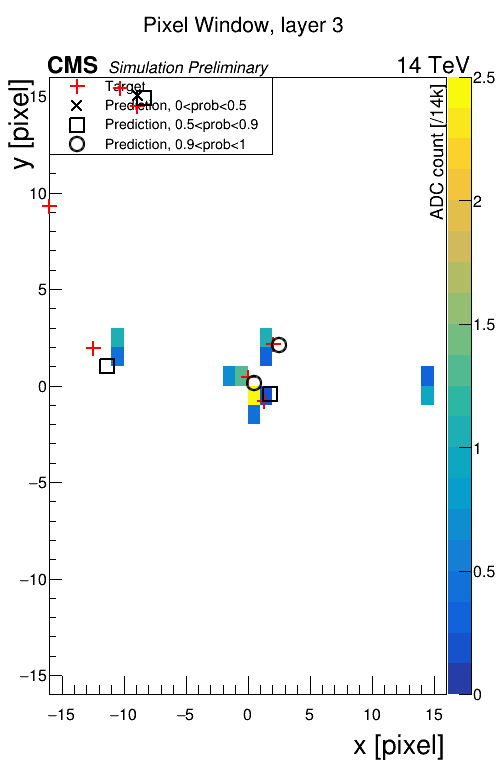

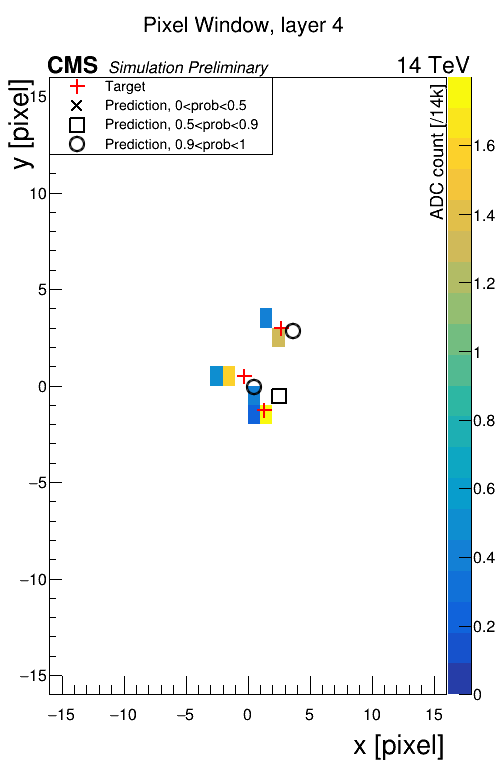

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


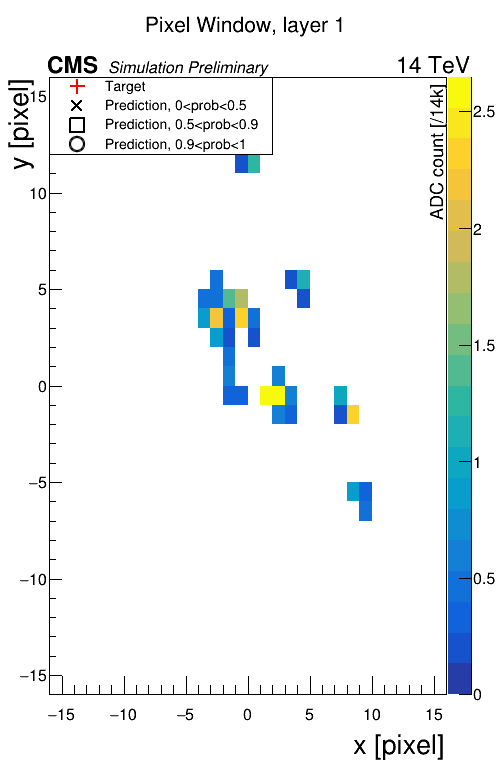

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


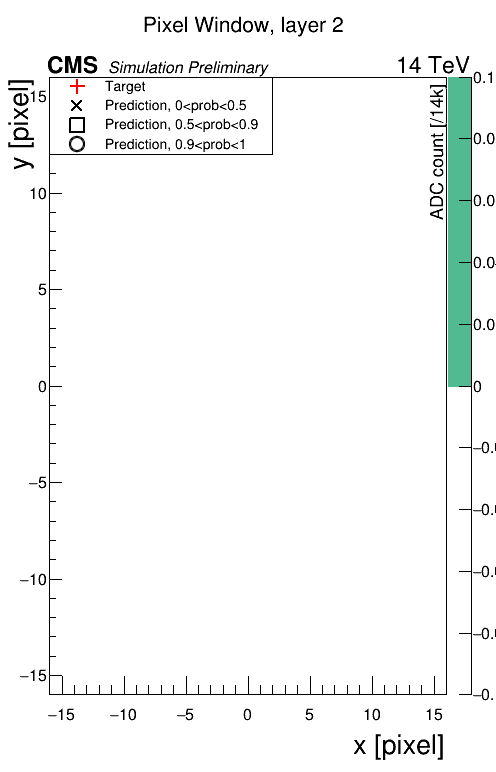

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


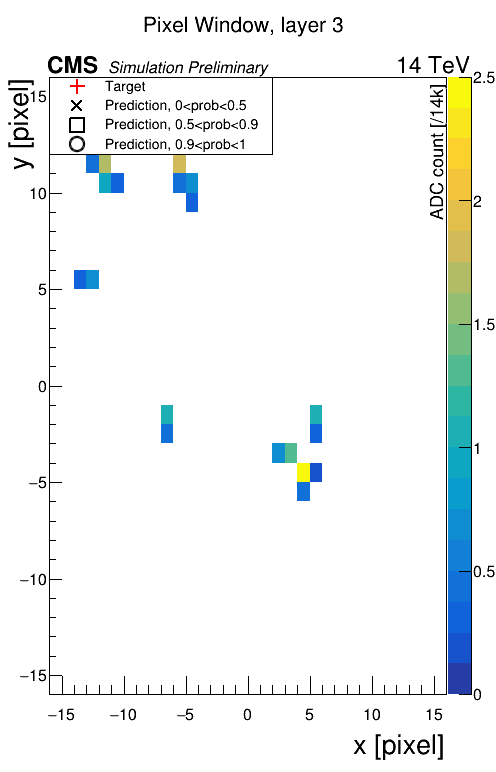

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


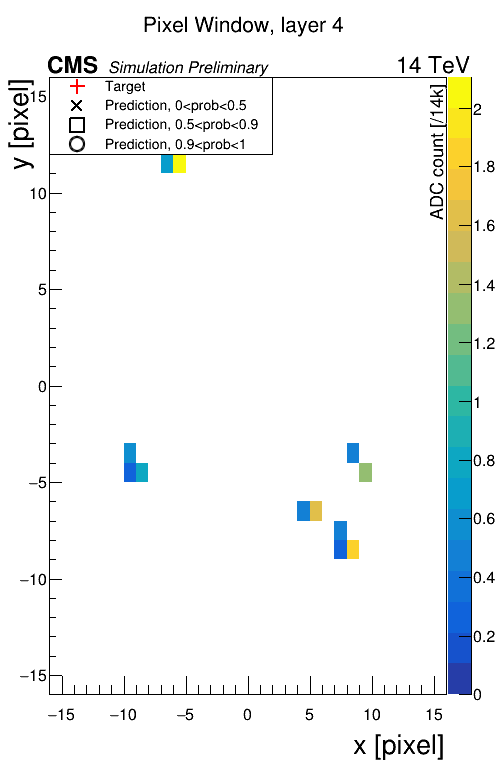

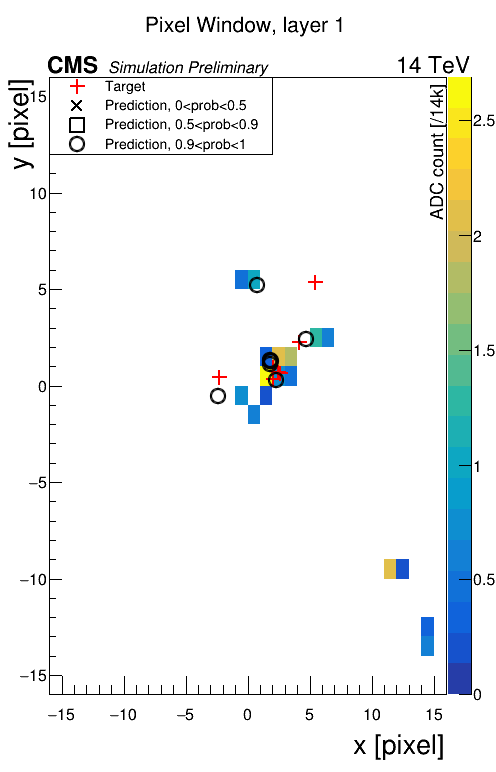

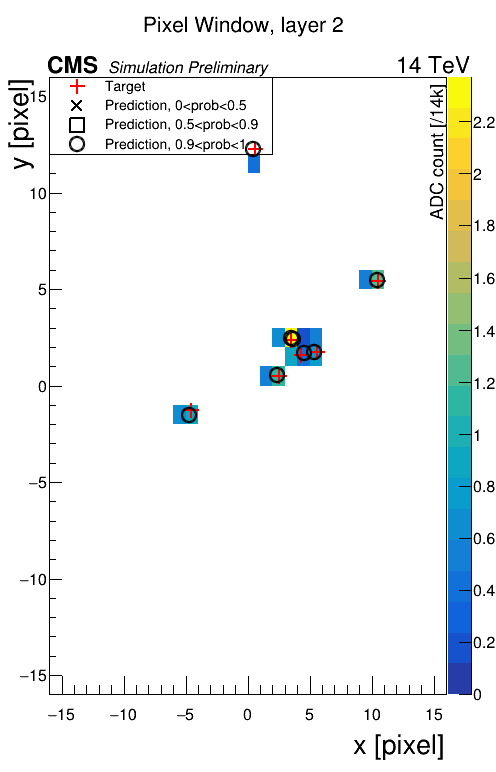

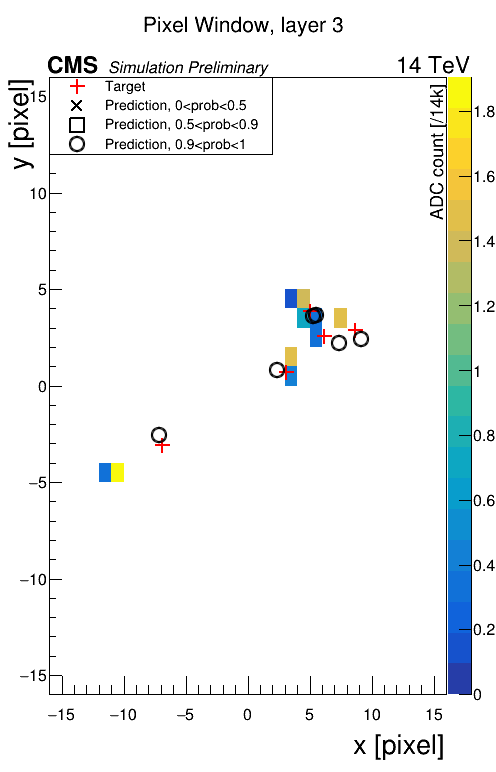

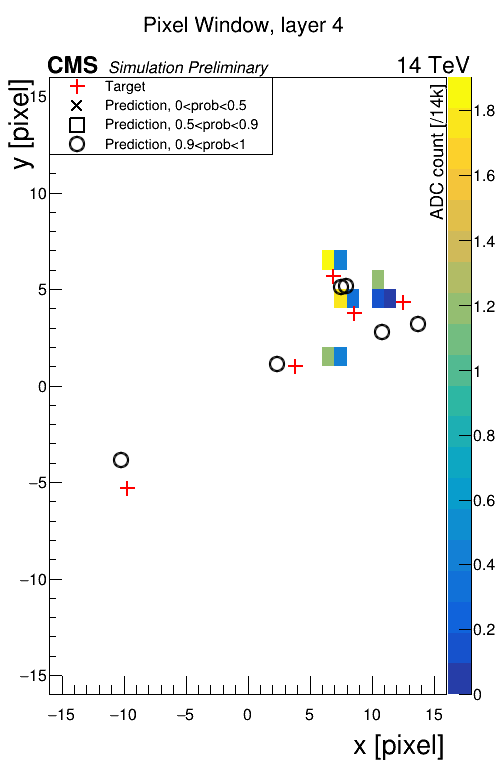

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


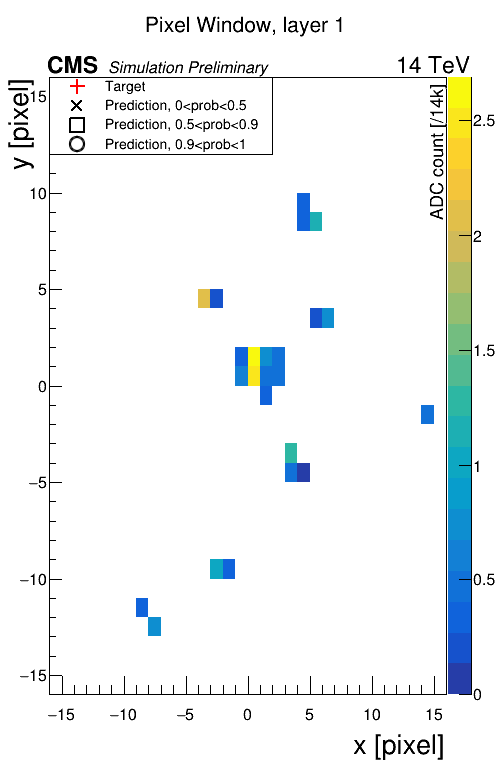

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


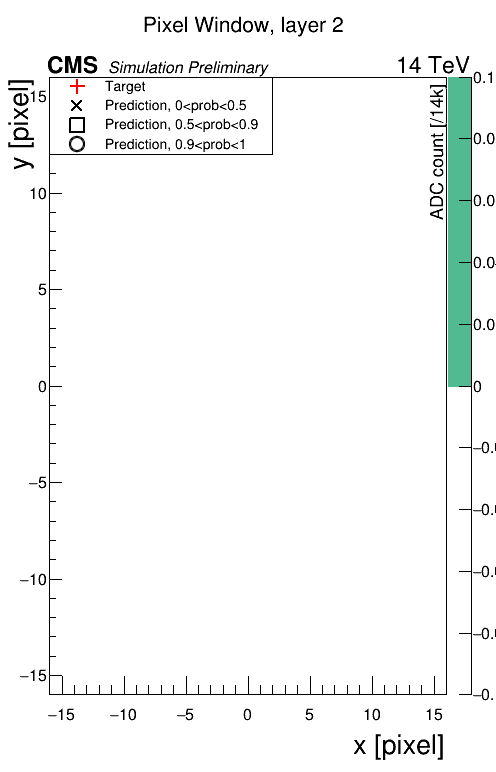

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


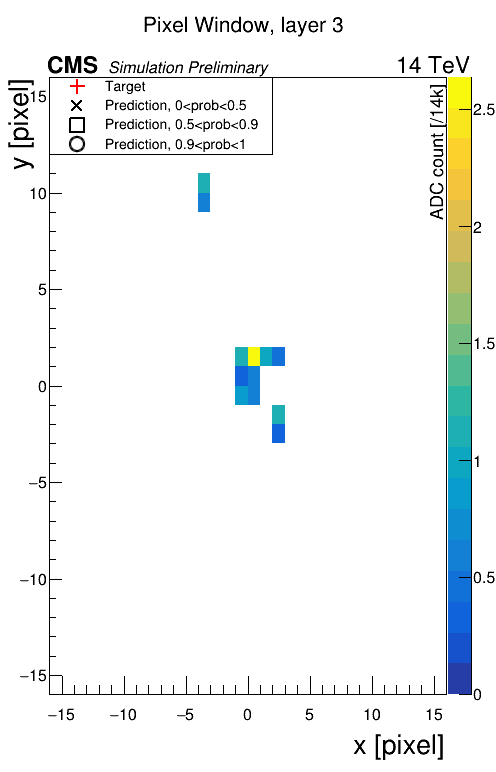

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


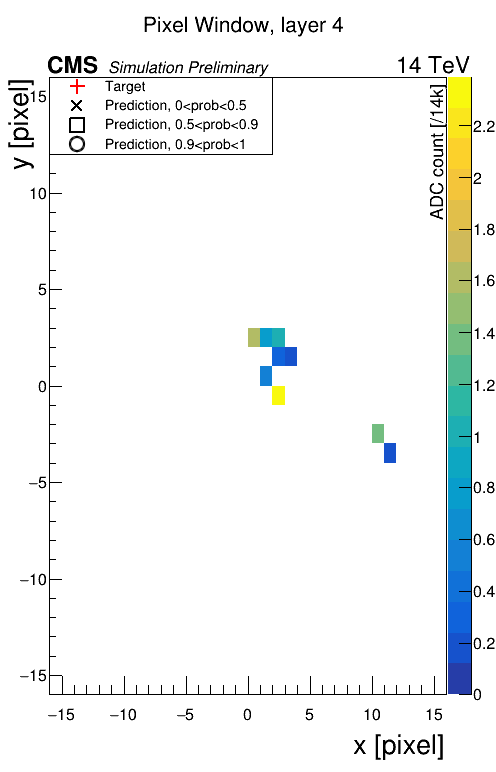

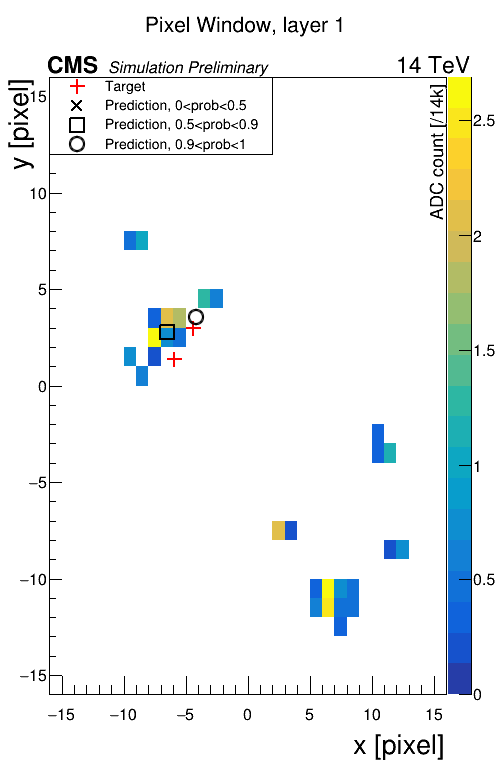

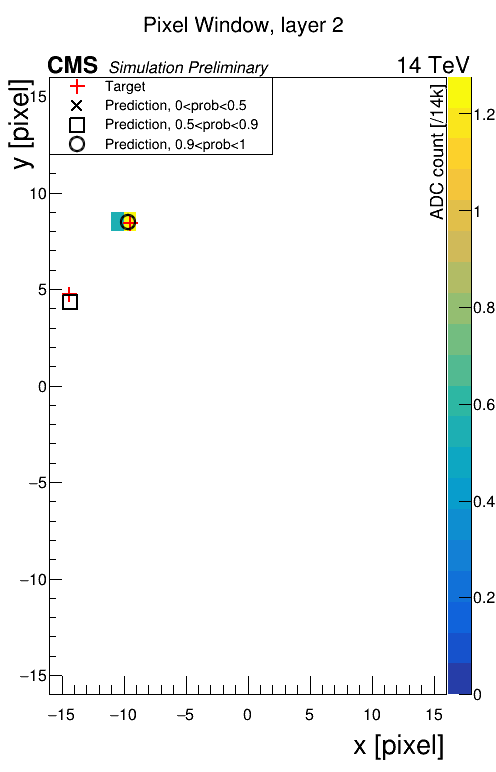

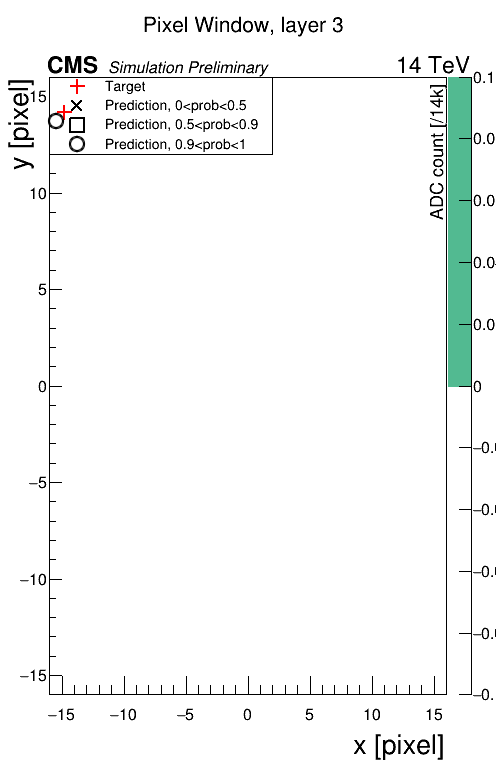

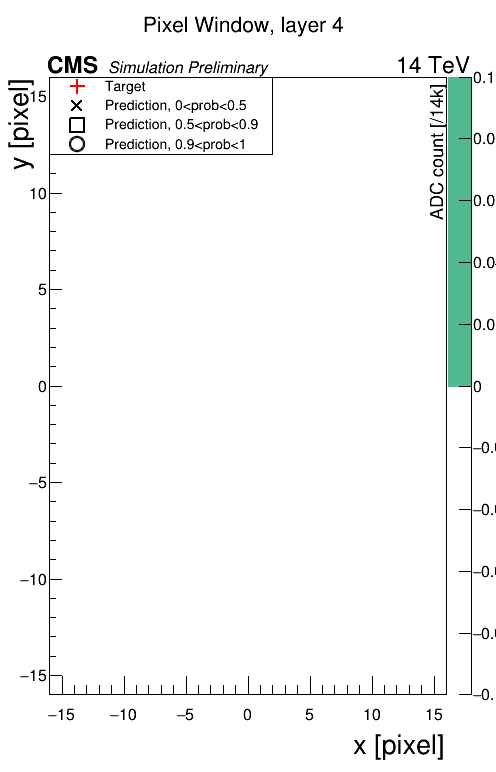

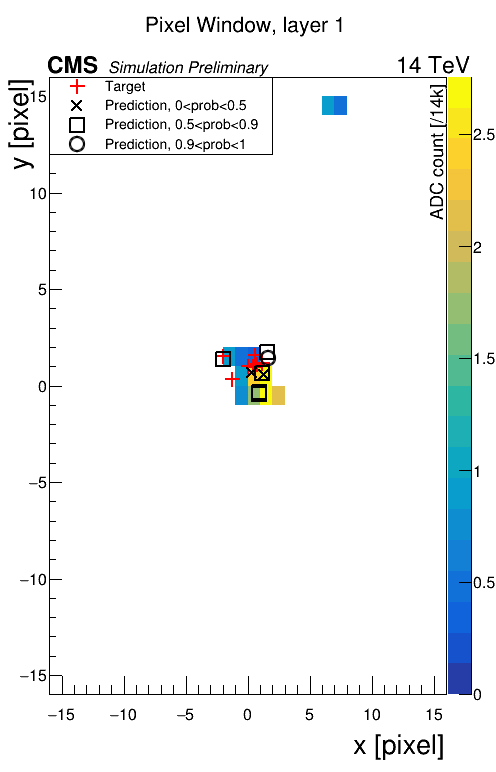

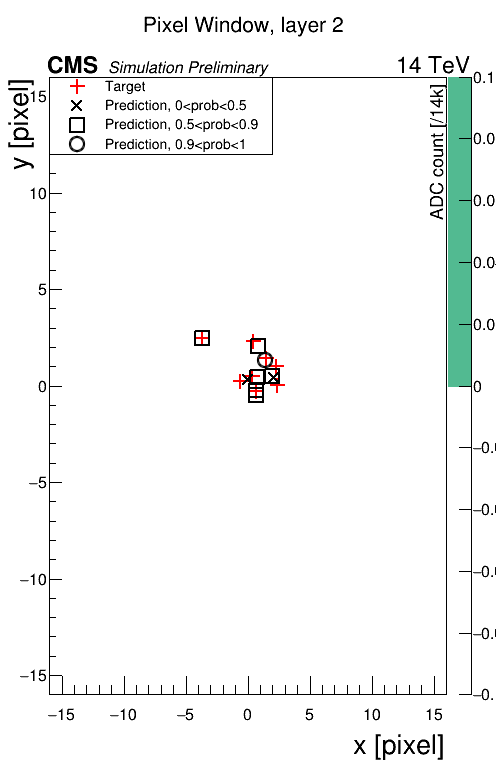

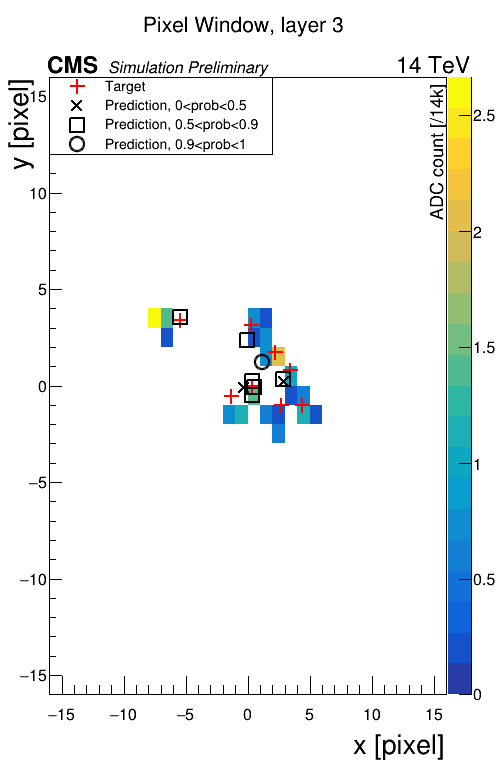

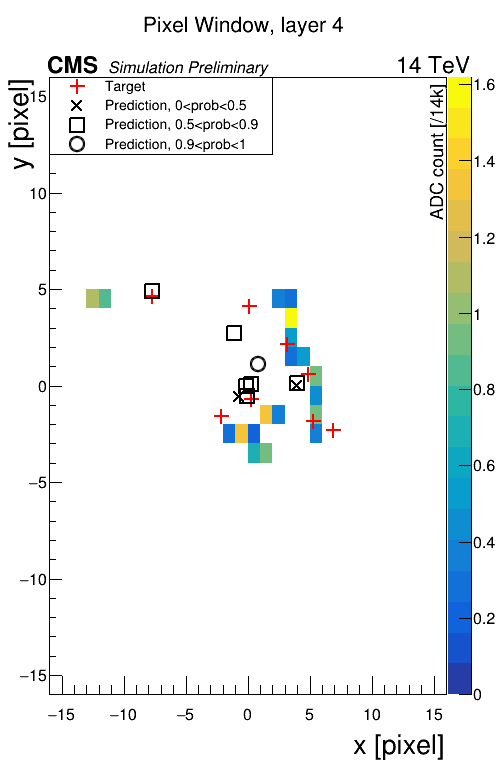

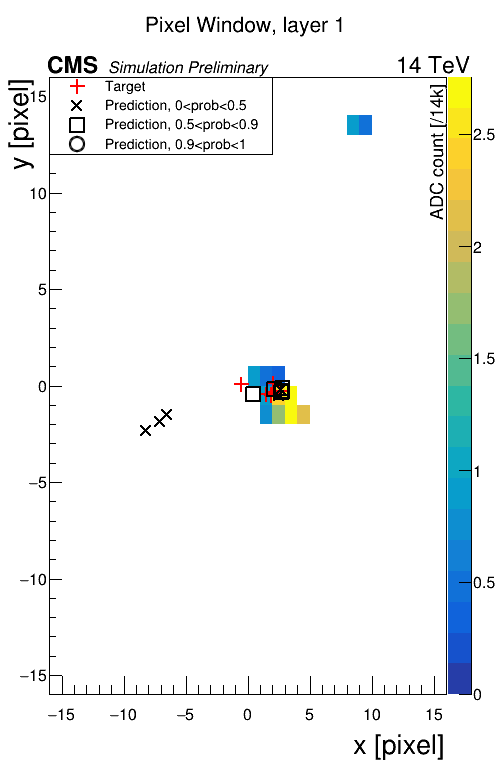

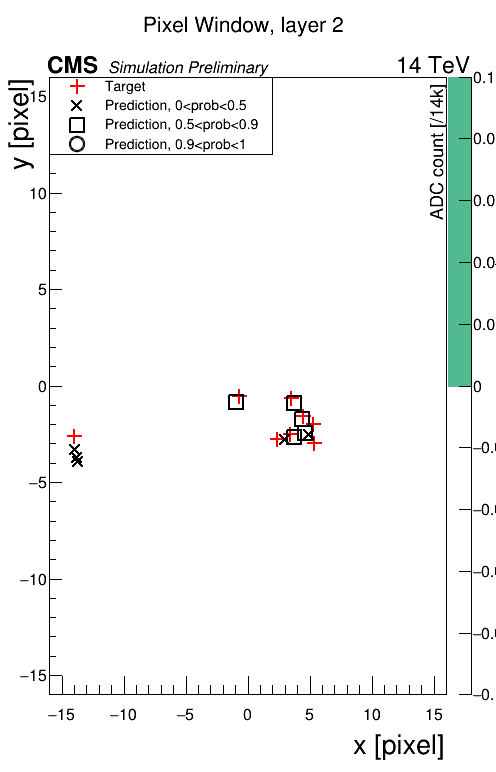

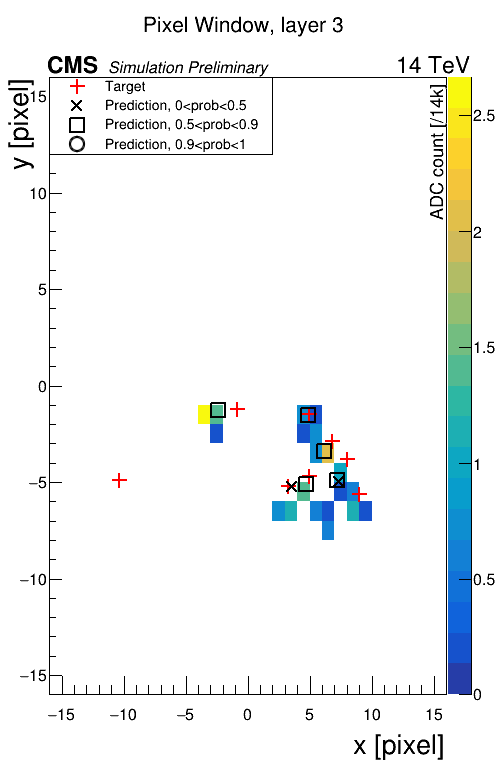

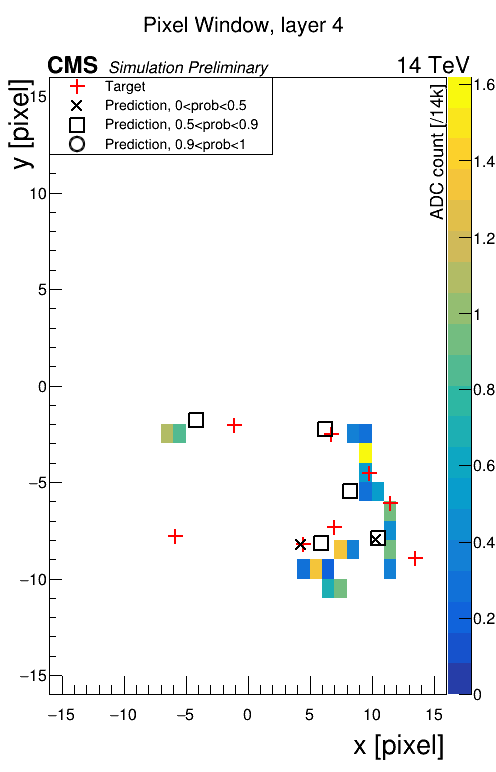

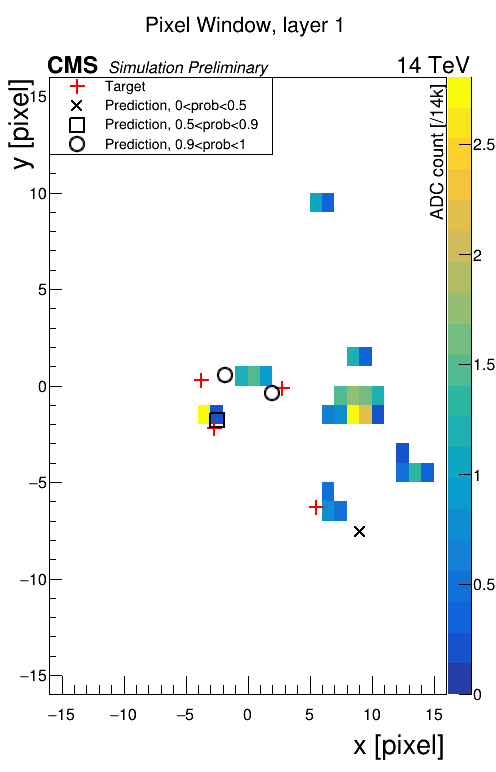

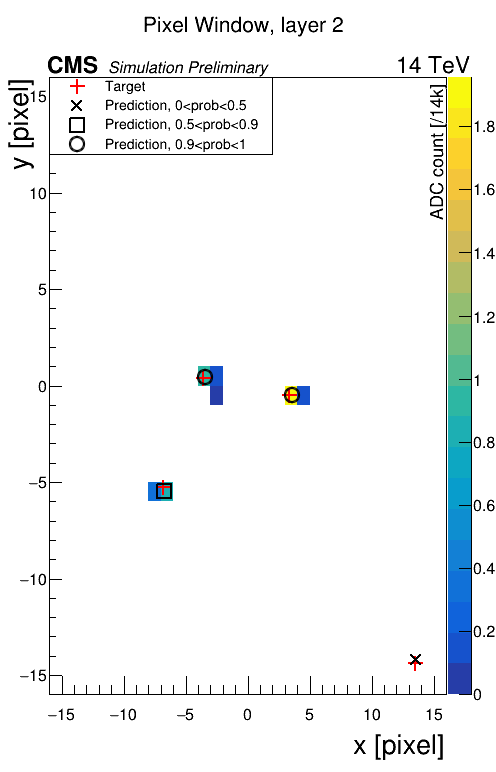

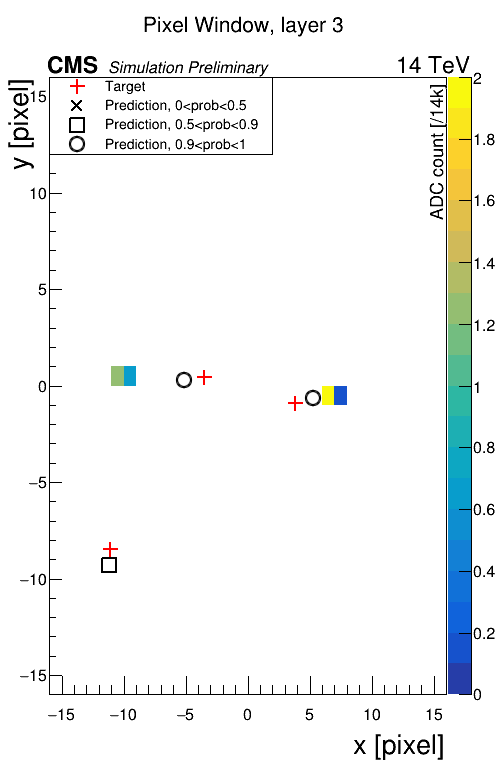

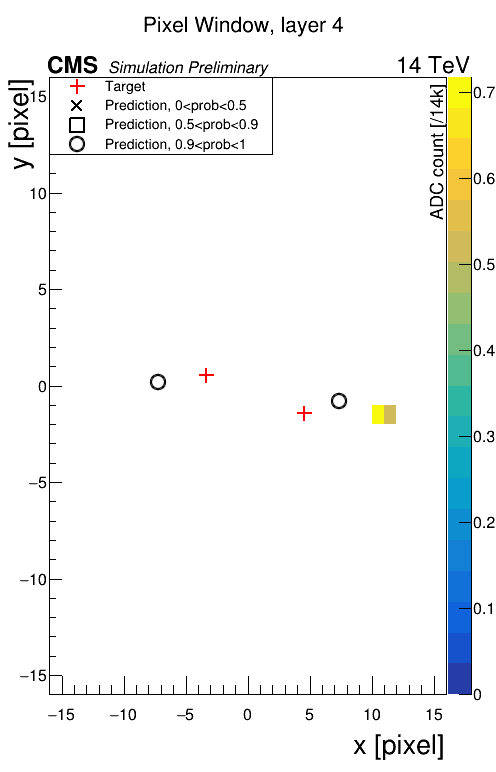

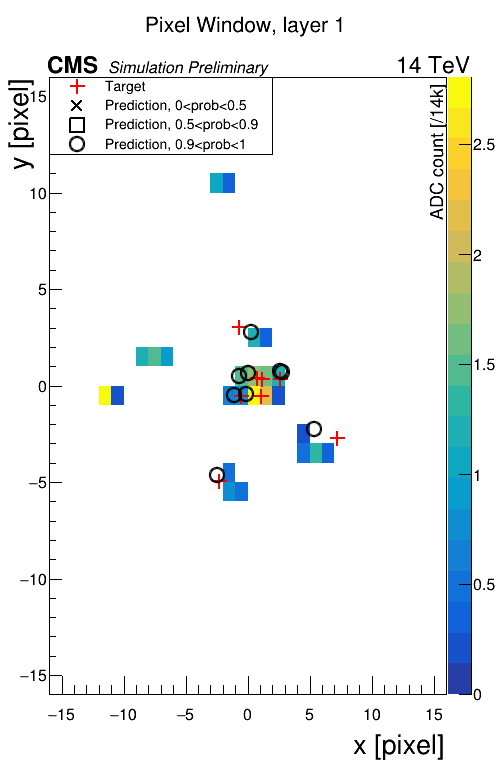

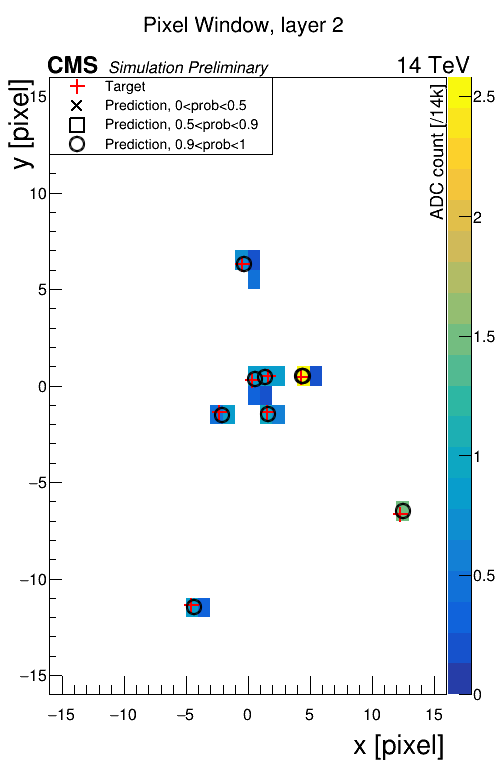

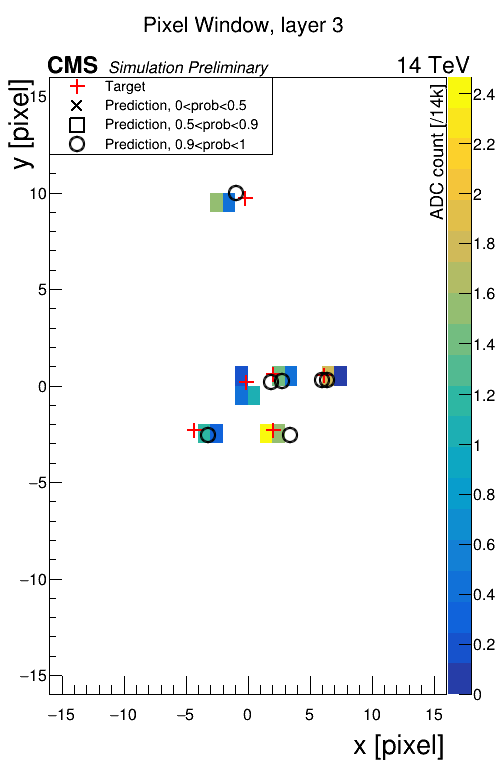

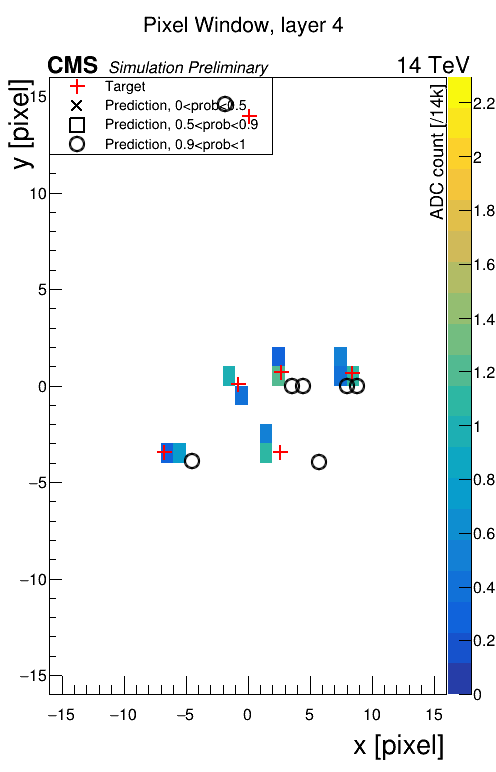

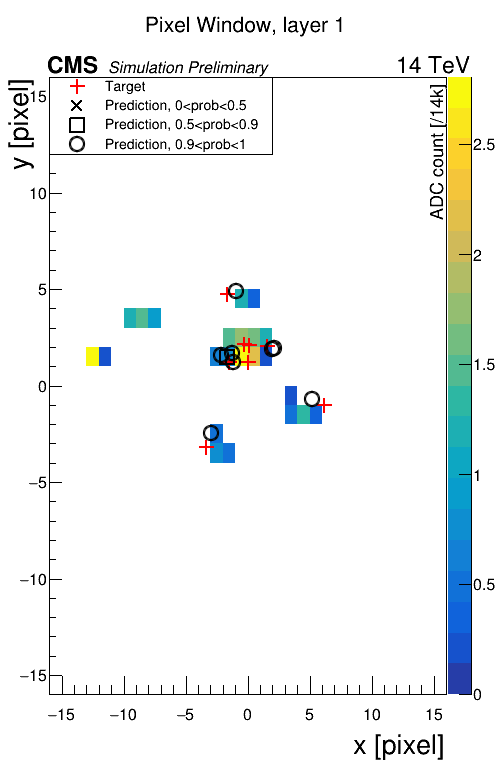

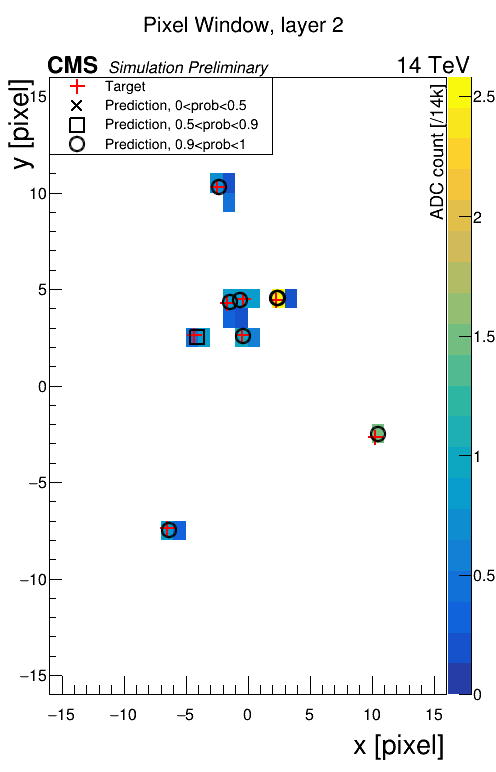

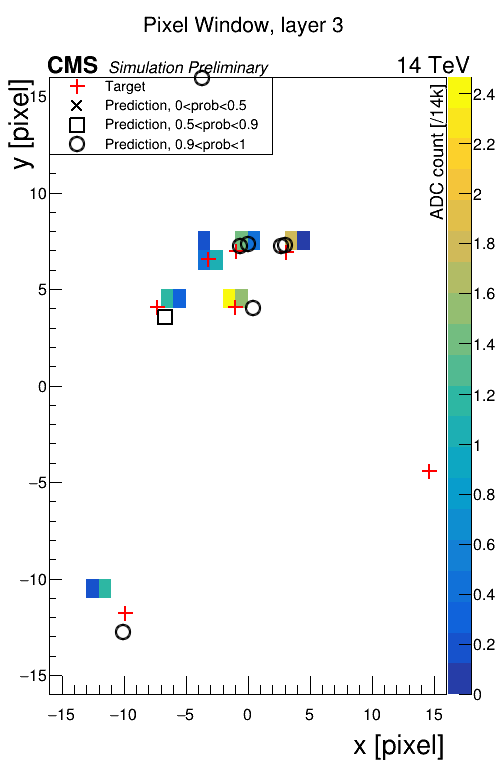

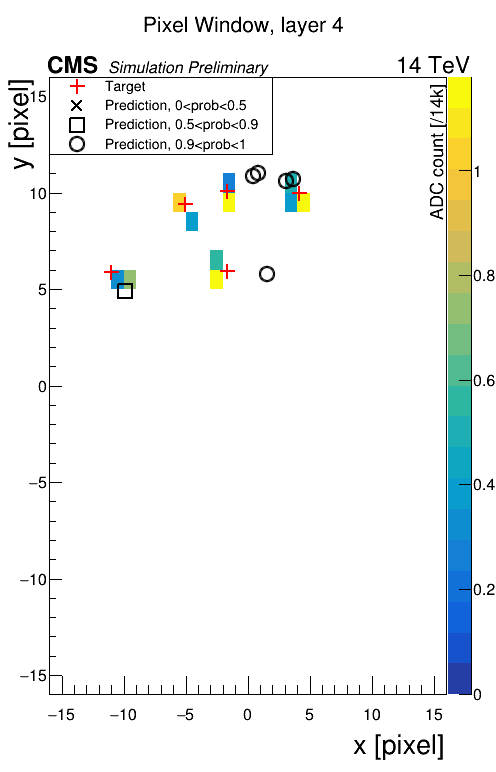

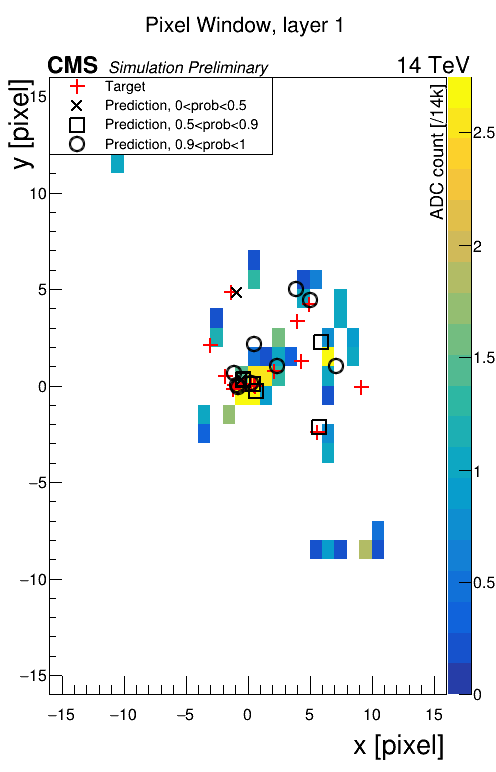

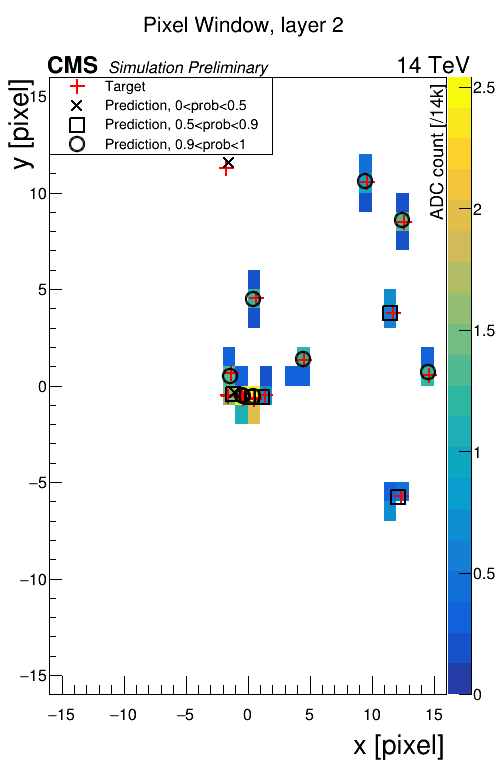

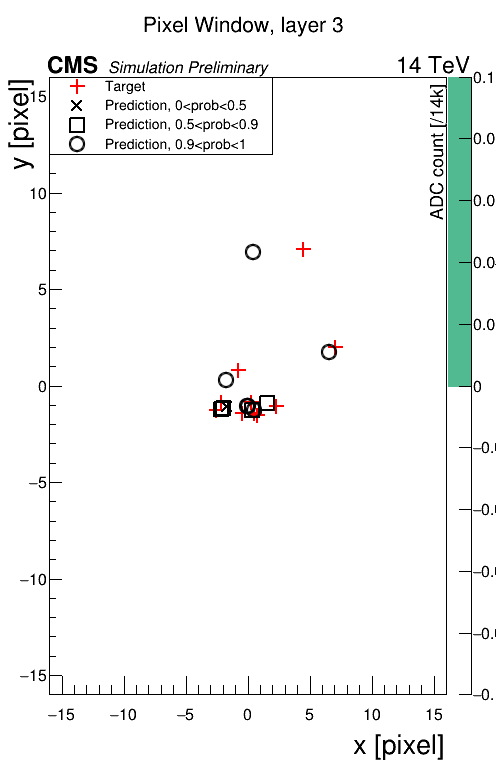

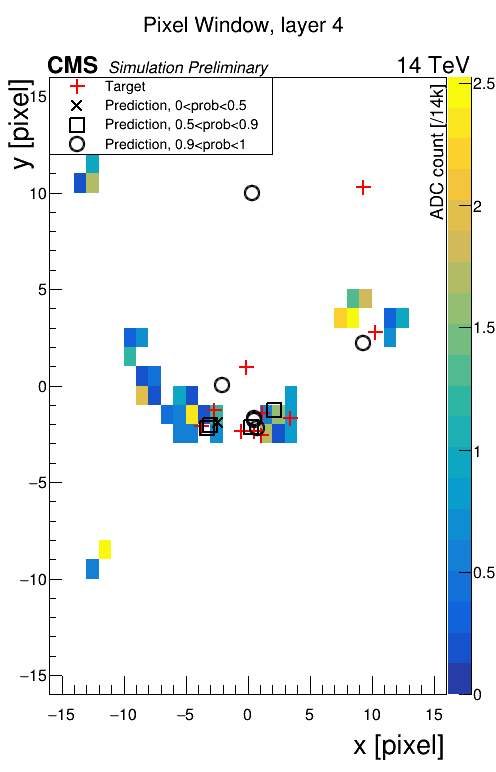

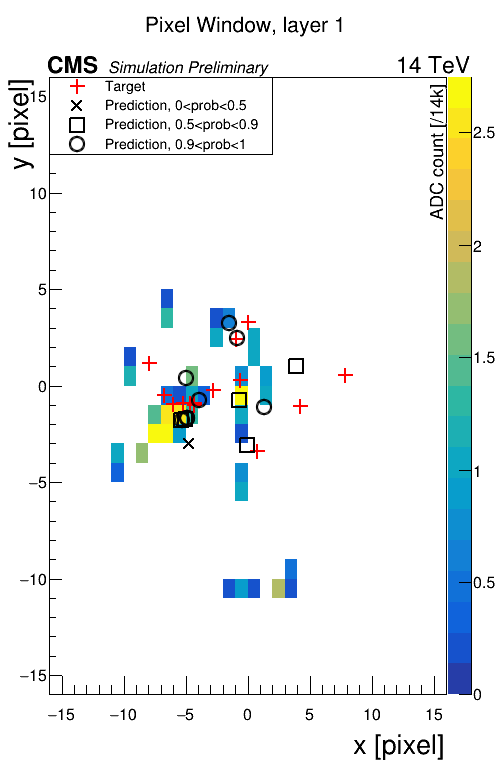

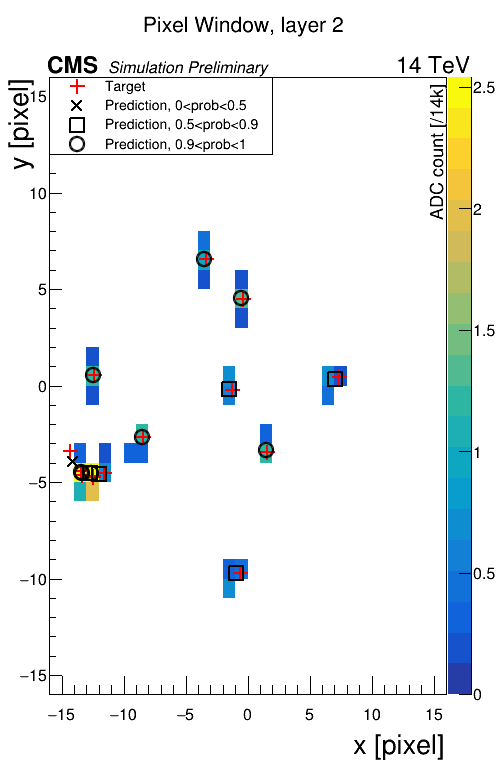

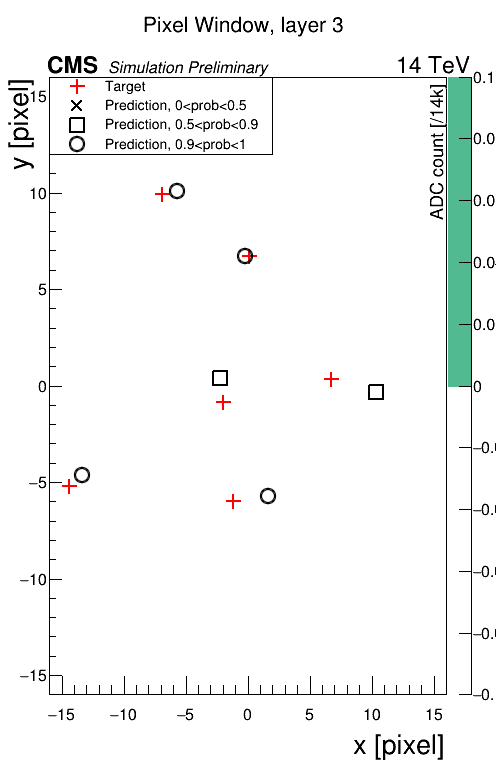

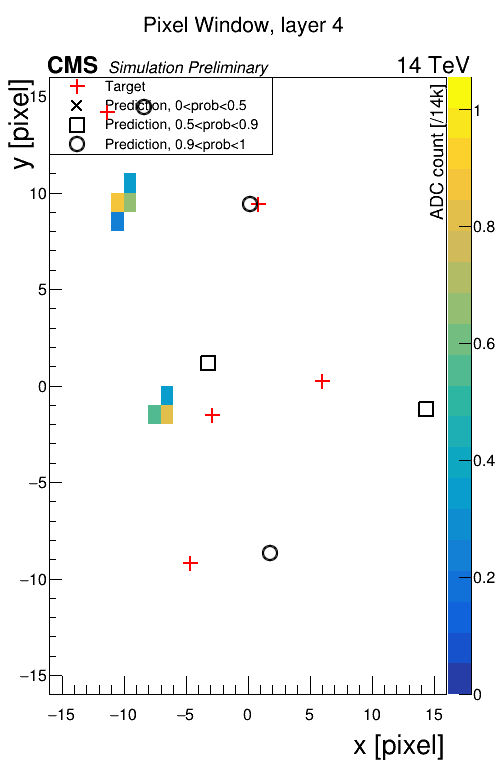

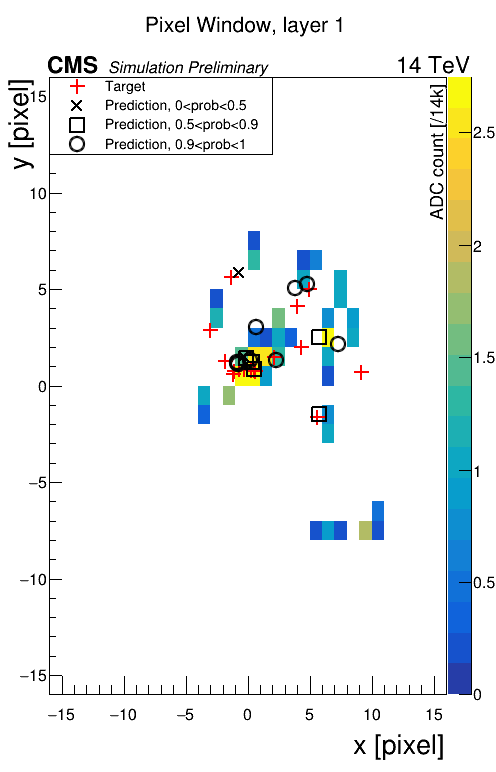

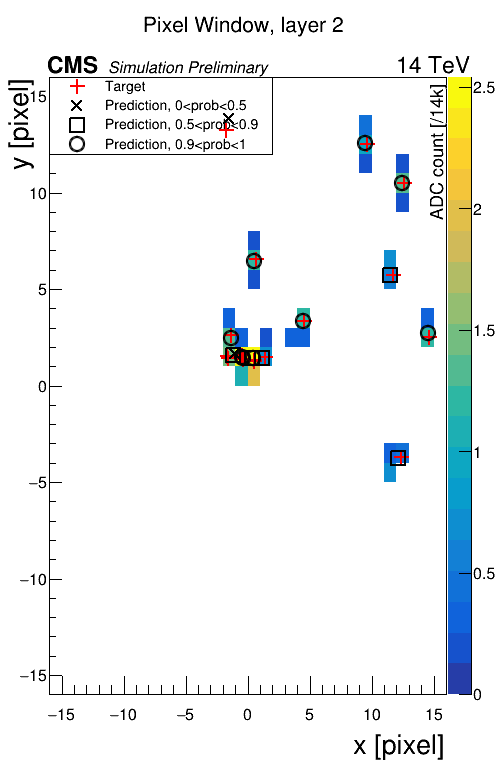

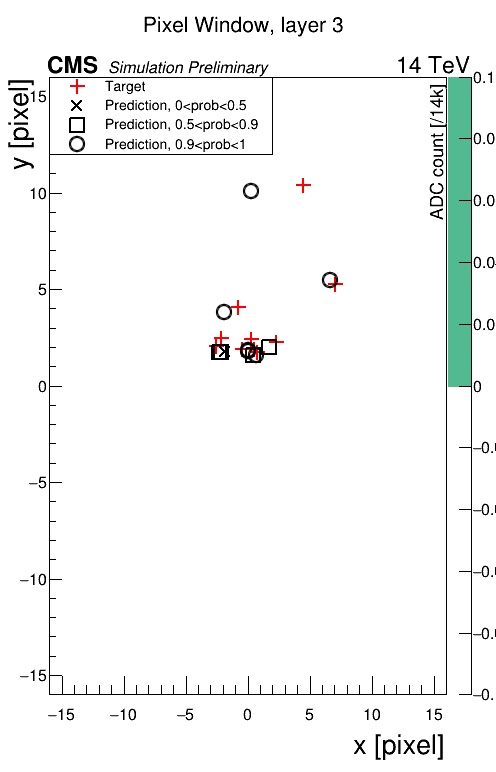

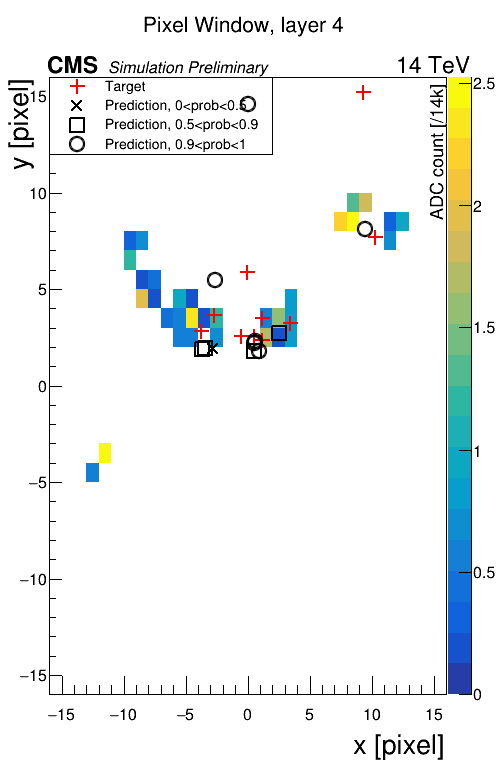

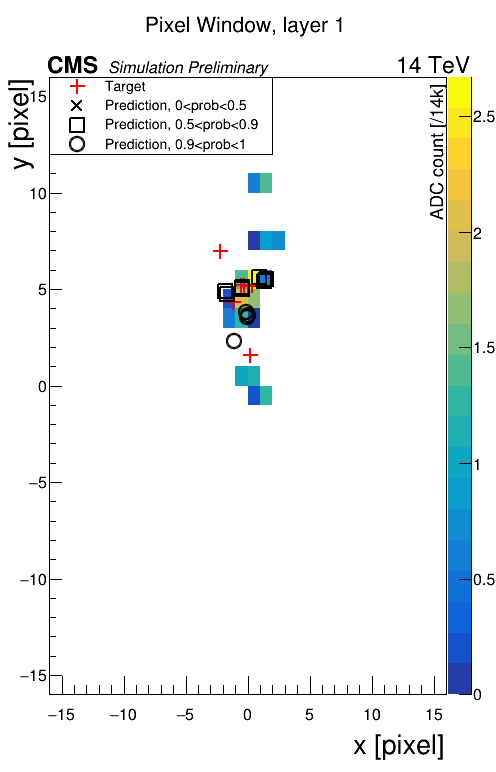

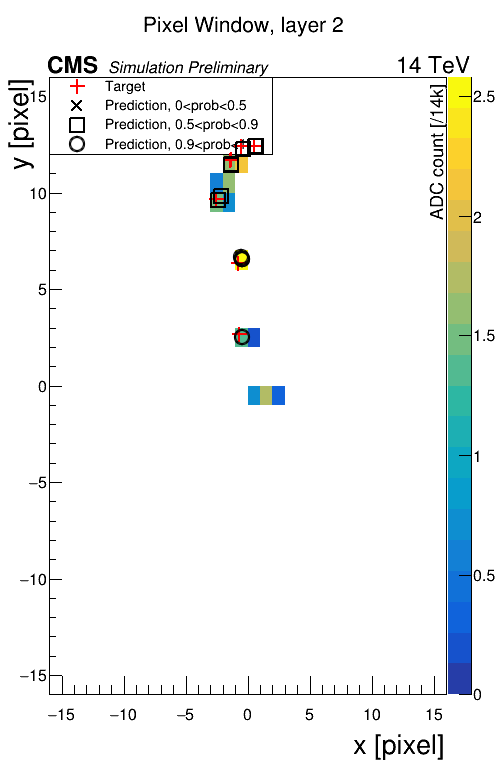

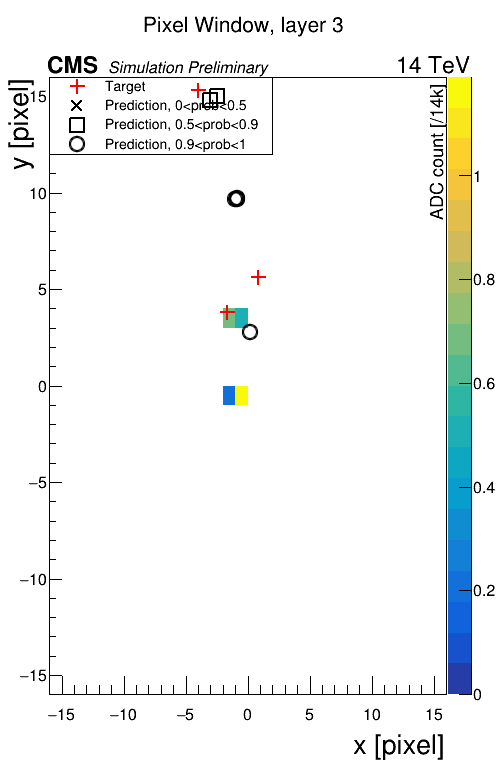

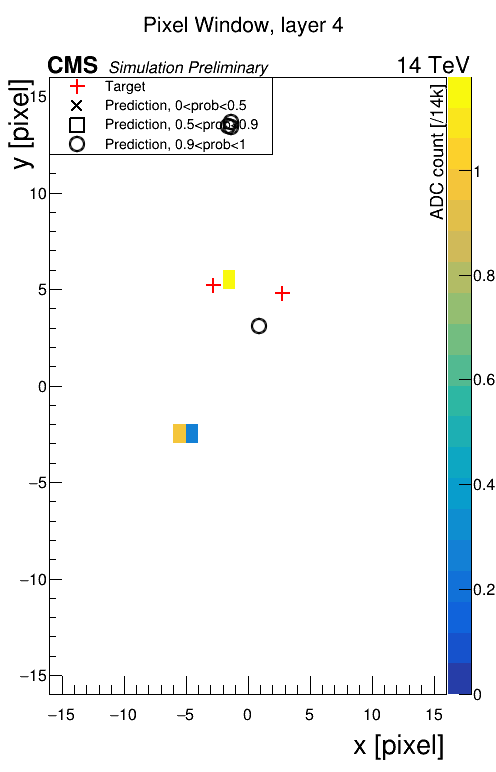

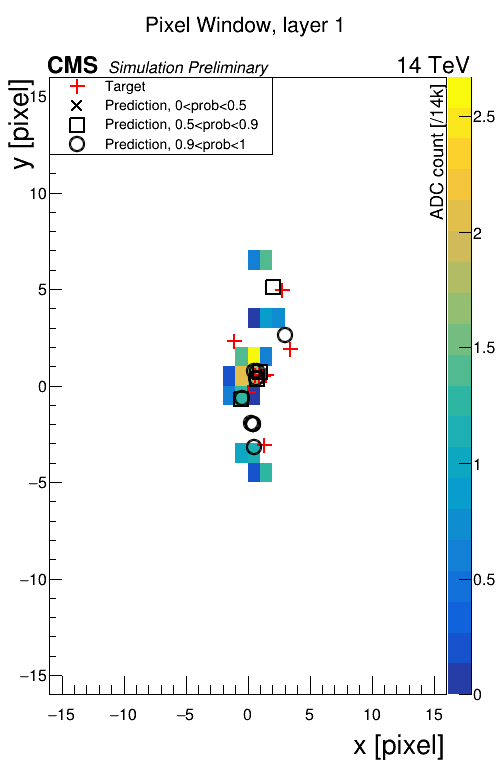

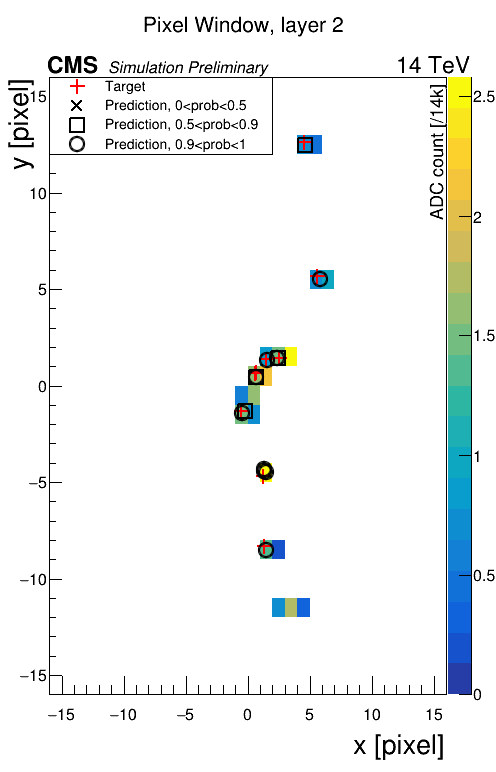

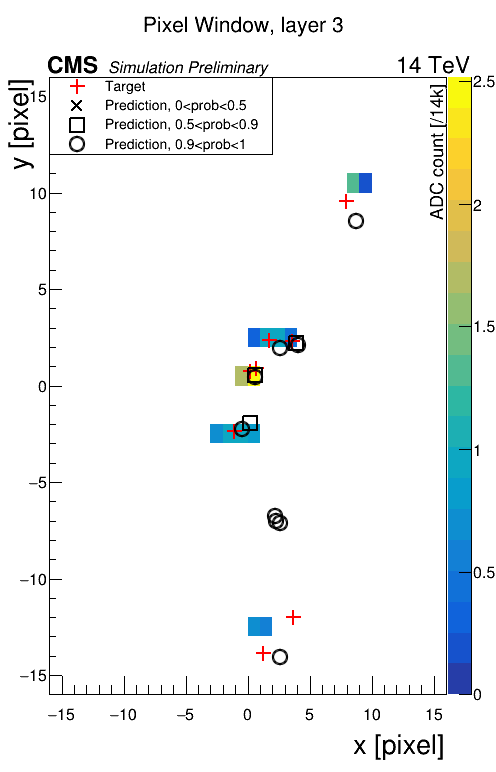

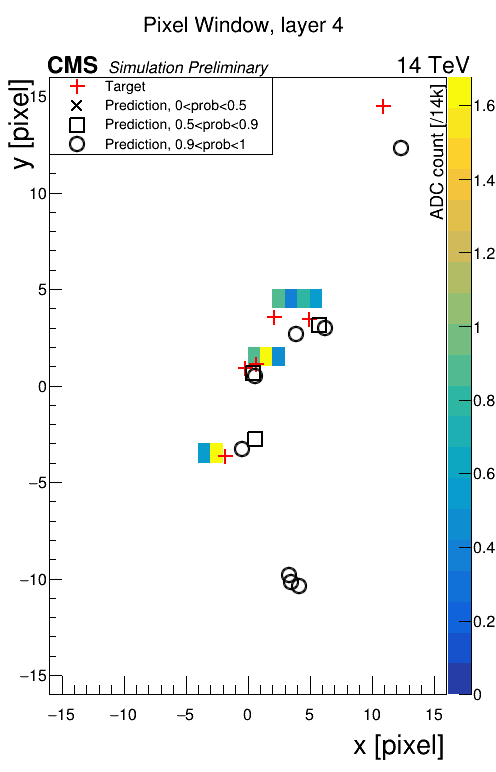

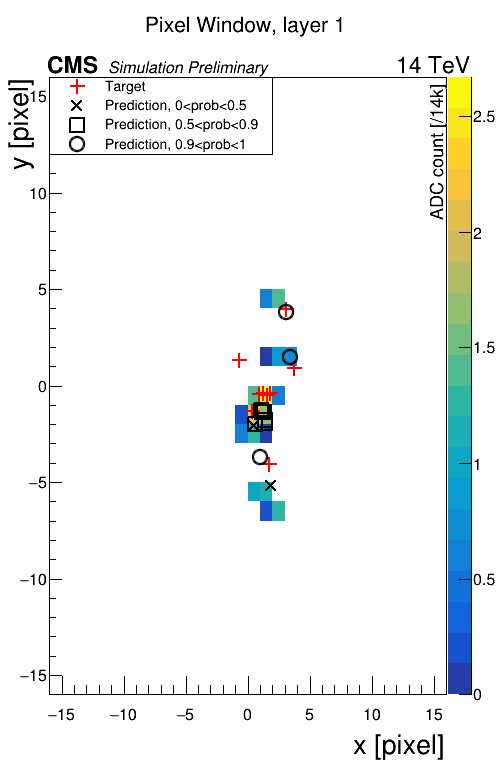

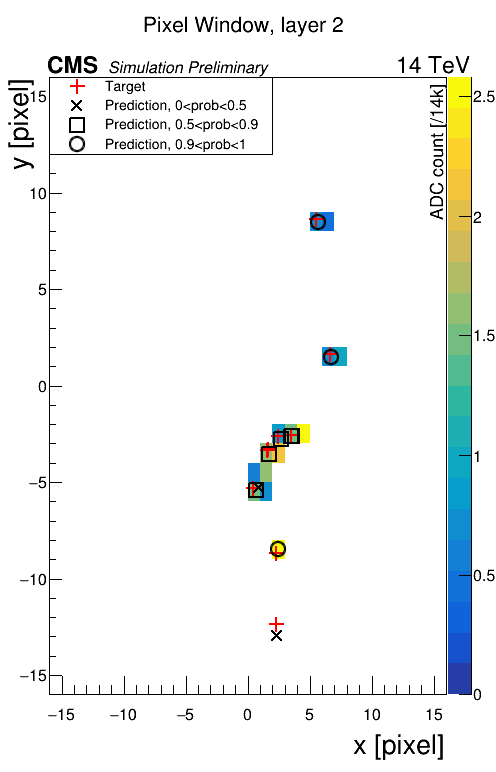

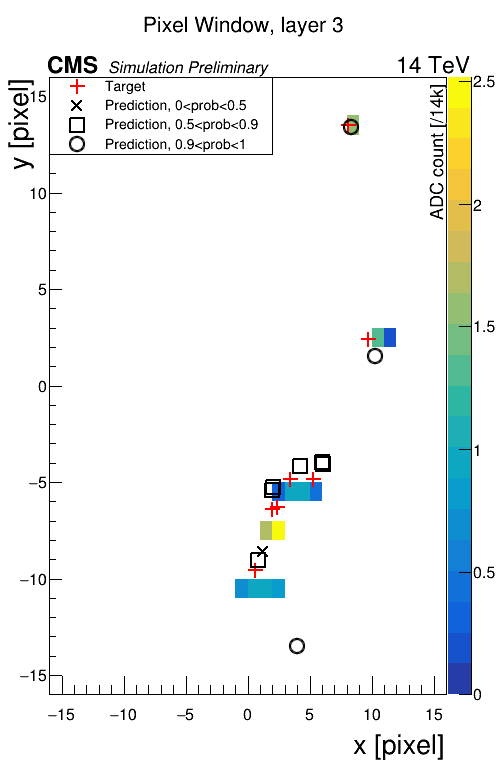

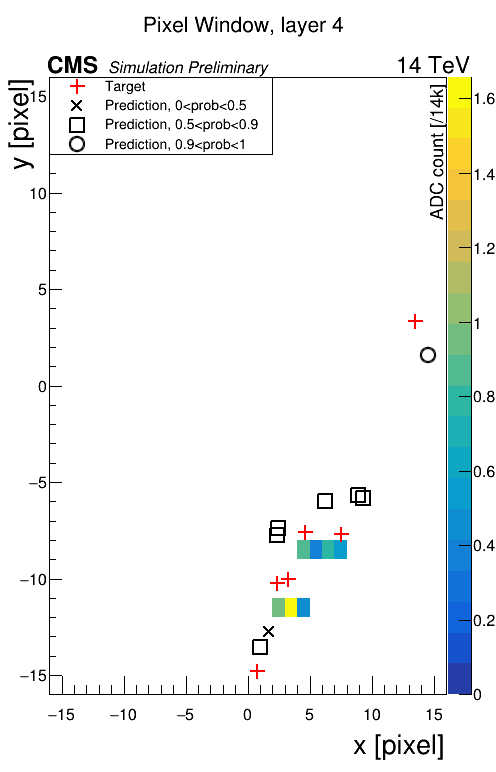

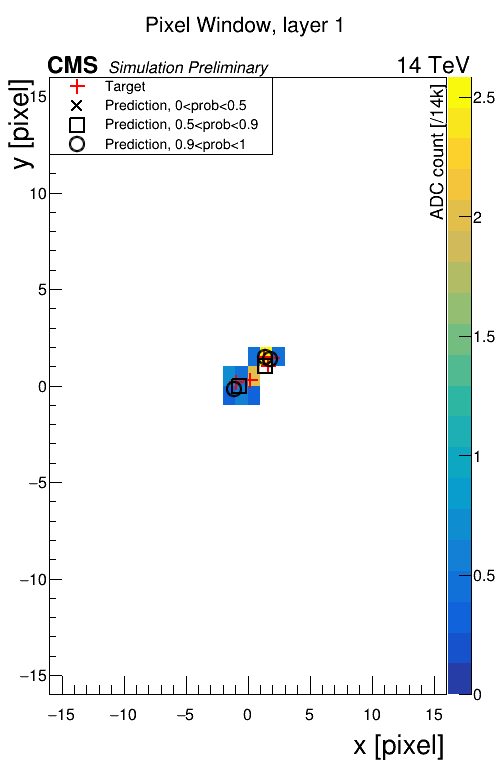

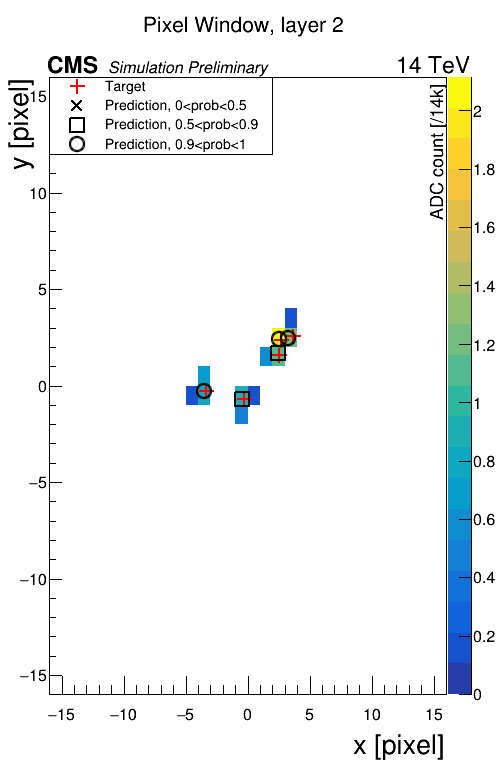

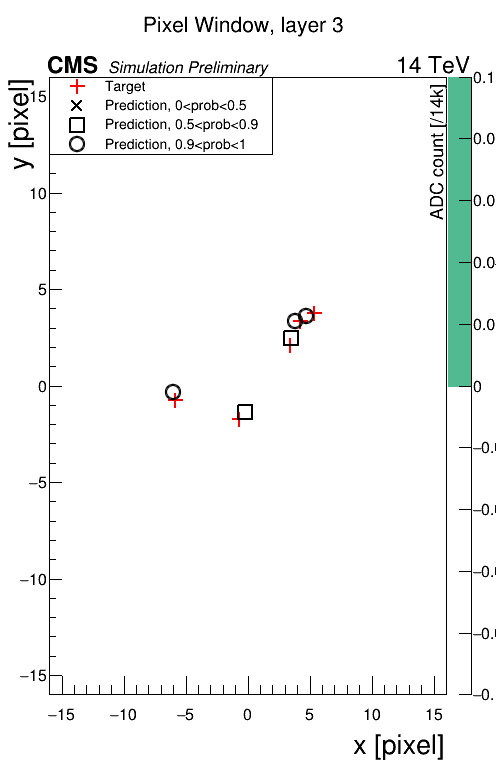

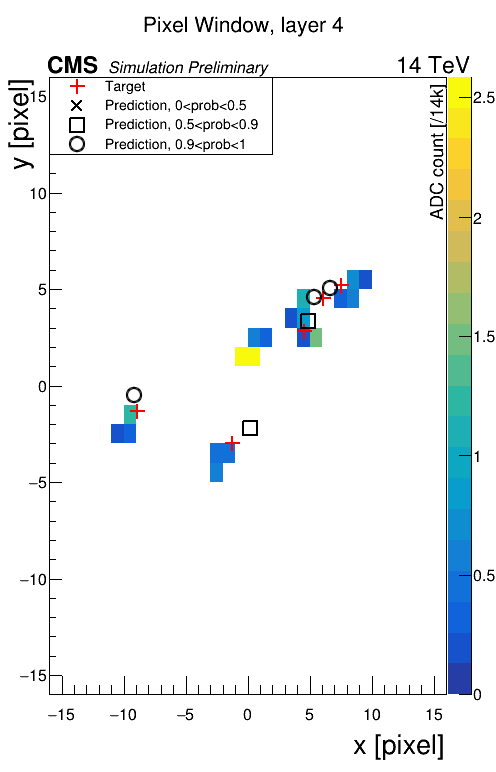

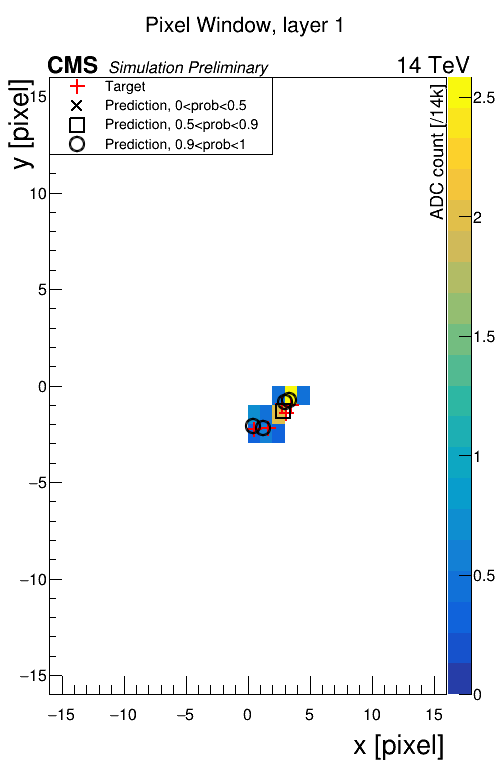

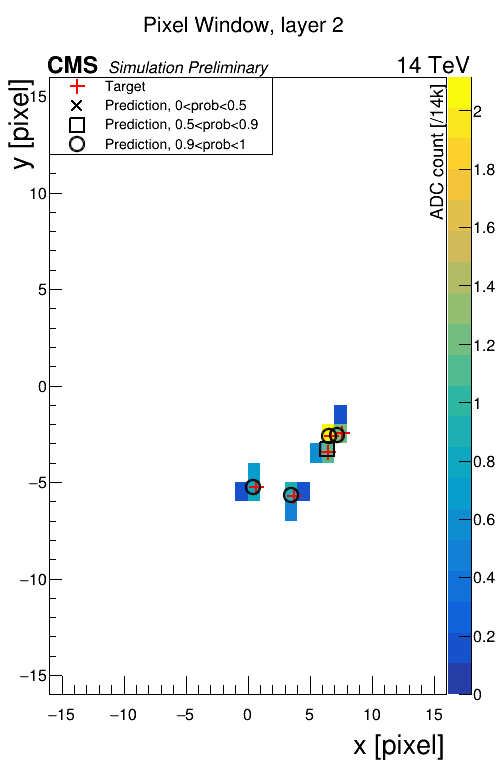

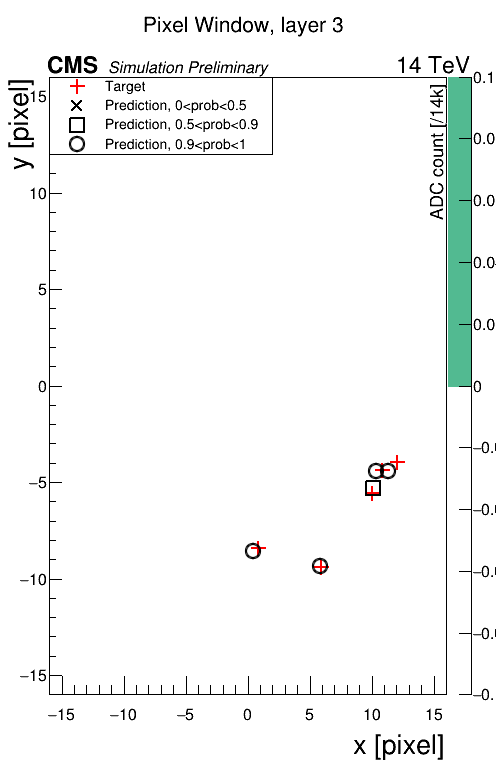

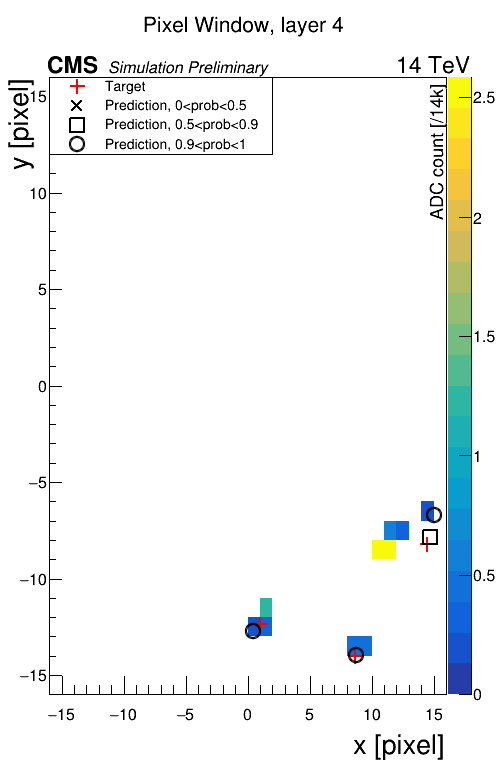

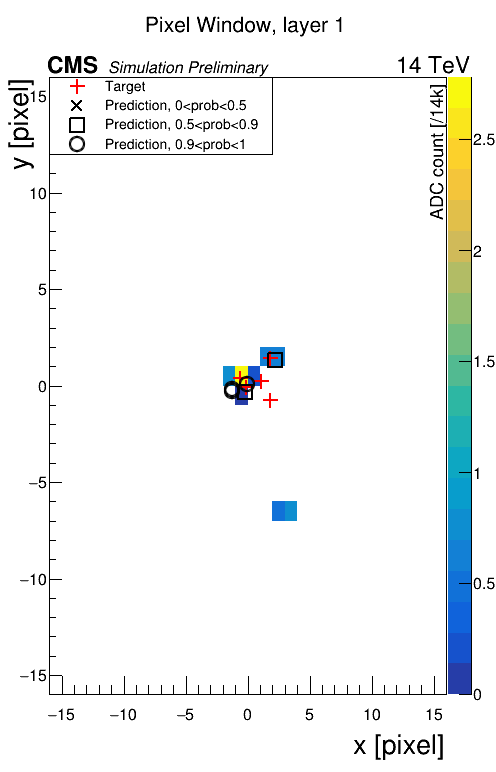

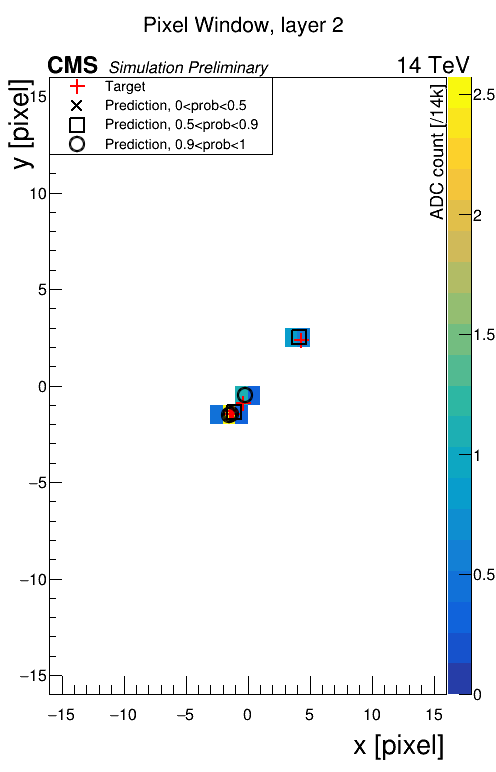

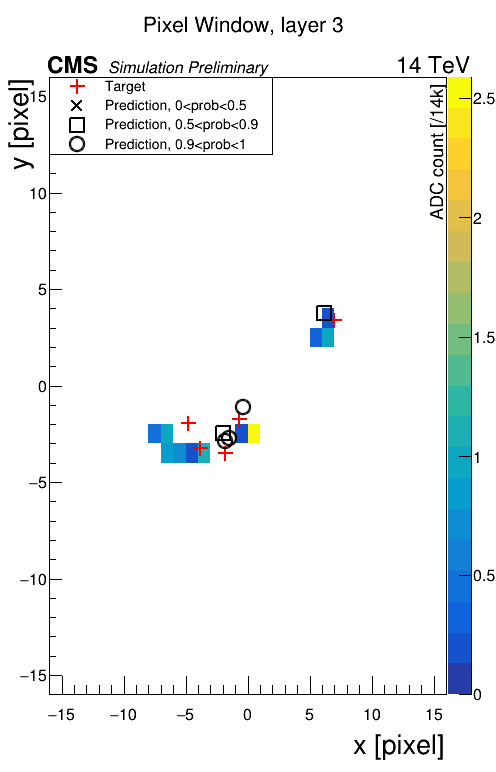

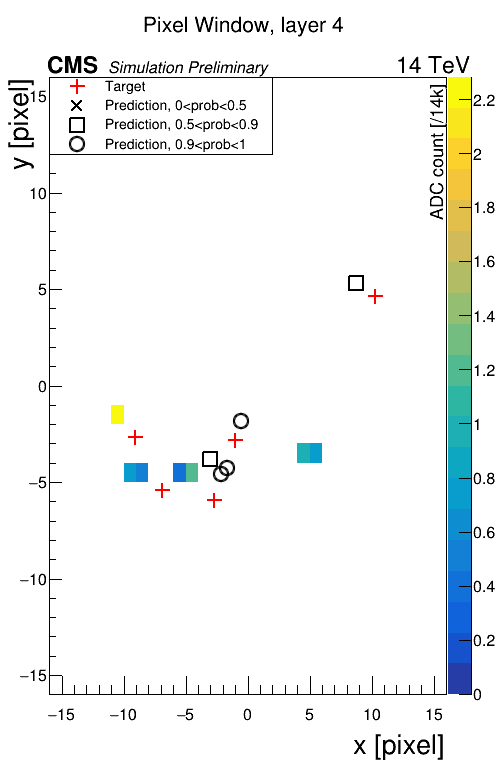

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


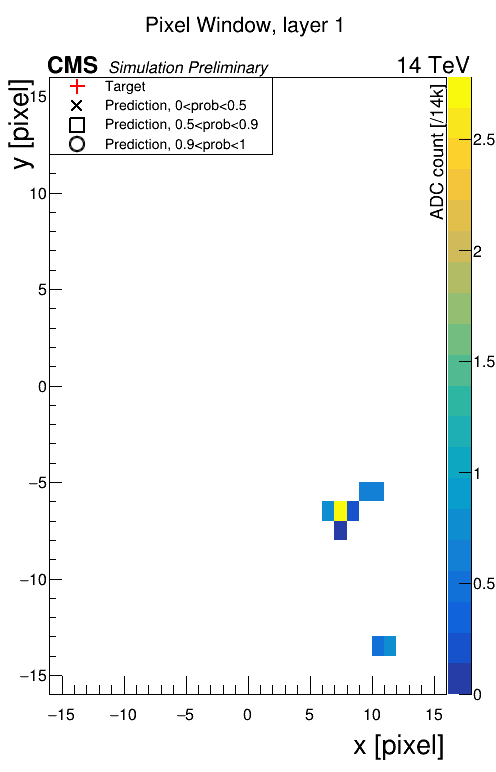

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


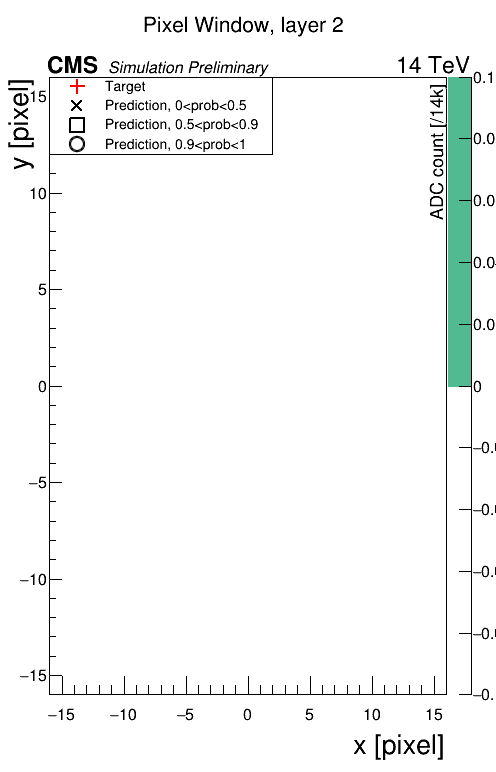

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


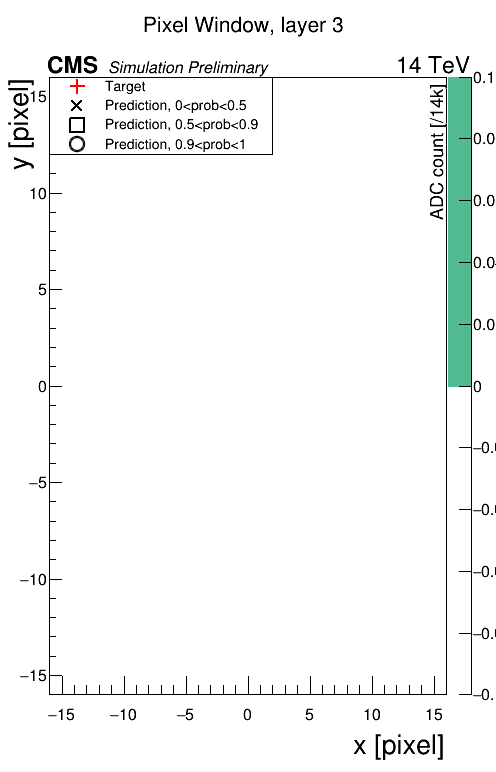

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


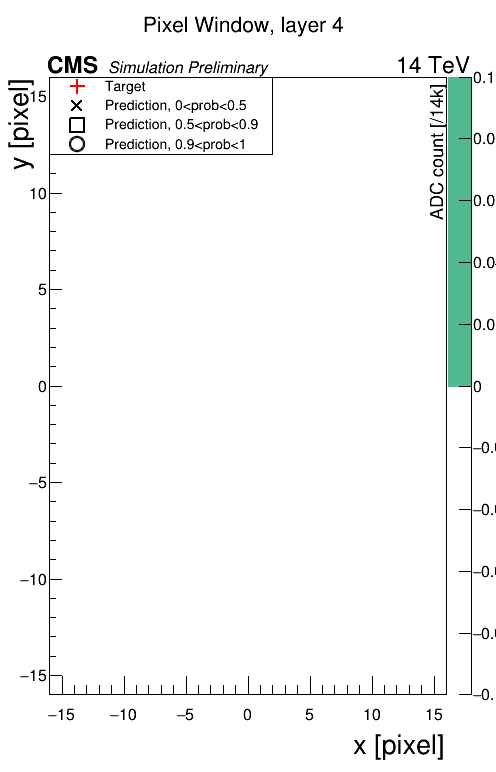

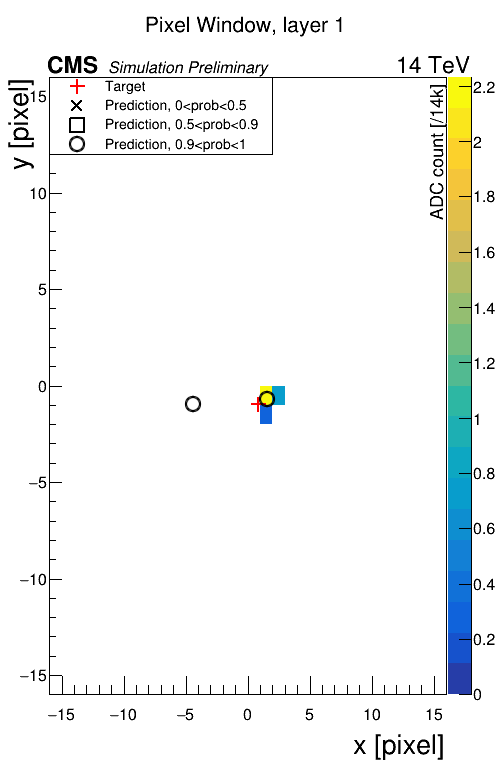

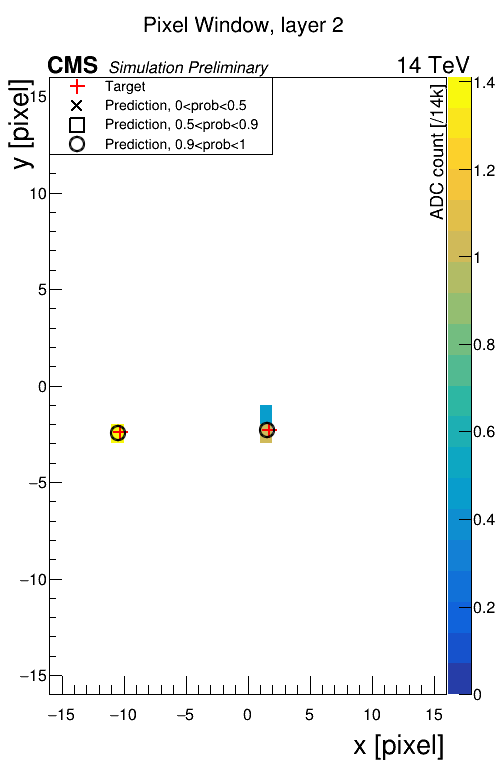

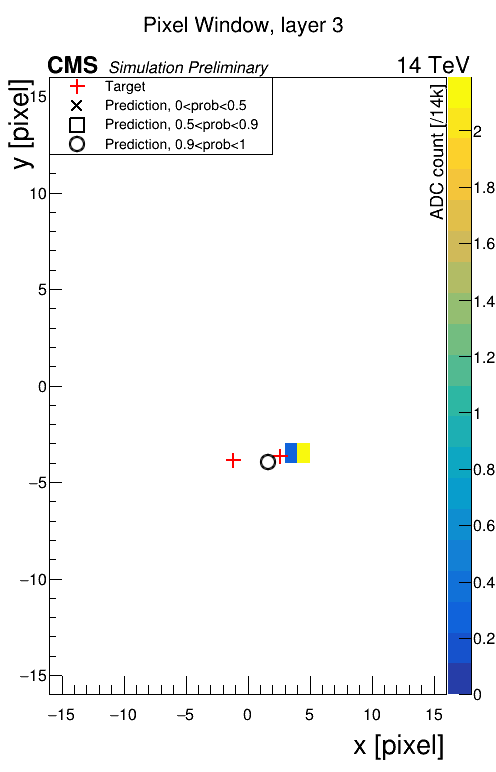

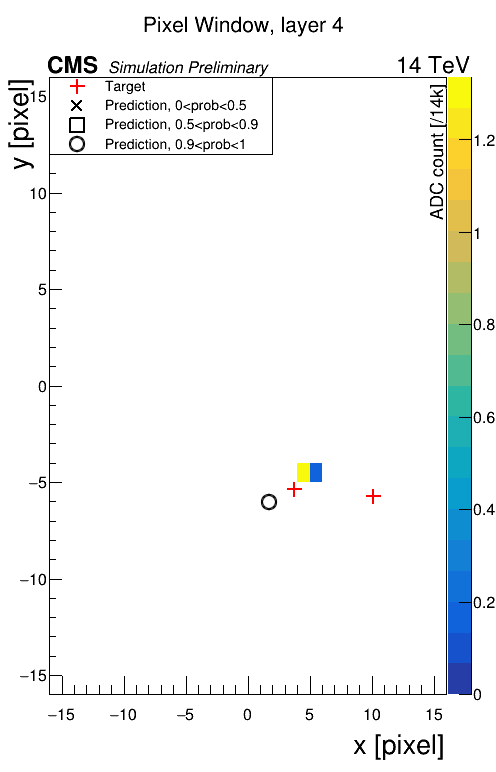

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


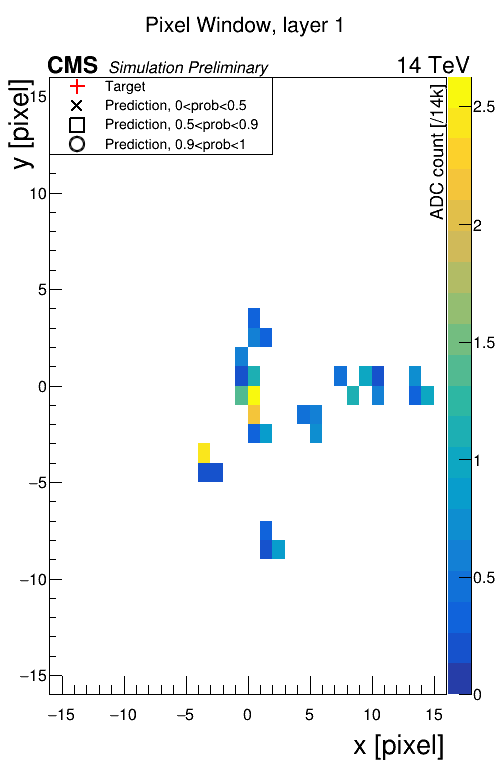

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


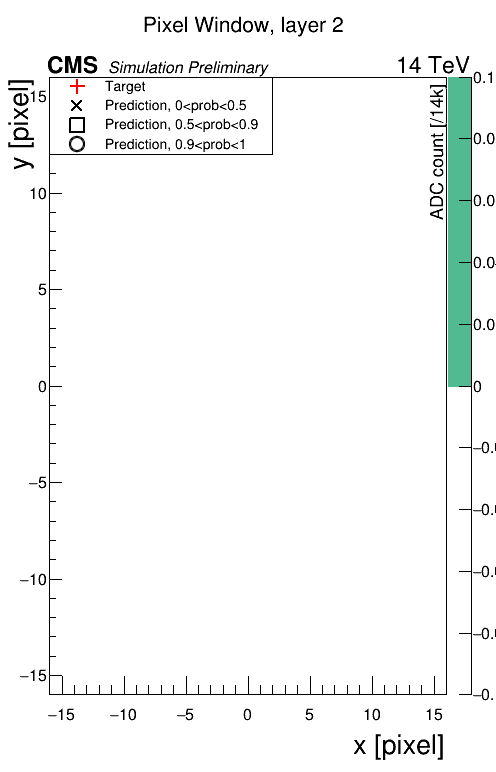

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


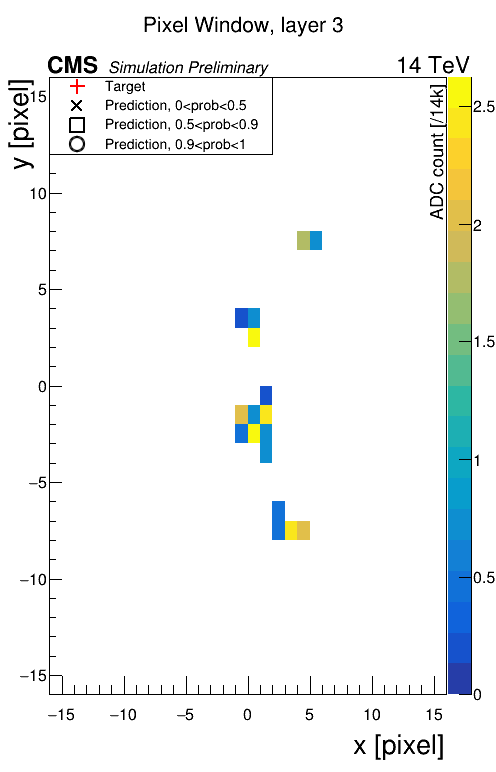

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


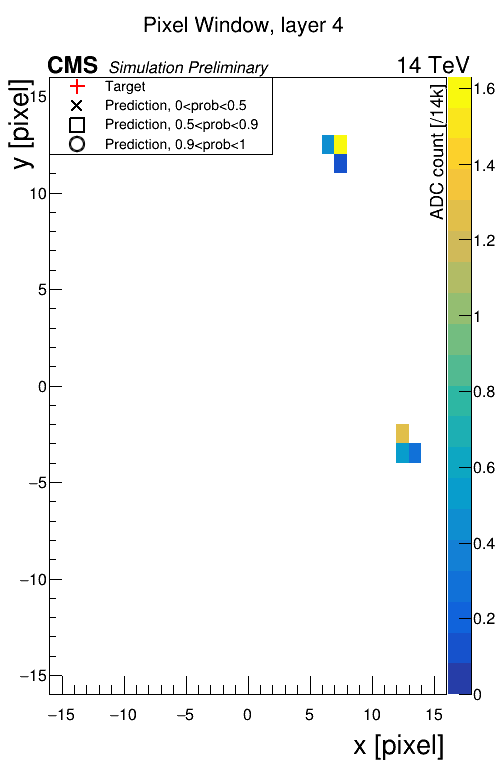

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


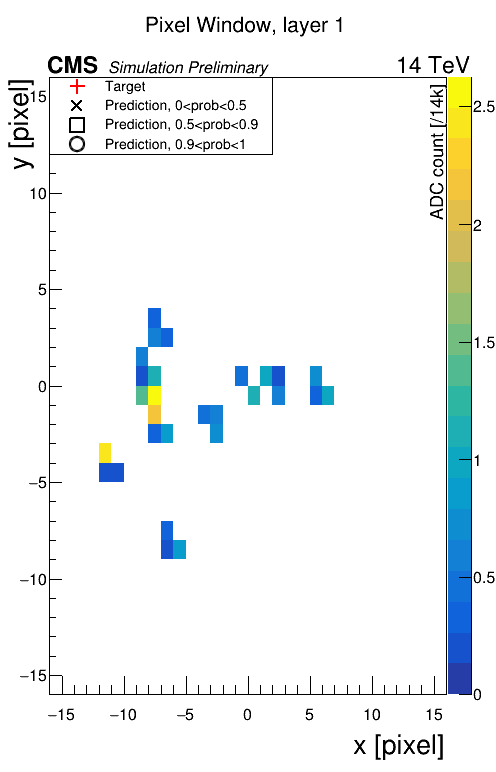

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


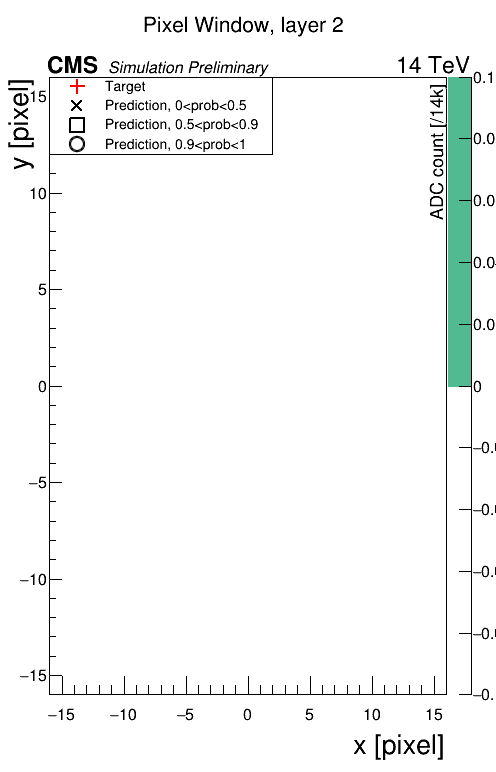

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


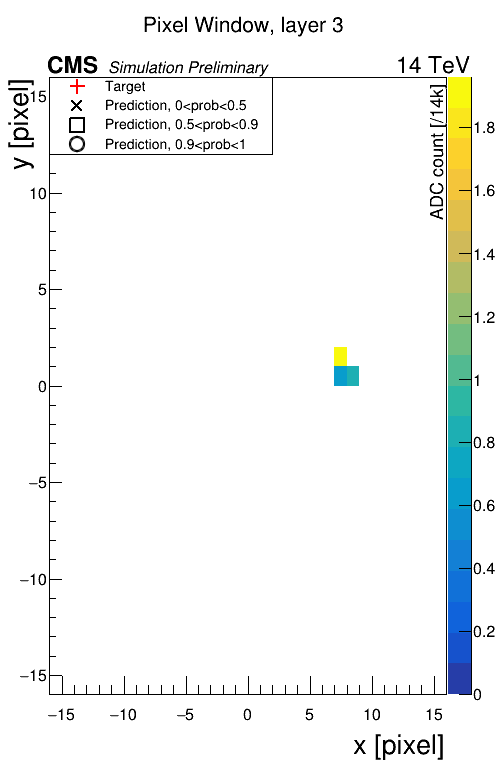

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


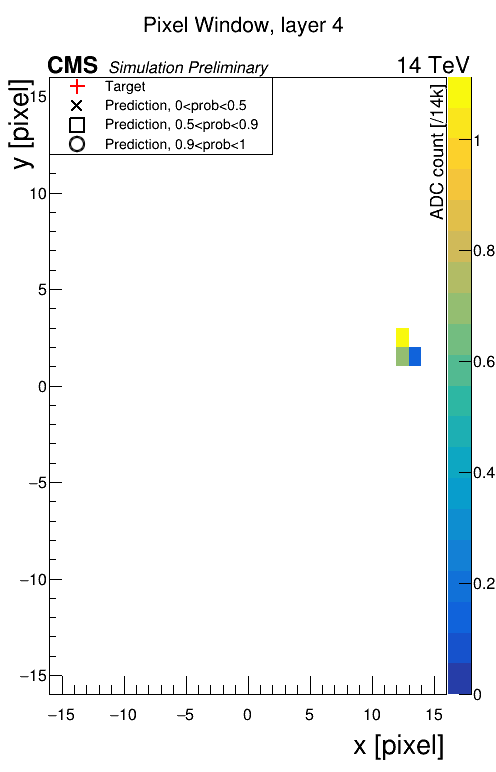

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


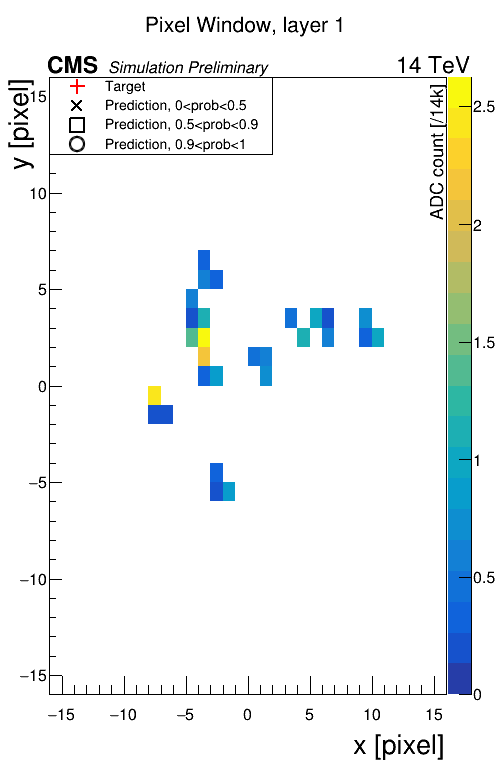

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


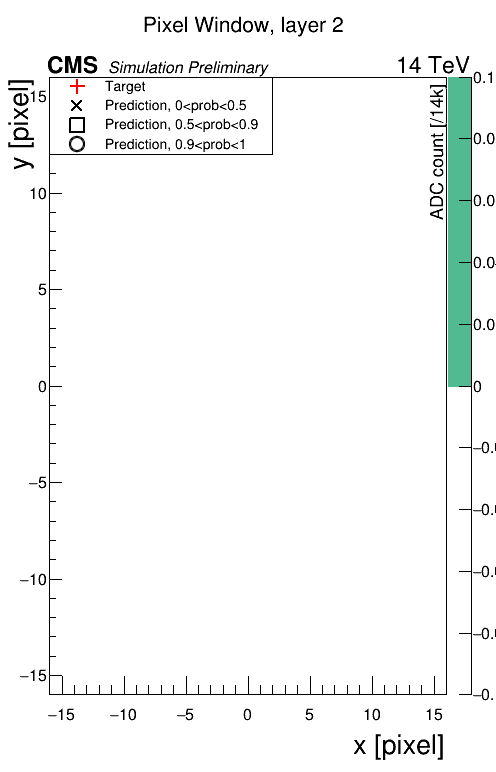

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


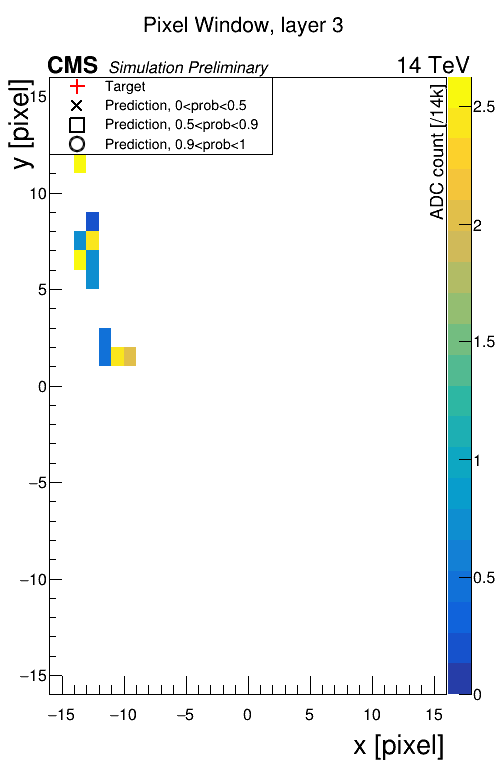

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


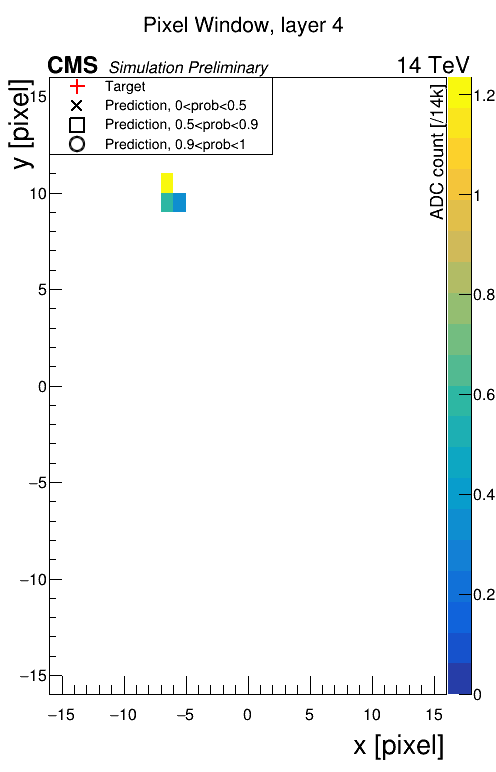

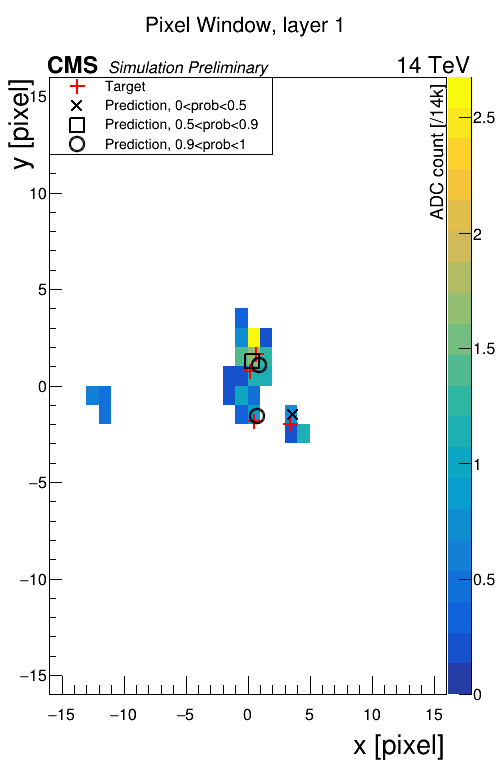

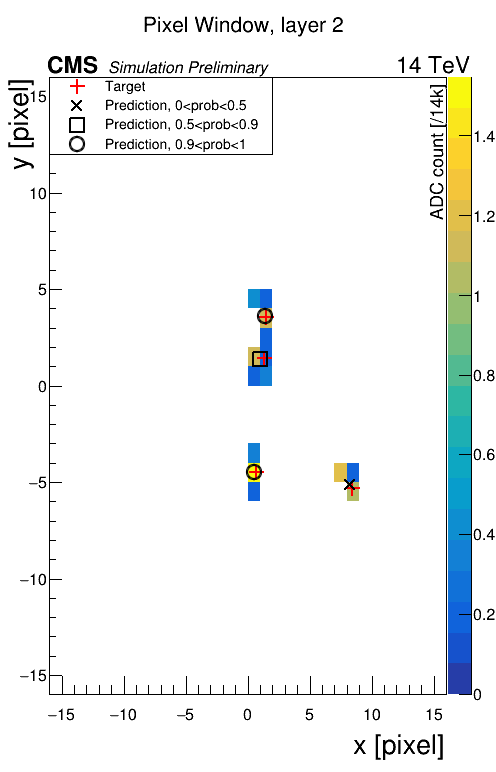

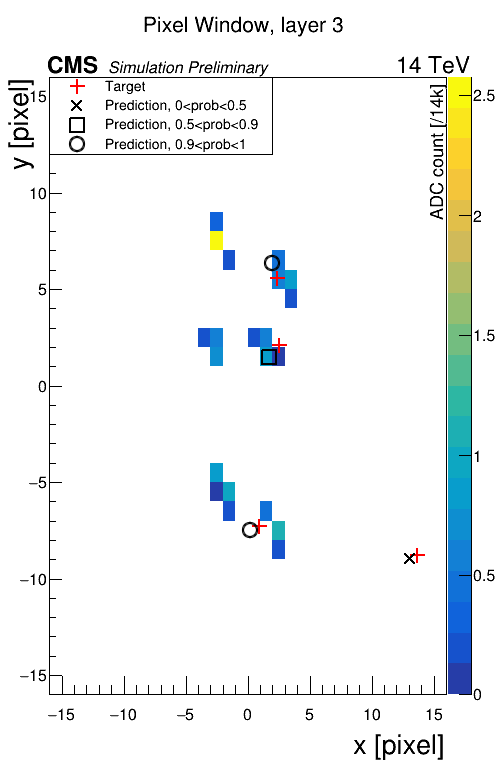

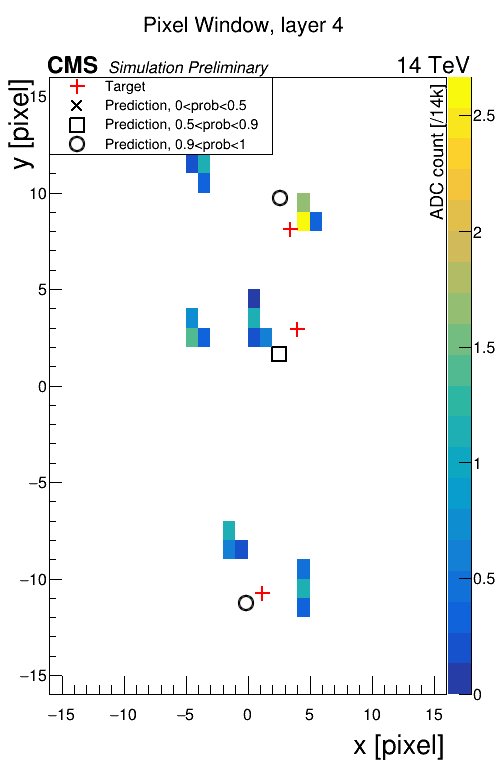

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


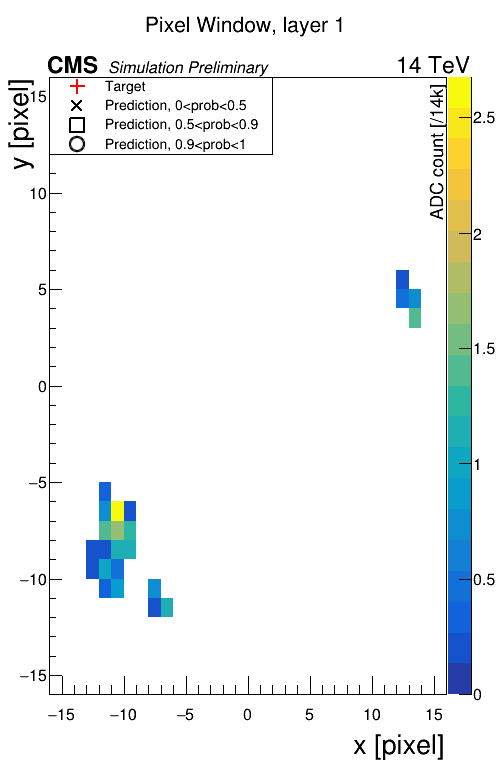

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


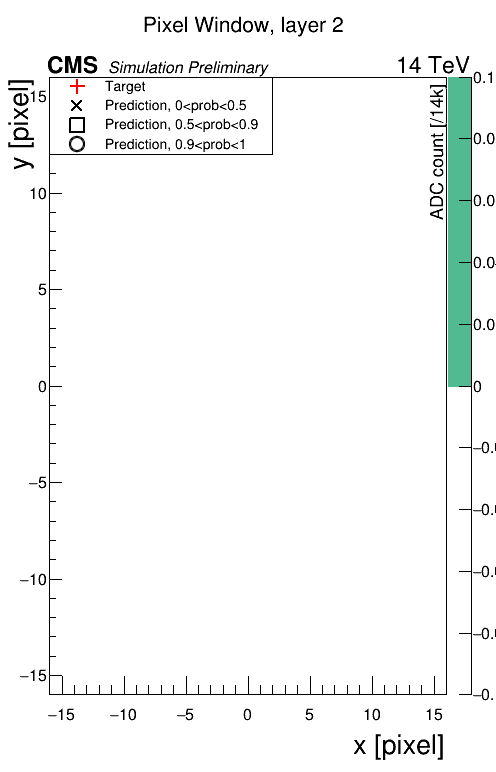

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


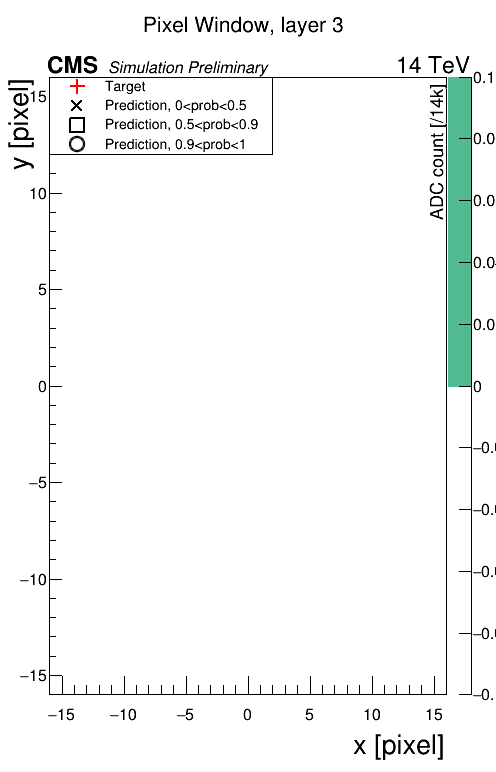

Error in <TGraphPainter::PaintGraph>: illegal number of points (0)


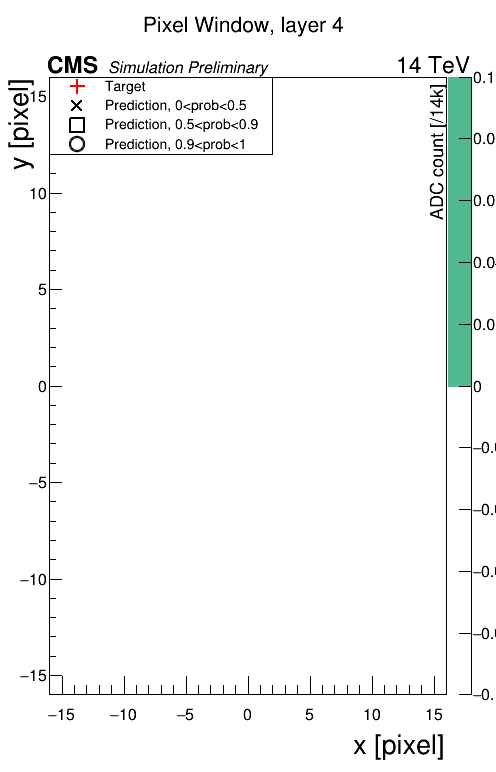

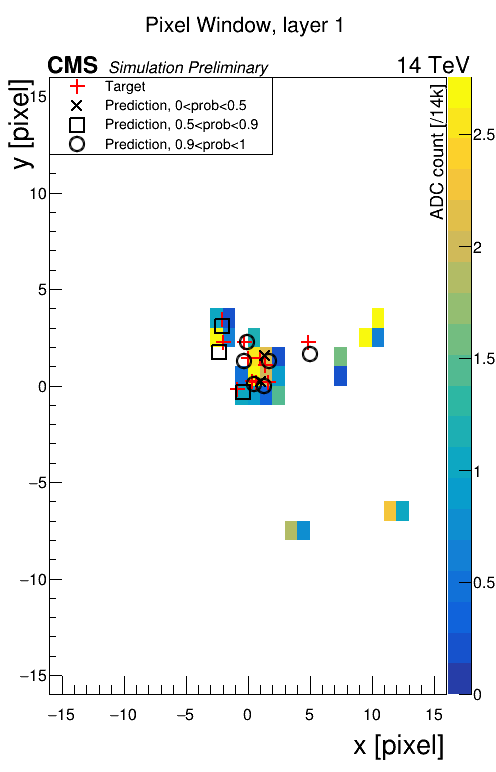

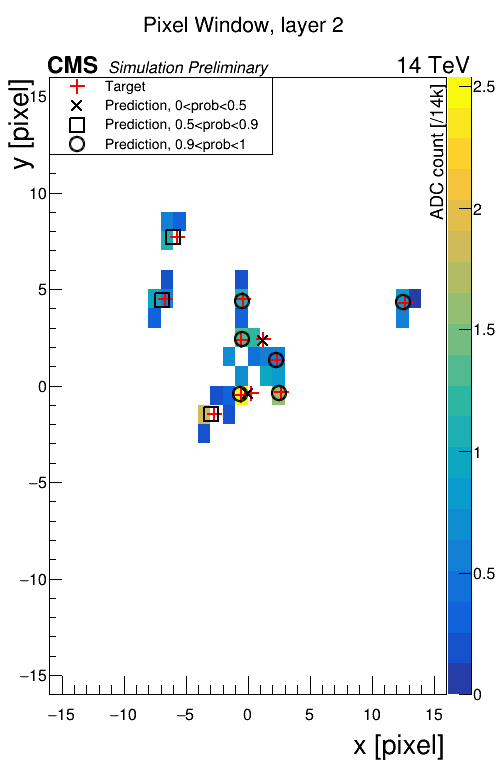

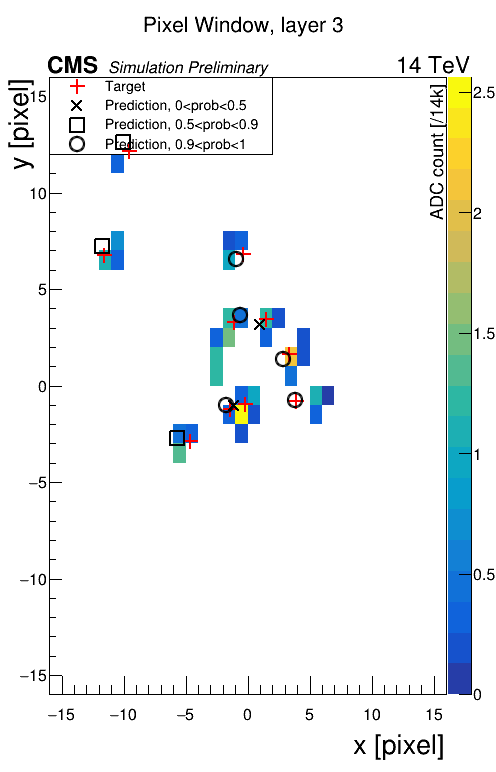

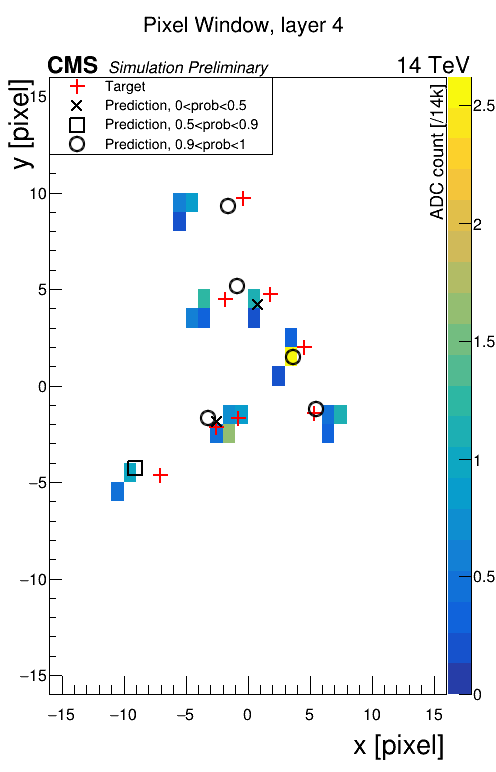

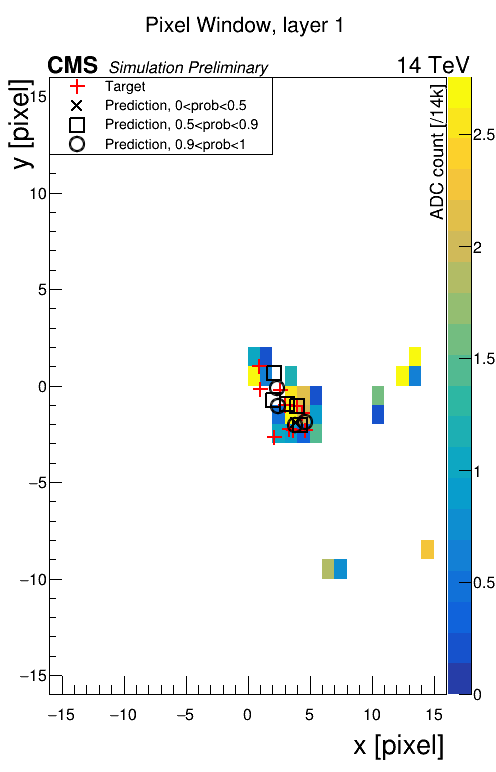

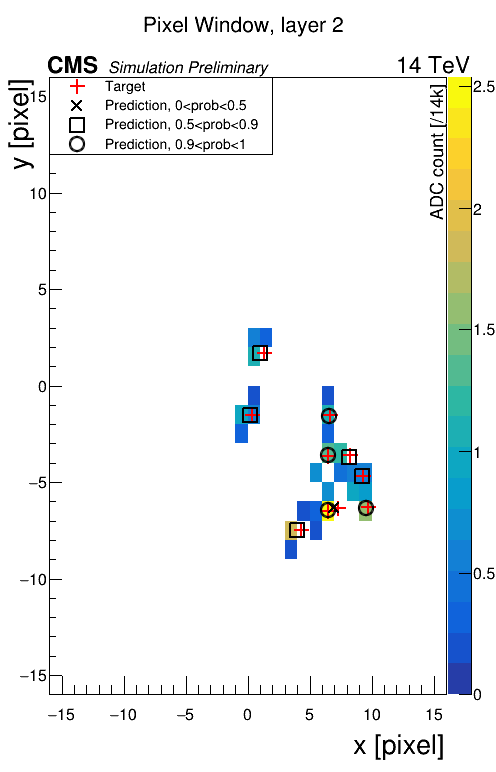

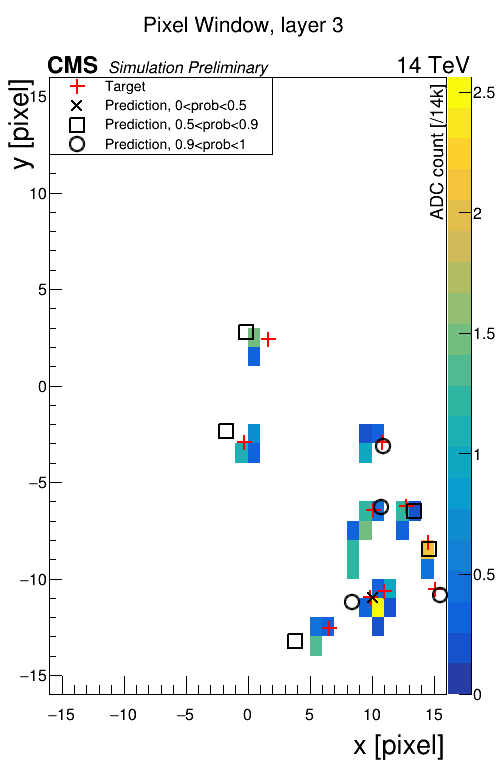

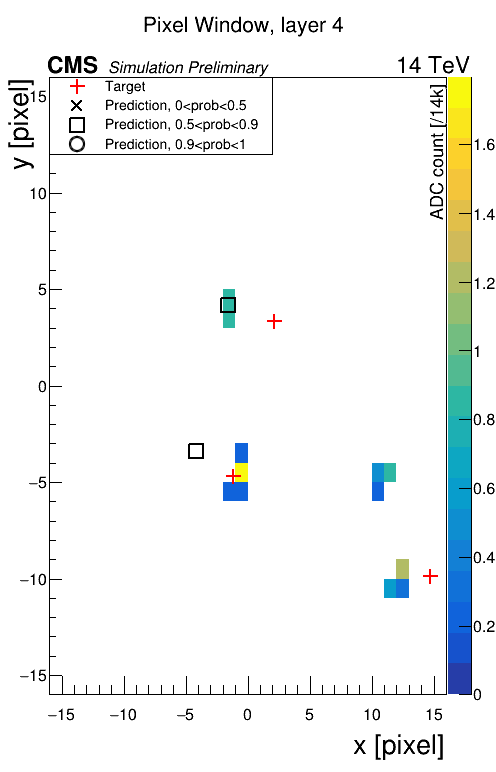

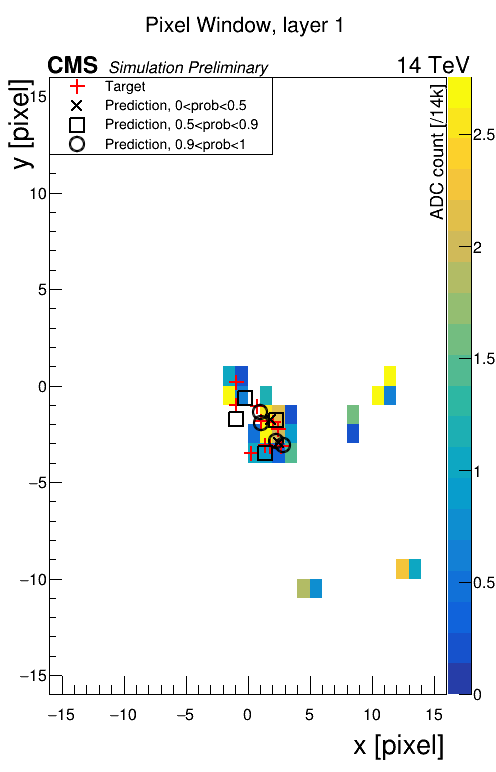

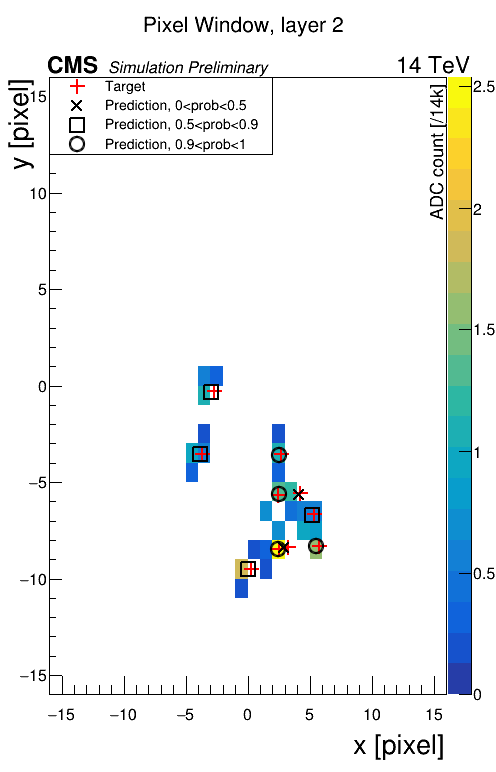

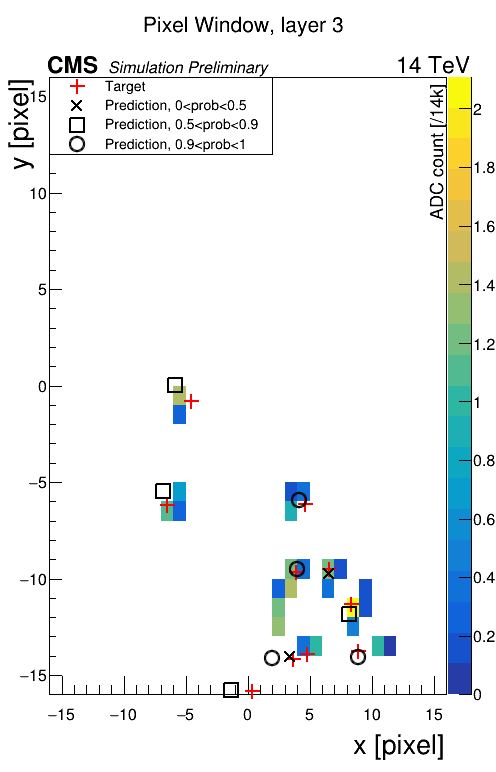

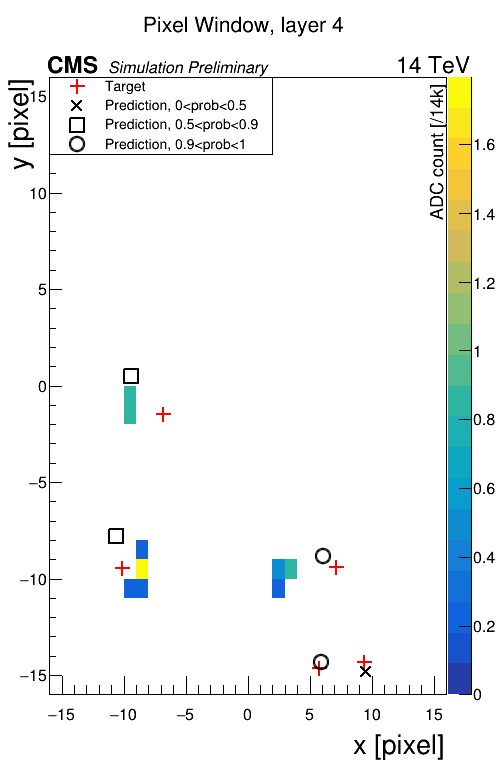

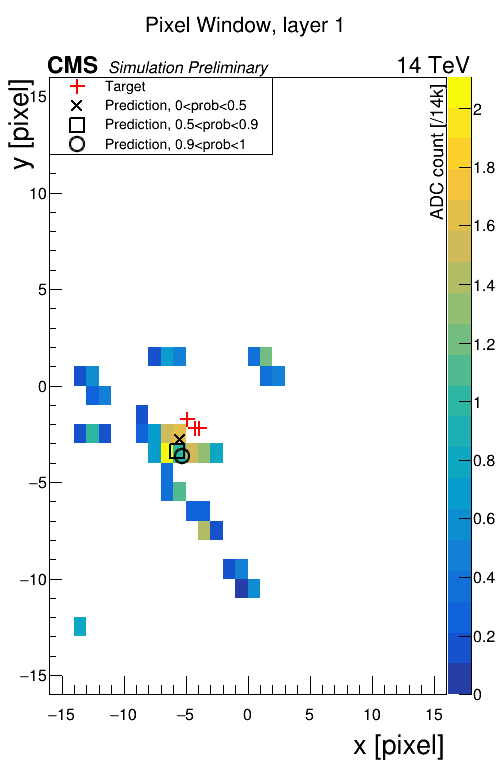

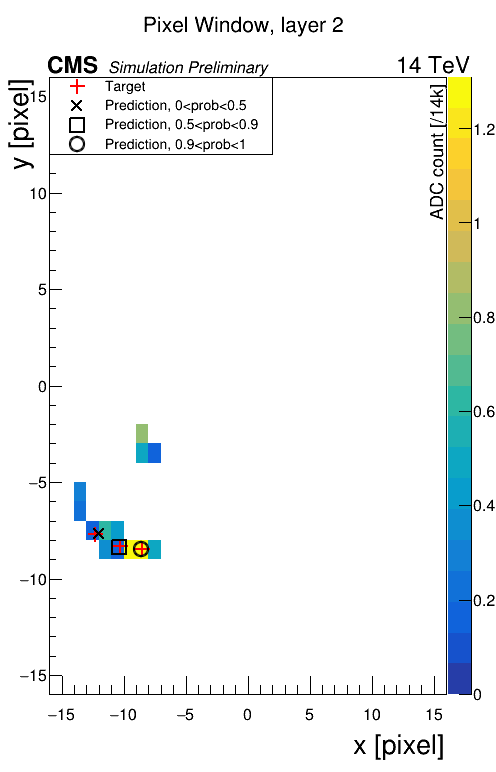

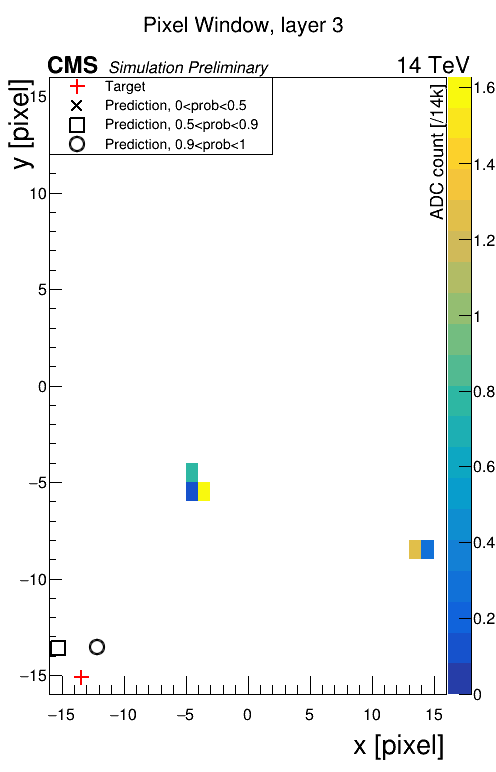

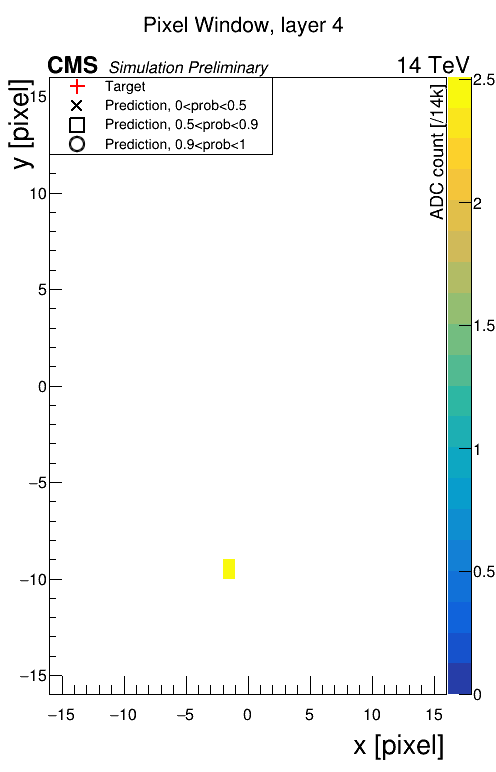

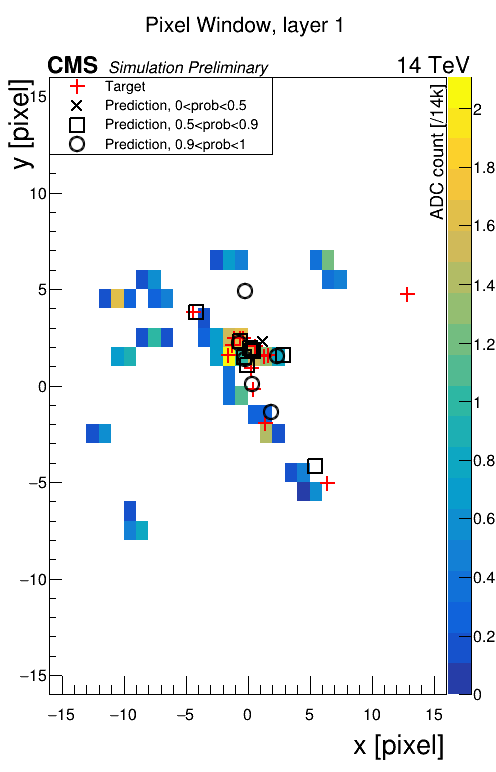

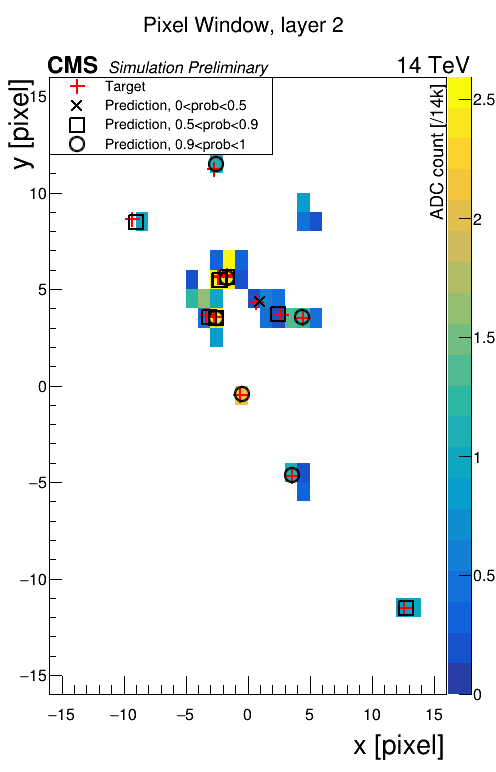

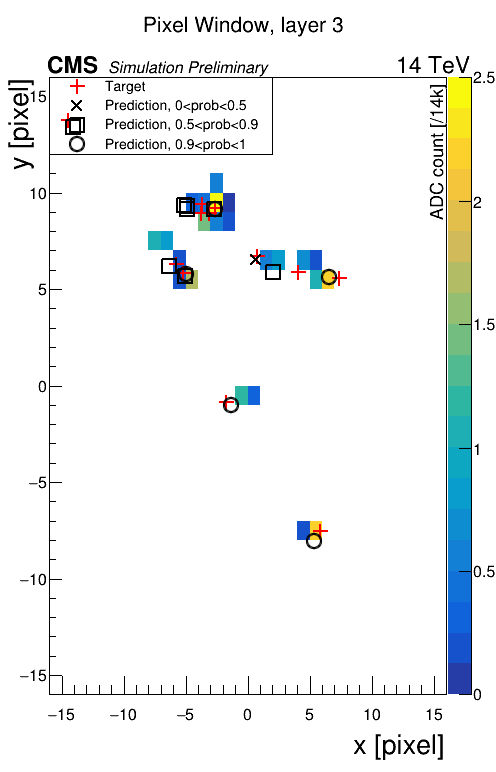

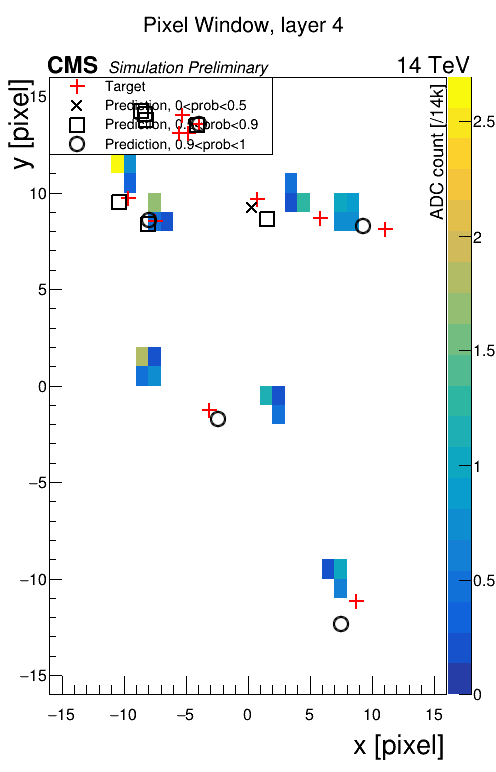

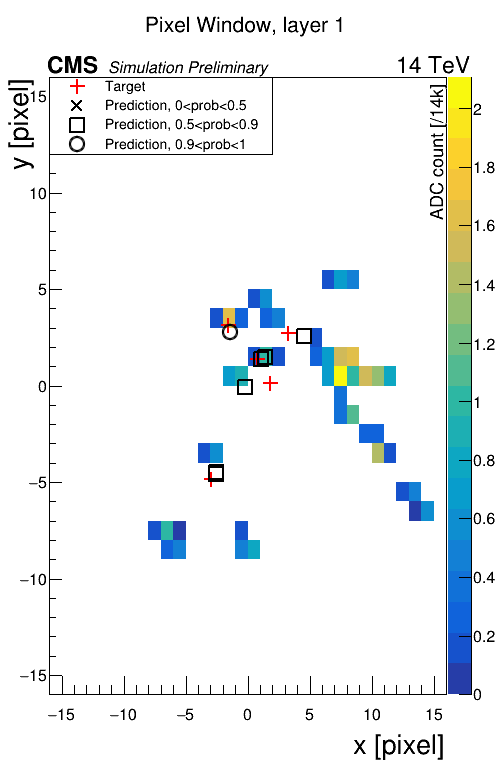

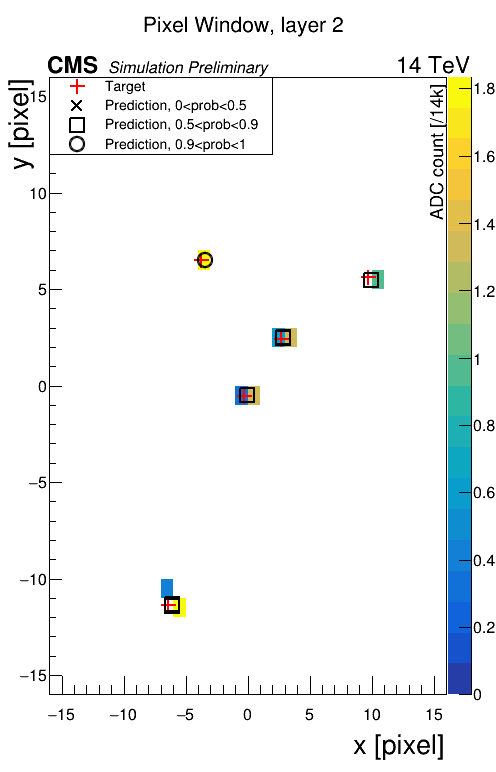

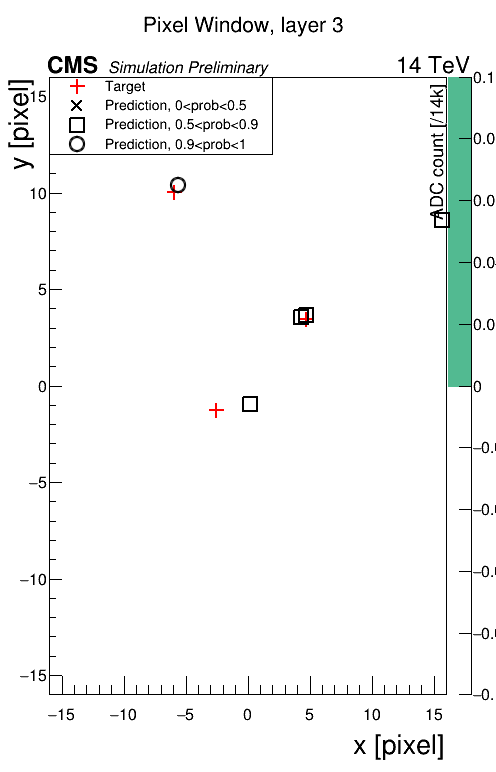

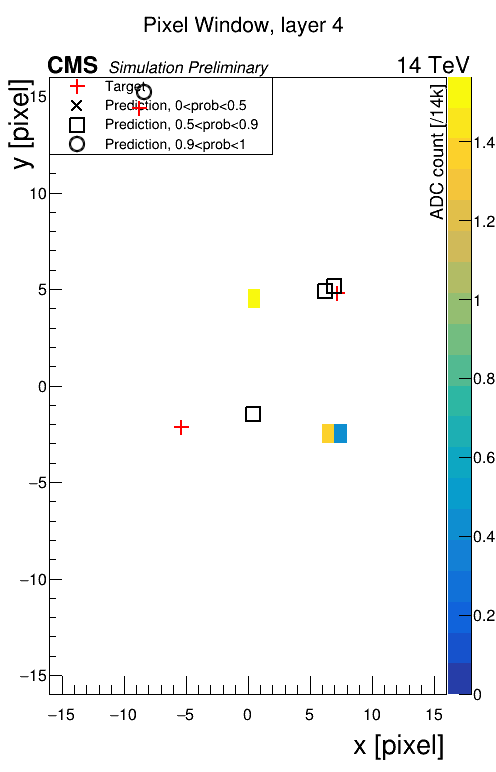

In [11]:
#attempt at improved plotter

#numPrint = 50 -> number of event saved in the root file
#jetNum=0 -> number of jets in the input. will be filled with local input information
#jetNum_validation = 0 -> number of jets in the input. will be filled with local input information
#jetDim=30 -> dimension of window on the pixel detector layer 
#overlapNum =3 -> number of overlap considered 
#layNum = 4 -> 4 for barrel the numeration is 1-4 for barrel
#parNum=5 -> number of track parameters 


# helper that gets point shape from probability
def getShapeFromProb(prob):
    if prob<.5:
        return 52 #rotated cross
    if prob<.9:
        return 54 #hollow square
    else:
        return 53 #hollow circle


if OUTPUT :
    import ROOT
    from ROOT import gStyle
    from ROOT import gROOT, TColor, TAxis
    gROOT.Reset()
    gROOT.SetBatch(True)
    gStyle.SetOptStat(0)
    validation_offset=int(len(input_)*(1-valSplit)+1)

    canvasTot = []
    canvasProb = []

    mapTot = []
    graphTargetTot = []
    mapProbPredTot = []
    graphPredTot = []

    # for each event saved in the root file (50)
    for jet in range(numPrint) :

        canvasTot_jet = []
        mapTot_jet = []
        graphTargetTot_jet = []
        canvasProb_jet =[]
        mapProbPredTot_jet =[]
        #graphPredTot_jet = []

        #for each overlap (3)
        for trk in range(overlapNum) :
            canvasProb_jet.append(ROOT.TCanvas("canvasProb_%d_%d" % (jet,trk), "canvasProb_%d_%d" % (jet,trk),500,800))
            mapProbPredTot_jet.append(ROOT.TH2F("mapProbPredTot_%d_%d" % (jet,trk), "mapProbPredTot_%d_%d" % (jet,trk), jetDim,-jetDim/2,jetDim/2,jetDim,-jetDim/2,jetDim/2))

        #for each layer in the barrel (4)
        for lay in range(layNum) :
            mapTot_jet.append(ROOT.TH2F("mapTot_%d_%d" % (jet, lay), "mapTot_%d_%d" % (jet, lay), jetDim,-jetDim/2,jetDim/2,jetDim,-jetDim/2,jetDim/2))
            canvasTot_jet.append(ROOT.TCanvas("canvasTot_%d_%d" % (jet, lay), "canvasTot_%d_%d" % (jet, lay),500,800))
            graphTargetTot_jet.append(ROOT.TGraph())
            #graphPredTot_jet.append(ROOT.TGraph())

        mapTot.append(mapTot_jet)
        canvasTot.append(canvasTot_jet)
        graphTargetTot.append(graphTargetTot_jet)
        mapProbPredTot.append(mapProbPredTot_jet)
        canvasProb.append(canvasProb_jet)
        #graphPredTot.append(graphPredTot_jet)

    for jet in range(numPrint) :
        
        j_eff = jet+validation_offset

        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][numPrint])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        layers=[0,0,0,0]

        graphPredTot_jet = [] #each event
        
        # fill the histos
        for lay in range(layNum) :
            
            tarPoint = 0
            predPoint = 0
            graphTargetTot[jet][lay].SetMarkerColor(ROOT.kRed) 
            graphTargetTot[jet][lay].SetMarkerStyle(50)
            graphTargetTot[jet][lay].SetMarkerSize(2) 
    
            for x in range(jetDim) :
                for y in range(jetDim) :
                    if input_[j_eff][x][y][lay] > 0:
                        layers[lay] = layers[lay] + 1
                    #sets the charge
                    mapTot[jet][lay].SetBinContent(x+1,y+1,input_[j_eff][x][y][lay])
                    for trk in range(overlapNum) :
                        if not DRAW_ONLY : 
                            #sets the prob on graph
                            mapProbPredTot[jet][trk].SetBinContent(x+1,y+1,validation_prob[j_eff][x][y][trk][0])
                        if(not ON_DATA) :
                            if target_prob[j_eff][x][y][trk][0] == 1 and lay==1:
                                # check if big pixel
                                if (abs(target_[j_eff][x][y][trk][0]) > .5 or abs(target_[j_eff][x][y][trk][1] > .75)):
                                    xx= float(target_[j_eff][x][y][trk][0])/float(0.01)*0.01 + 0.5 #normaliz. factor
                                    yy= float(target_[j_eff][x][y][trk][1])/float(0.015)*0.01 + 0.5

                                else: 
                                    xx= float(target_[j_eff][x][y][trk][0])/float(0.02)*0.01 + 0.5 #normaliz. factor
                                    yy= float(target_[j_eff][x][y][trk][1])/float(0.03)*0.01 + 0.5

                                graphTargetTot[jet][lay].SetPoint(tarPoint,x+xx-jetDim/2,y+yy-jetDim/2)
                                
                                #sets targets
                                
                                x0,y0 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],0)
                                x2,y2 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],2)
                                x3,y3 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],3)
                                graphTargetTot[jet][0].SetPoint(tarPoint,x0,y0)
                                graphTargetTot[jet][2].SetPoint(tarPoint,x2,y2)
                                graphTargetTot[jet][3].SetPoint(tarPoint,x3,y3)
                                tarPoint = tarPoint+1
                               
                                
                                # big pixel check
                                if (abs(target_[j_eff][x][y][trk][0]) > .5 or abs(target_[j_eff][x][y][trk][1] > .75)):
                                    xx_pr= float(validation_par[j_eff][x][y][trk][0])/float(0.01)*0.01 + 0.5 
                                    yy_pr= float(validation_par[j_eff][x][y][trk][1])/float(0.015)*0.01 + 0.5
                                
                                else: 
                                    xx_pr= float(validation_par[j_eff][x][y][trk][0])/float(0.02)*0.01 + 0.5 
                                    yy_pr= float(validation_par[j_eff][x][y][trk][1])/float(0.03)*0.01 + 0.5
                                
                                #sets up correct points on graphs
                                shape = getShapeFromProb(validation_prob[j_eff][x][y][trk][0])
                                lay1_graph = ROOT.TGraph()
                                lay1_graph.SetMarkerColor(ROOT.kBlack)
                                lay1_graph.SetMarkerStyle(shape)
                                lay1_graph.SetMarkerSize(2)
                                lay2_graph = ROOT.TGraph()
                                lay2_graph.SetMarkerColor(ROOT.kBlack)
                                lay2_graph.SetMarkerStyle(shape)
                                lay2_graph.SetMarkerSize(2)
                                lay3_graph = ROOT.TGraph()
                                lay3_graph.SetMarkerColor(ROOT.kBlack)
                                lay3_graph.SetMarkerStyle(shape)
                                lay3_graph.SetMarkerSize(2)
                                lay4_graph = ROOT.TGraph()
                                lay4_graph.SetMarkerColor(ROOT.kBlack)
                                lay4_graph.SetMarkerStyle(shape)
                                lay4_graph.SetMarkerSize(2)
                                # draw, check that these exist
            
                                #props and draws
                                lay2_graph.SetPoint(predPoint,x+xx_pr-jetDim/2,y+yy_pr-jetDim/2)
                                x0,y0 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],0)
                                x2,y2 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],2)
                                x3,y3 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],3)
                                lay1_graph.SetPoint(predPoint,x0,y0)
                                lay3_graph.SetPoint(predPoint,x2,y2)
                                lay4_graph.SetPoint(predPoint,x3,y3)
                               
                                #collects graphs and appends to outer array
                                graphPredTot_lay = [] #each layer
                                graphPredTot_lay.append(lay1_graph)
                                graphPredTot_lay.append(lay2_graph)
                                graphPredTot_lay.append(lay3_graph)
                                graphPredTot_lay.append(lay4_graph)
                                graphPredTot_jet.append(graphPredTot_lay)
                                
        print(len(graphPredTot_jet))    
        graphPredTot.append(graphPredTot_jet)
    print("graphPredTot is " +str(len(graphPredTot)) + ", " + str(len(graphPredTot[0])) + ", " + str(len(graphPredTot[0][0])))
    
    output_file = ROOT.TFile("DeepCore_mapValidation.root","recreate")
    from array import array as array2
    
    #sets blank graphs on which others will be drawn
    
    blank_cross = ROOT.TGraph()
    blank_cross.SetMarkerColor(ROOT.kBlack)
    blank_cross.SetMarkerStyle(52)
    blank_cross.SetMarkerSize(2)
    blank_cross.SetPoint(0,0,0)
    #blank_cross.Draw("SAME P")
    blank_cross.SetLineColor(0)
    blank_cross.SetFillColor(0)
            
    blank_square = ROOT.TGraph()
    blank_square.SetMarkerColor(ROOT.kBlack)
    blank_square.SetMarkerStyle(54)
    blank_square.SetMarkerSize(2)      
    #blank_square.Draw("SAME P")
    blank_square.SetLineColor(0)
    blank_square.SetFillColor(0)
            
    blank_circle = ROOT.TGraph()
    blank_circle.SetMarkerColor(ROOT.kBlack)
    blank_circle.SetMarkerStyle(53)
    blank_circle.SetMarkerSize(2)
    #blank_circle.Draw("SAME P")
    blank_circle.SetLineColor(0)
    blank_circle.SetFillColor(0)
            
            
    leg = ROOT.TLegend(0.1,0.9,0.55,0.8);
    if (not ON_DATA) :
        leg.AddEntry(graphTargetTot[jet][1], "Target", "p")
    leg.AddEntry(blank_cross, "Prediction, 0<prob<0.5")
    leg.AddEntry(blank_square, "Prediction, 0.5<prob<0.9")
    leg.AddEntry(blank_circle, "Prediction, 0.9<prob<1")
    leg.SetTextSize(0.03);
    
    
    # build the canvases for charge maps and prob maps
    
    # for each event in the root file
    for jet in range(numPrint) :

         #check if lay1 is broken!
        brokenLay_flag = False
        brokenLay_cut = 0
        for x in range(jetDim) :
            for y in range(jetDim) :
                if(input_[jet][x][y][1] > 0.0001) :
                    brokenLay_flag = True
        if(not brokenLay_flag) :
            brokenLay_cut = 0.35

        #charge maps
        for lay in range(layNum) :
            canvasTot[jet][lay].cd()
           
            mapTot[jet][lay].GetXaxis().SetRangeUser(-jetDim,jetDim)
            mapTot[jet][lay].GetYaxis().SetRangeUser(-jetDim,jetDim)
            #  mapTot[jet][lay].SetTitle("Pixel Map, cluster %d, layer %d, pt=%f, eta=%f" % (jet, lay+1, input_jpt[jet],input_jeta[jet]))
            mapTot[jet][lay].SetTitle("Pixel Window, layer %d" % (lay+1))
            mapTot[jet][lay].GetXaxis().SetTitle("x [pixel]")
            mapTot[jet][lay].GetYaxis().SetTitle("y [pixel]")
            mapTot[jet][lay].GetYaxis().SetTitleOffset(1)
            mapTot[jet][lay].GetZaxis().SetTitle("ADC count [/14k]")
            mapTot[jet][lay].GetZaxis().SetTitleOffset(-1.05)
            mapTot[jet][lay].GetXaxis().SetTitleSize(0.06)
            mapTot[jet][lay].GetYaxis().SetTitleSize(0.06)
            mapTot[jet][lay].GetZaxis().SetTitleSize(0.04)
            mapTot[jet][lay].GetXaxis().SetTitleOffset(0.7)
            mapTot[jet][lay].GetYaxis().SetTitleOffset(0.6)

            latexCMS = ROOT.TLatex()
            mapTot[jet][lay].Draw("colz")
            latexCMS.SetTextSize(0.05)
            latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
            latexCMS.DrawLatex(12,16.2,"#bf{14 TeV}")

            
            leg.Draw("SAME")
            
            
            #draws the graphs of each point
            if (not ON_DATA) :
                graphTargetTot[jet][lay].Draw("SAME P")
            for pred in range(len(graphPredTot[jet])):
                graphPredTot[jet][pred][lay].Draw("SAME P")
                graphPredTot[jet][pred][lay].SetLineColor(0)
                graphPredTot[jet][pred][lay].SetFillColor(0)
            
            graphTargetTot[jet][lay].SetLineColor(0)
            graphTargetTot[jet][lay].SetFillColor(0)
            
            #prints out the canvases
            canvasTot[jet][lay].Draw()
            
            
            canvasTot[jet][lay].Write()

    
        #prob maps
        for trk in range(overlapNum) :
            canvasProb[jet][trk].cd()
            mapProbPredTot[jet][trk].GetXaxis().SetRangeUser(-jetDim,jetDim)
            mapProbPredTot[jet][trk].GetYaxis().SetRangeUser(-jetDim,jetDim)
            gStyle.SetPalette(57)
            mapProbPredTot[jet][trk].Draw("colz")
            mapProbPredTot[jet][trk].GetXaxis().SetTitle("x [pixel]")
            mapProbPredTot[jet][trk].GetYaxis().SetTitle("y [pixel]")
            mapProbPredTot[jet][trk].GetYaxis().SetTitleOffset(1.2)
            #  mapProbPredTot[jet][trk].SetTitle("TCP Prediction Map, cluster %d, overlap %d" % (jet, trk))
            mapProbPredTot[jet][trk].SetTitle("TCP Prediction Map, overlap %d" % (trk))
            mapProbPredTot[jet][trk].GetZaxis().SetTitle("Probability")
            mapProbPredTot[jet][trk].GetZaxis().SetTitleOffset(-1.05)
            mapProbPredTot[jet][trk].GetXaxis().SetTitleSize(0.06)
            mapProbPredTot[jet][trk].GetYaxis().SetTitleSize(0.06)
            mapProbPredTot[jet][trk].GetXaxis().SetTitleOffset(0.7)
            mapProbPredTot[jet][trk].GetYaxis().SetTitleOffset(0.6)
            if (not ON_DATA) :
                graphTargetTot[jet][1].Draw("SAME P")
            for pred in range(len(graphPredTot[jet])):
                graphPredTot[jet][pred][1].Draw("SAME P")

            latexCMS.SetTextSize(0.05)
            latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
            latexCMS.DrawLatex(12,16.2,"#bf{14 TeV}")

            leg.Draw("SAME P")

            mapProbPredTot[jet][0].GetZaxis().SetRangeUser(0,1)
            canvasProb[jet][trk].Write()

    output_file.Close()

Drawing from file, needs work - restarts kernel upon run

In [ ]:
# do this AFTER saving images into a directory (i delete the probability maps before running bc irrel)- this will sort the files alphabetically and save grids of 4 into the same dir
# images are saved by batch # - merged cluster you want should correspond to same "batch #" as the name of the original png in the email
from PIL import Image, ImageDraw
import os

def create_combined_image(image_paths, output_directory, batch_number):
    # Determine the canvas size based on the largest image in the batch
    max_width = 0
    max_height = 0

    for image_path in image_paths:
        image = Image.open(image_path)
        width, height = image.size
        max_width = max(max_width, width)
        max_height = max(max_height, height)

    # Create a blank canvas
    canvas_width = max_width * 2
    canvas_height = max_height * 2
    canvas = Image.new("RGB", (canvas_width, canvas_height), "white")
    draw = ImageDraw.Draw(canvas)

    # Calculate positions for the images on the canvas
    positions = [(0, 0), (max_width, 0), (0, max_height), (max_width, max_height)]

    # Paste each image onto the canvas
    for i in range(len(image_paths)):
        image = Image.open(image_paths[i])
        canvas.paste(image, positions[i])

    # Save the combined image
    output_path = os.path.join(output_directory, f"batch_{batch_number}.png")
    canvas.save(output_path)

def process_image_batches(input_directory, output_directory, batch_size):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # List all image files in the input directory
    image_files = [f for f in os.listdir(input_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    image_files = sorted(image_files)

    batch_number = 1  # Initialize batch_number to 1
    batch = []

    for image_file in image_files:
        # Append the image path to the current batch
        image_path = os.path.join(input_directory, image_file)
        batch.append(image_path)

        # If the batch size is reached or it's the last image, create a combined image
        if len(batch) == batch_size or image_file == image_files[-1]:
            create_combined_image(batch, output_directory, batch_number)
            batch_number += 1
            batch = []


if __name__ == "__main__":
    input_directory = "/Users/liamoshaughnessy/Desktop/Research_2023_2024/Code/Python_Files/Semester_1/VisPics/"  # Directory containing image files
    output_directory = "/Users/liamoshaughnessy/Desktop/Research_2023_2024/Code/Python_Files/Semester_1/VisPics/"     # Directory to save combined images
    batch_size = 4

    process_image_batches(input_directory, output_directory, batch_size)


In [ ]:
# Displays TCP Maps from root files
import ROOT
from IPython.display import Image
from IPython.display import display

file_path = "DeepCore_mapValidation.root"


root_file = ROOT.TFile.Open(file_path, "READ")

# Check if the file was opened successfully
if not root_file or root_file.IsZombie():
    print(f"Error: Unable to open file '{file_path}'")
        
# Get the list of keys (objects) in the file
list_of_keys = root_file.GetListOfKeys()

# Loop over the keys
for key in list_of_keys:
    obj = key.ReadObj()
    if isinstance(obj, ROOT.TCanvas):
        # Display the canvas
        obj.Draw()
        
        obj.SaveAs("/Users/liamoshaughnessy/Desktop/Research_2023_2024/Code/Python_Files/Semester_1" + obj.GetName() + ".png")
        display(Image(obj.GetName() + ".png"))

# Keep canvases displayed until the user closes them
#ROOT.gApplication.Run()

#display(Image("hist.png"))
# Close the file when you are done
root_file.Close()

In [ ]:
import ROOT
root_file = ROOT.TFile("output.root", "RECREATE")

# Create a TCanvas
canvas = ROOT.TCanvas("canvas", "My Canvas", 800, 600)

    # Create TGraph for multiple points
num_points = 5
points = ROOT.TGraph(num_points)

    # Set coordinates and attributes for each point
for i in range(num_points):
    x = i + 0.5  # x-coordinate
    y = 0.5      # y-coordinate
   # Vary the color for each point

    points.SetPoint(i, x, y)
    points.SetMarkerStyle(i)
    points.SetMarkerColor(ROOT.kBlue)

    # Draw the points on the canvas
points.Draw("AP")


    # Save the canvas to the ROOT file
canvas.Write()

list_of_keys = root_file.GetListOfKeys()

# Loop over the keys
for key in list_of_keys:
    obj = key.ReadObj()
    if isinstance(obj, ROOT.TCanvas):
        # Display the canvas
        obj.Draw()

    # Close the ROOT file
root_file.Close()
